#### Heart Attack Prediction

### Dataset Description:

- **age:** Age of the patient
- **sex:** Sex of the patient
  - 0 = Female
  - 1 = Male
- **cp:** Chest pain type
  - 0 = Typical Angina
  - 1 = Atypical Angina
  - 2 = Non-anginal Pain
  - 3 = Asymptomatic
- **trtbps:** Resting blood pressure (in mm Hg)
- **chol:** Cholesterol level in mg/dl fetched via BMI sensor
- **fbs:** Fasting blood sugar
  - 1 = (fasting blood sugar > 120 mg/dl)
  - 0 = (fasting blood sugar <= 120 mg/dl)
- **restecg:** Resting electrocardiographic results
  - 0 = Normal
  - 1 = ST-T wave abnormality
  - 2 = Left ventricular hypertrophy
- **thalachh:** Maximum heart rate achieved
- **oldpeak:** Previous peak
- **slp:** Slope
- **caa:** Number of major vessels
- **thall:** Thallium Stress Test result
  - (0,3)
- **exng:** Exercise induced angina
  - 1 = Yes
  - 0 = No
- **output:** Target variable
  - 0 = No Attack
  - 1 = Attack


In [51]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy, KLDivergence
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import logging
import time
from IPython.display import display

In [2]:
# Suppress TensorFlow warnings
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# Set TensorFlow Autograph verbosity level to 0
tf.autograph.set_verbosity(0)

# Set default Seaborn plot size
sns.set(rc={'figure.figsize': (11.7, 8.27)})

Reading the data

In [3]:
# Read the cleaned dataset
df = pd.read_csv('heartdisease_cleaned_data.csv')

# Display the first few rows of the dataset
display(df.head())

age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1

In [4]:
# Display concise summary of the dataset
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


None

In [5]:
# Generate descriptive statistics of the dataset
display(df.describe())

age         sex          cp      trtbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.500000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg    thalachh        exng     oldpeak         slp         caa  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean     0.528053  149.646865    0.326733    1.039604    1.399340    0.729373   
std      0.525860   22.905161    0.469794    1.161075    0.616226    1.022606   
min      0.000000   71.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000  133.500000    0.000000    0.000000    1.000000    0.000000   
50%      1.000000  153.000000    0.000000    0.800000    1.000000    0.000000   
75%      1.000000  166.000000    1.000000    1.600000    2.000000    1.000000   
max      2.000000  202.000000    1.000000    6.200000    2.000000    4.000000   

            thall      output  
count  303.000000  303.000000  
mean     2.313531    0.544554  
std      0.612277    0.498835  
min      0.000000    0.000000  
25%      2.000000    0.000000  
50%      2.000000    1.000000  
75%      3.000000    1.000000  
max      3.000000    1.000000

In [6]:
# Get the number of rows and columns in the DataFrame
display(df.shape[0], df.shape[1])

303

14

Checking NULL values

In [7]:
# Calculate the percentage of missing values in each column
display(df.isnull().sum() / len(df) * 100)

age         0.0
sex         0.0
cp          0.0
trtbps      0.0
chol        0.0
fbs         0.0
restecg     0.0
thalachh    0.0
exng        0.0
oldpeak     0.0
slp         0.0
caa         0.0
thall       0.0
output      0.0
dtype: float64

Computing the Correlation Matrix

In [8]:
# Calculate the correlation matrix of the DataFrame
display(df.corr())

age       sex        cp    trtbps      chol       fbs  \
age       1.000000 -0.098447 -0.068653  0.279351  0.213678  0.121308   
sex      -0.098447  1.000000 -0.049353 -0.056769 -0.197912  0.045032   
cp       -0.068653 -0.049353  1.000000  0.047608 -0.076904  0.094444   
trtbps    0.279351 -0.056769  0.047608  1.000000  0.123174  0.177531   
chol      0.213678 -0.197912 -0.076904  0.123174  1.000000  0.013294   
fbs       0.121308  0.045032  0.094444  0.177531  0.013294  1.000000   
restecg  -0.116211 -0.058196  0.044421 -0.114103 -0.151040 -0.084189   
thalachh -0.398522 -0.044020  0.295762 -0.046698 -0.009940 -0.008567   
exng      0.096801  0.141664 -0.394280  0.067616  0.067023  0.025665   
oldpeak   0.210013  0.096093 -0.149230  0.193216  0.053952  0.005747   
slp      -0.168814 -0.030711  0.119717 -0.121475 -0.004038 -0.059894   
caa       0.276326  0.118261 -0.181053  0.101389  0.070511  0.137979   
thall     0.068001  0.210041 -0.161736  0.062210  0.098803 -0.032019   
output   -0.225439 -0.280937  0.433798 -0.144931 -0.085239 -0.028046   

           restecg  thalachh      exng   oldpeak       slp       caa  \
age      -0.116211 -0.398522  0.096801  0.210013 -0.168814  0.276326   
sex      -0.058196 -0.044020  0.141664  0.096093 -0.030711  0.118261   
cp        0.044421  0.295762 -0.394280 -0.149230  0.119717 -0.181053   
trtbps   -0.114103 -0.046698  0.067616  0.193216 -0.121475  0.101389   
chol     -0.151040 -0.009940  0.067023  0.053952 -0.004038  0.070511   
fbs      -0.084189 -0.008567  0.025665  0.005747 -0.059894  0.137979   
restecg   1.000000  0.044123 -0.070733 -0.058770  0.093045 -0.072042   
thalachh  0.044123  1.000000 -0.378812 -0.344187  0.386784 -0.213177   
exng     -0.070733 -0.378812  1.000000  0.288223 -0.257748  0.115739   
oldpeak  -0.058770 -0.344187  0.288223  1.000000 -0.577537  0.222682   
slp       0.093045  0.386784 -0.257748 -0.577537  1.000000 -0.080155   
caa      -0.072042 -0.213177  0.115739  0.222682 -0.080155  1.000000   
thall    -0.011981 -0.096439  0.206754  0.210244 -0.104764  0.151832   
output    0.137230  0.421741 -0.436757 -0.430696  0.345877 -0.391724   

             thall    output  
age       0.068001 -0.225439  
sex       0.210041 -0.280937  
cp       -0.161736  0.433798  
trtbps    0.062210 -0.144931  
chol      0.098803 -0.085239  
fbs      -0.032019 -0.028046  
restecg  -0.011981  0.137230  
thalachh -0.096439  0.421741  
exng      0.206754 -0.436757  
oldpeak   0.210244 -0.430696  
slp      -0.104764  0.345877  
caa       0.151832 -0.391724  
thall     1.000000 -0.344029  
output   -0.344029  1.000000

DATA VISUALIZATION

<Axes: >

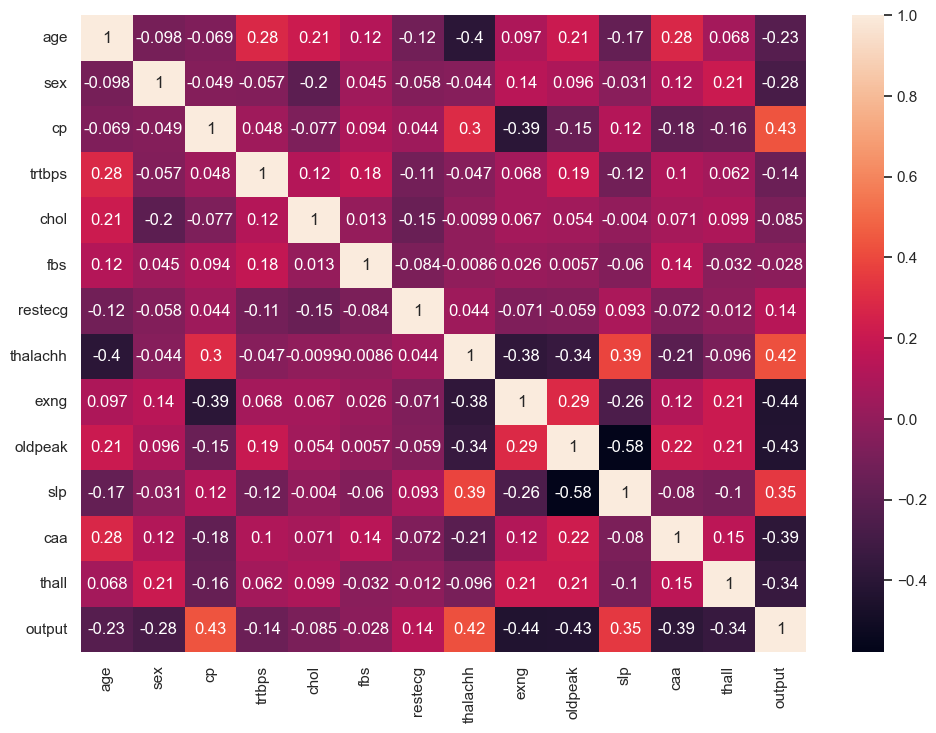

In [9]:
# Create a heatmap of the correlation matrix for the DataFrame df
# annot=True displays the correlation values on the heatmap
sns.heatmap(df.corr(), annot=True)

Number of people with sex as Male: 96
Number of people with sex Female: 207


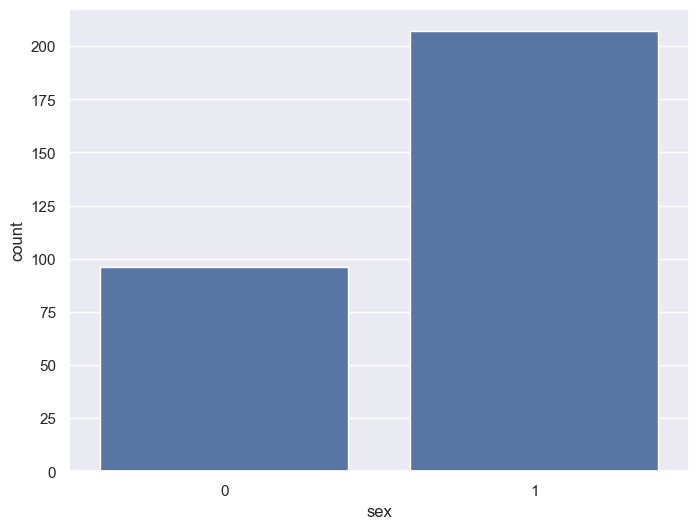

In [10]:
# Count the number of people by sex
sex_counts = df['sex'].value_counts()

# Print the counts
print(f'Number of people with sex as Male: {sex_counts[0]}')
print(f'Number of people with sex Female: {sex_counts[1]}')

# Plot the counts using seaborn
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="sex")
plt.show()

Counts of each chest pain type:
cp
0    143
2     87
1     50
3     23
Name: count, dtype: int64


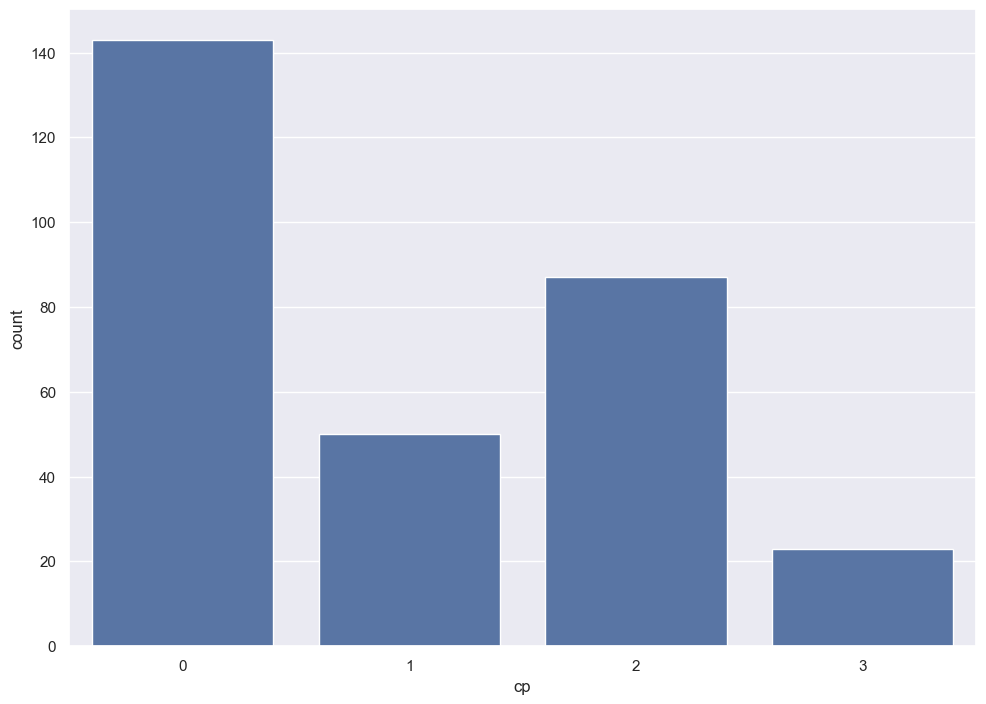

In [11]:
# Count the number of occurrences of each chest pain type
cp_counts = df['cp'].value_counts()

# Print the counts of each chest pain type
print("Counts of each chest pain type:")
print(cp_counts)

# Visualize the distribution of chest pain types
sns.countplot(data=df, x="cp")
plt.show()

Counts of each value in the 'chol' column:
chol
204    6
197    6
234    6
269    5
254    5
      ..
284    1
224    1
167    1
276    1
131    1
Name: count, Length: 152, dtype: int64


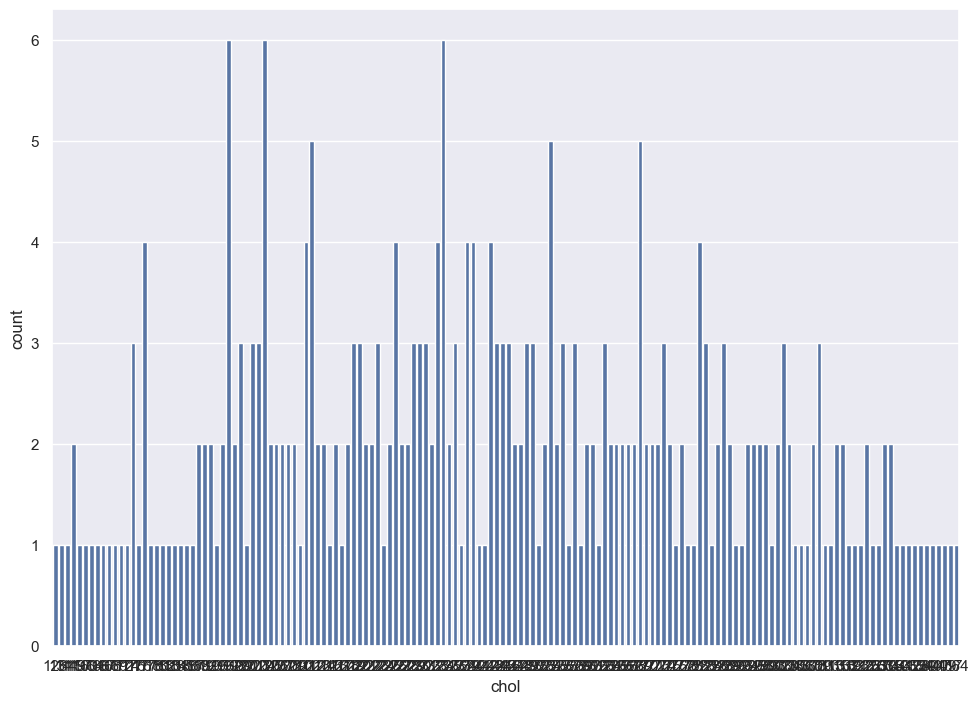

In [12]:
# Count the number of occurrences of each value in the "chol" column
chol_counts = df['chol'].value_counts()

# Print the counts of each value in the "chol" column
print("Counts of each value in the 'chol' column:")
print(chol_counts)

# Visualize the distribution of values in the "chol" column
sns.countplot(data=df, x="chol")
plt.show()

Counts of each value in the 'fbs' column:
fbs
0    258
1     45
Name: count, dtype: int64


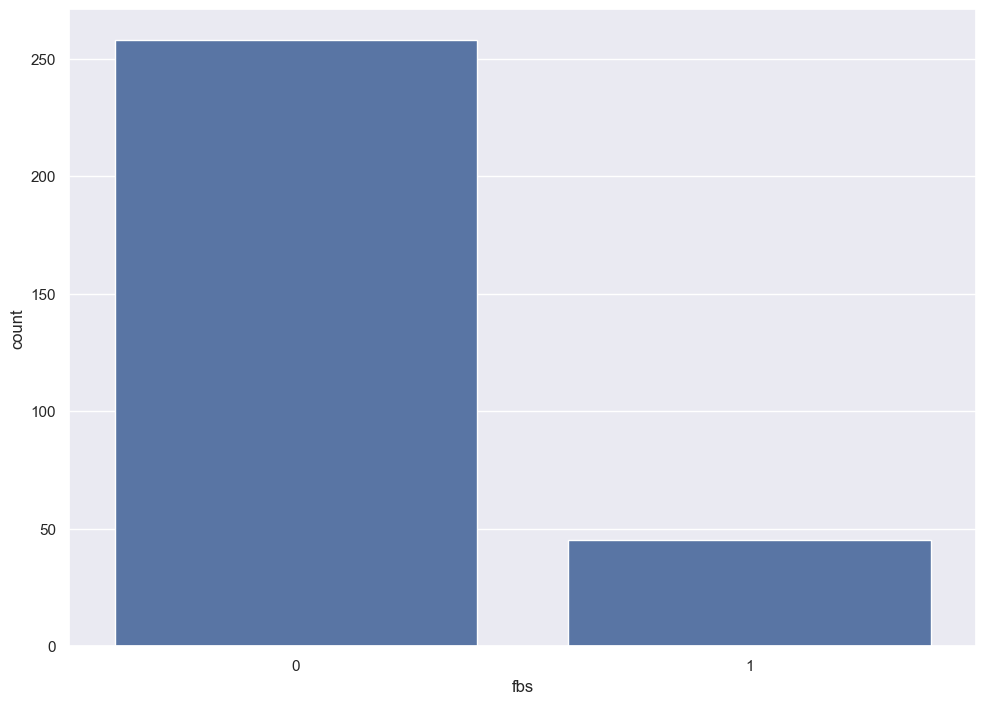

In [13]:
# Count the number of occurrences of each value in the "fbs" column
fbs_counts = df['fbs'].value_counts()

# Print the counts of each value in the "fbs" column
print("Counts of each value in the 'fbs' column:")
print(fbs_counts)

# Visualize the distribution of values in the "fbs" column
sns.countplot(data=df, x="fbs")
plt.show()

Counts of each value in the 'restecg' column:
restecg
1    152
0    147
2      4
Name: count, dtype: int64


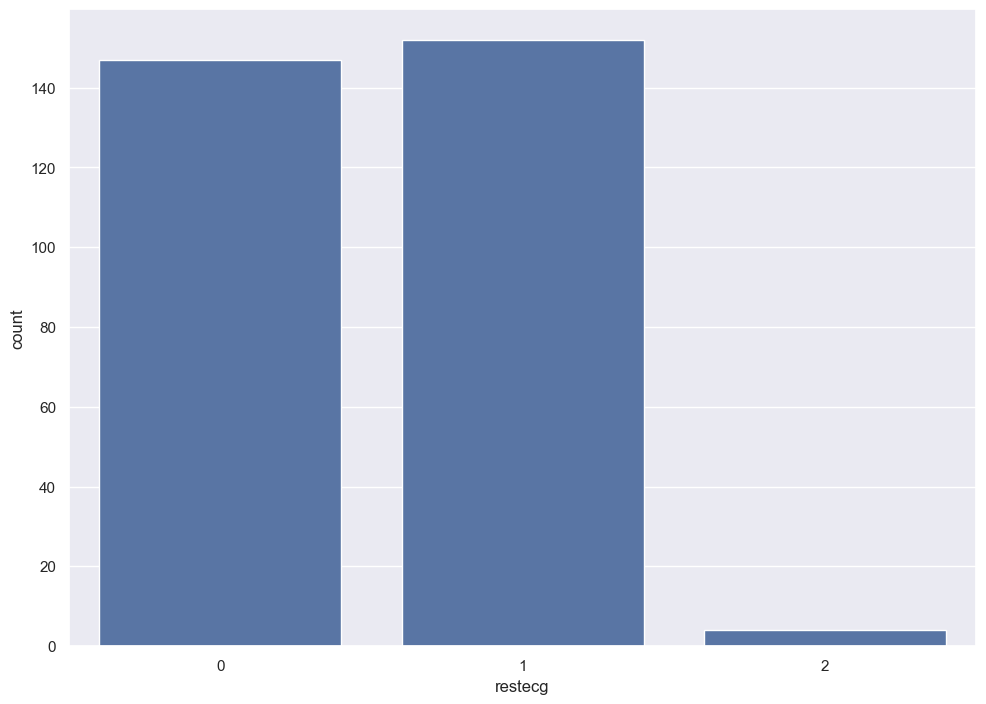

In [14]:
# Count the number of occurrences of each value in the "restecg" column
restecg_counts = df['restecg'].value_counts()

# Print the counts of each value in the "restecg" column
print("Counts of each value in the 'restecg' column:")
print(restecg_counts)

# Visualize the distribution of values in the "restecg" column
sns.countplot(data=df, x="restecg")
plt.show()

Counts of each value in the 'exng' column:
exng
0    204
1     99
Name: count, dtype: int64


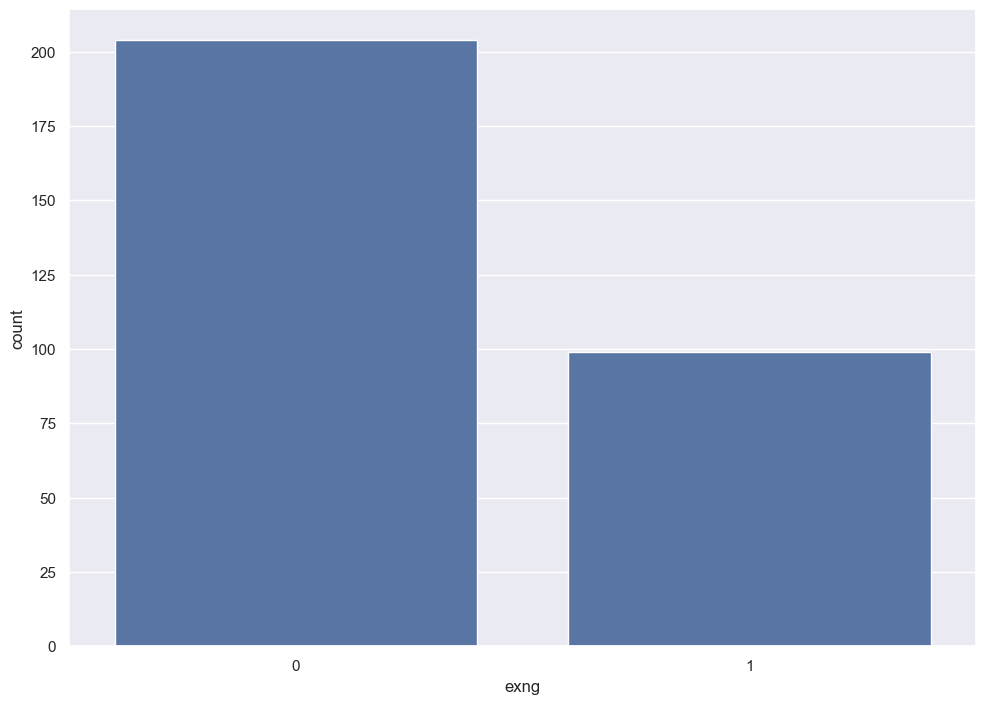

In [15]:
# Count the number of occurrences of each value in the "exng" column
exng_counts = df['exng'].value_counts()

# Print the counts of each value in the "exng" column
print("Counts of each value in the 'exng' column:")
print(exng_counts)

# Visualize the distribution of values in the "exng" column using a countplot
sns.countplot(data=df, x="exng")
plt.show()

Counts of each value in the 'oldpeak' column:
oldpeak
0.0    99
1.2    17
1.0    14
0.6    14
1.4    13
0.8    13
0.2    12
1.6    11
1.8    10
0.4     9
2.0     9
0.1     7
2.8     6
2.6     6
1.5     5
3.0     5
1.9     5
0.5     5
3.6     4
2.2     4
2.4     3
0.9     3
3.4     3
4.0     3
0.3     3
2.3     2
3.2     2
2.5     2
4.2     2
1.1     2
3.1     1
0.7     1
3.5     1
6.2     1
1.3     1
5.6     1
2.9     1
2.1     1
3.8     1
4.4     1
Name: count, dtype: int64


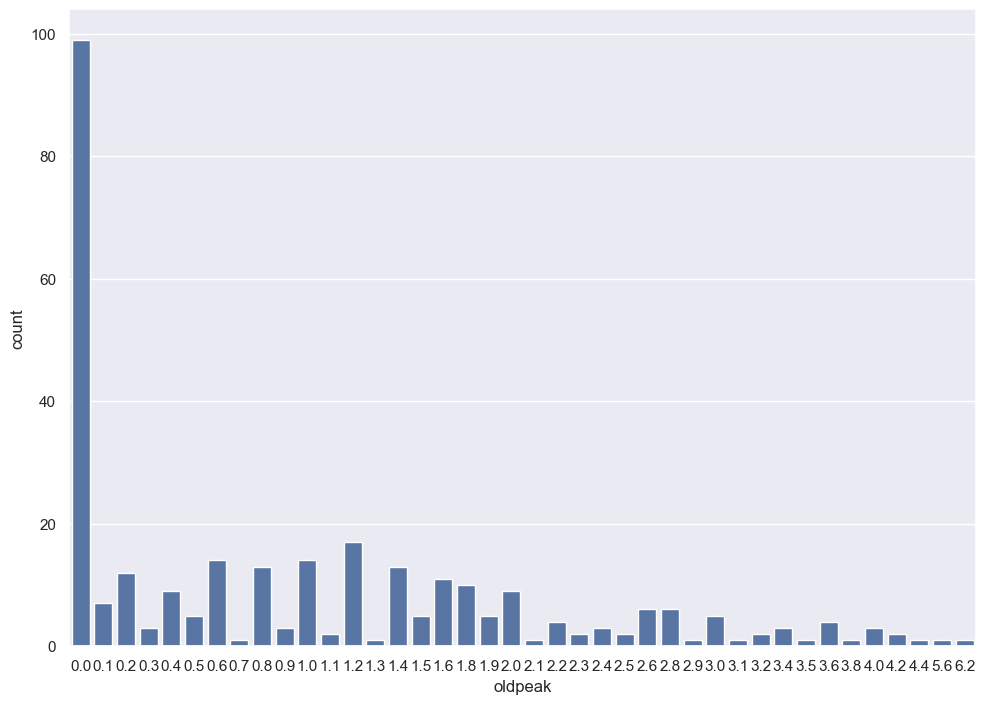

In [16]:
# Count the number of occurrences of each value in the "oldpeak" column
oldpeak_counts = df['oldpeak'].value_counts()

# Print the counts of each value in the "oldpeak" column
print("Counts of each value in the 'oldpeak' column:")
print(oldpeak_counts)

# Visualize the distribution of values in the "oldpeak" column using a countplot
sns.countplot(data=df, x="oldpeak")
plt.show()

Counts of each value in the 'slp' column:
slp
2    142
1    140
0     21
Name: count, dtype: int64


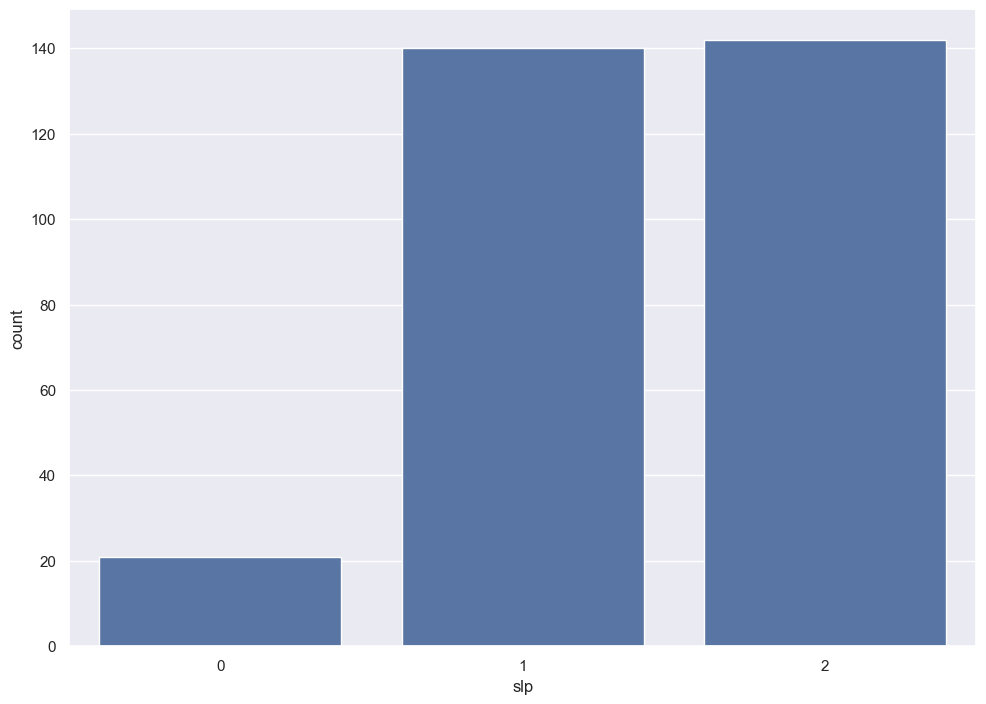

In [17]:
# Count the number of occurrences of each value in the "slp" column
slp_counts = df['slp'].value_counts()

# Print the counts of each value in the "slp" column
print("Counts of each value in the 'slp' column:")
print(slp_counts)

# Visualize the distribution of values in the "slp" column using a countplot
sns.countplot(data=df, x="slp")
plt.show()

Counts of each value in the 'caa' column:
caa
0    175
1     65
2     38
3     20
4      5
Name: count, dtype: int64


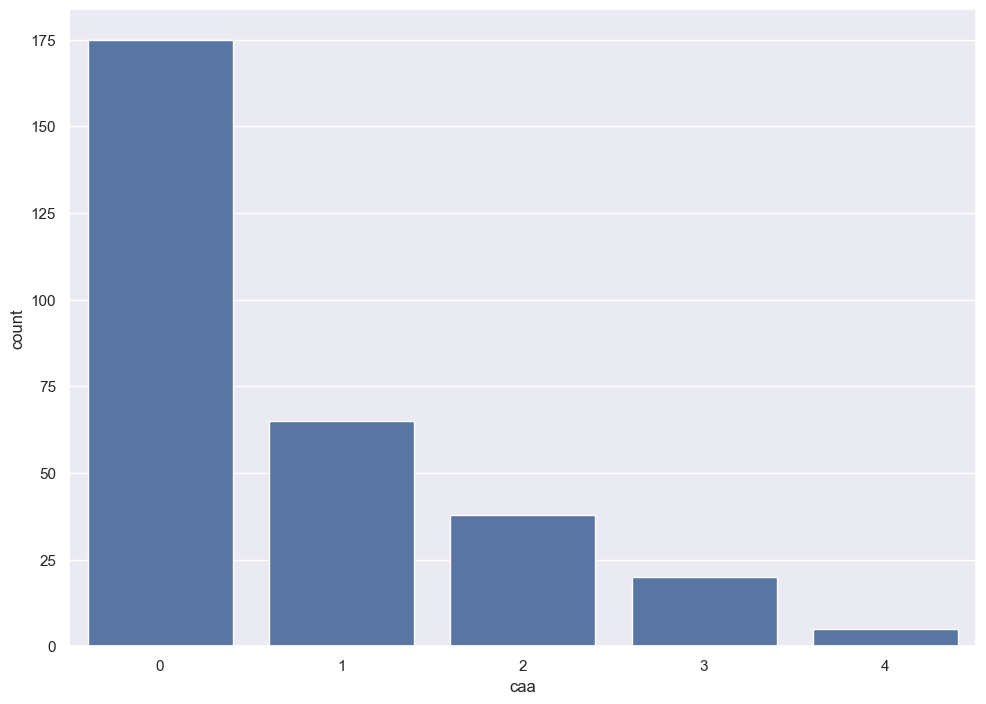

In [18]:
# Count the number of occurrences of each value in the "caa" column
caa_counts = df['caa'].value_counts()

# Print the counts of each value in the "caa" column
print("Counts of each value in the 'caa' column:")
print(caa_counts)

# Visualize the distribution of values in the "caa" column using a countplot
sns.countplot(data=df, x="caa")
plt.show()

Counts of each value in the 'thall' column:
thall
2    166
3    117
1     18
0      2
Name: count, dtype: int64


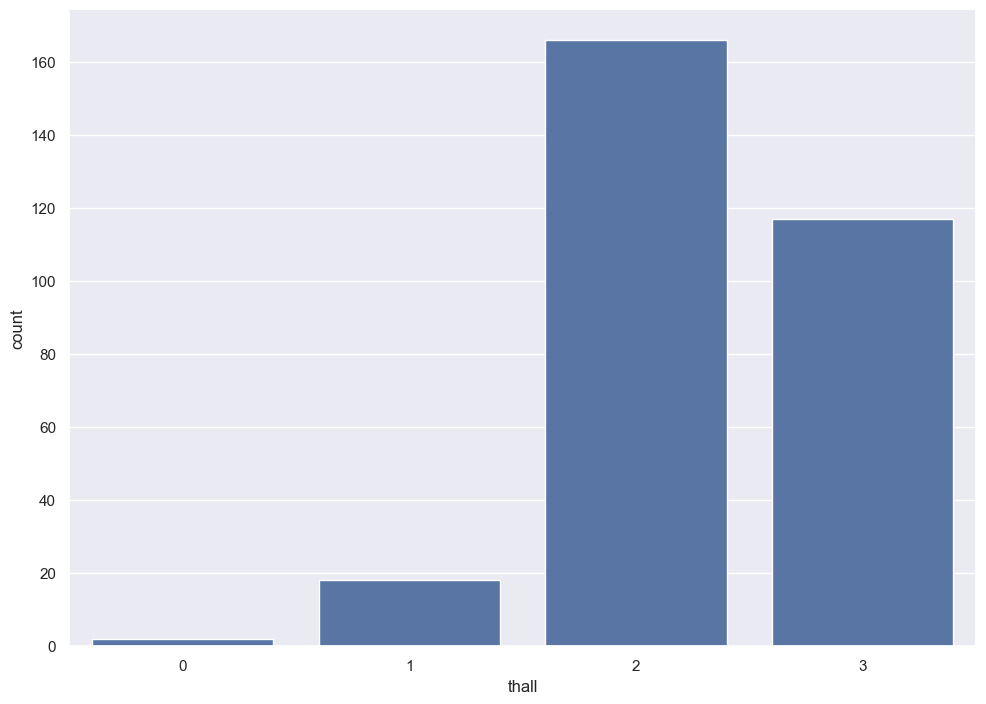

In [19]:
# Count the number of occurrences of each value in the "thall" column
thall_counts = df['thall'].value_counts()

# Print the counts of each value in the "thall" column
print("Counts of each value in the 'thall' column:")
print(thall_counts)

# Visualize the distribution of values in the "thall" column using a countplot
sns.countplot(data=df, x="thall")
plt.show()

Counts of each value in the 'output' column:
output
1    165
0    138
Name: count, dtype: int64


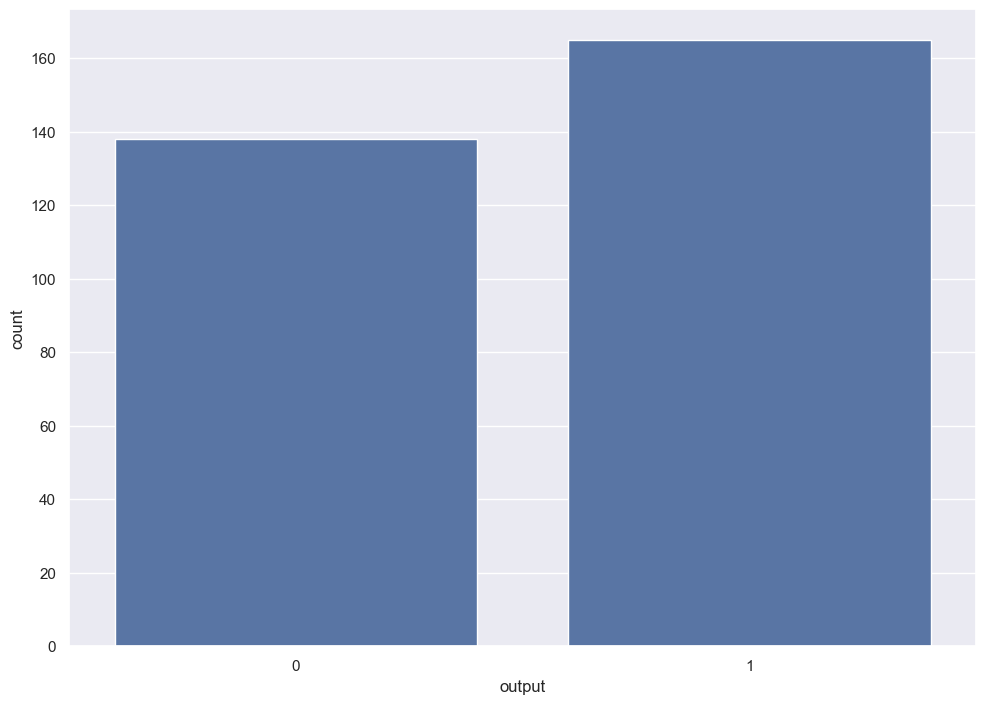

In [20]:
# Count the number of occurrences of each value in the "output" column
output_counts = df['output'].value_counts()

# Print the counts of each value in the "output" column
print("Counts of each value in the 'output' column:")
print(output_counts)

# Visualize the distribution of values in the "output" column using a countplot
sns.countplot(data=df, x="output")
plt.show()

<Figure size 1000x1000 with 0 Axes>

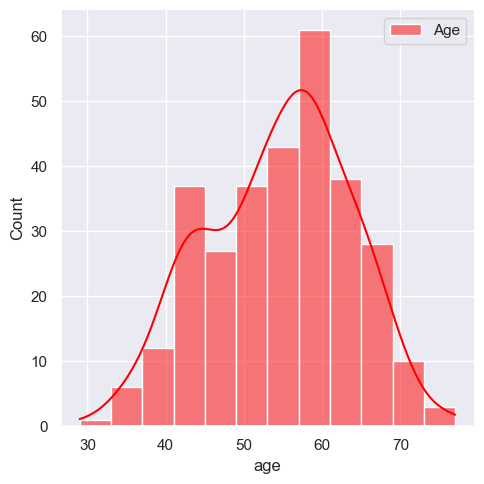

In [21]:
# Set the size of the figure
plt.figure(figsize=(10, 10))

# Create a distribution plot for the "age" column
sns.displot(df.age, color="red", label="Age", kde=True)

# Add a legend
plt.legend()

# Display the plot
plt.show()

<Figure size 2000x2000 with 0 Axes>

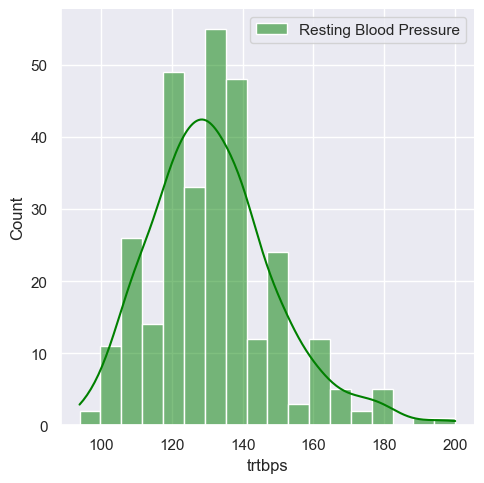

In [22]:
# Set the size of the figure
plt.figure(figsize=(20, 20))

# Create a distribution plot for the "trtbps" (Resting Blood Pressure) column
sns.displot(df.trtbps, color="green", label="Resting Blood Pressure", kde=True)

# Add a legend
plt.legend()

Heart Attack Vs Age

C:\Users\piyus\AppData\Local\Temp\ipykernel_17976\3403143332.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['output'] == 0]["age"], color='green', label='No attack')
C:\Users\piyus\AppData\Local\Temp\ipykernel_17976\3403143332.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df[

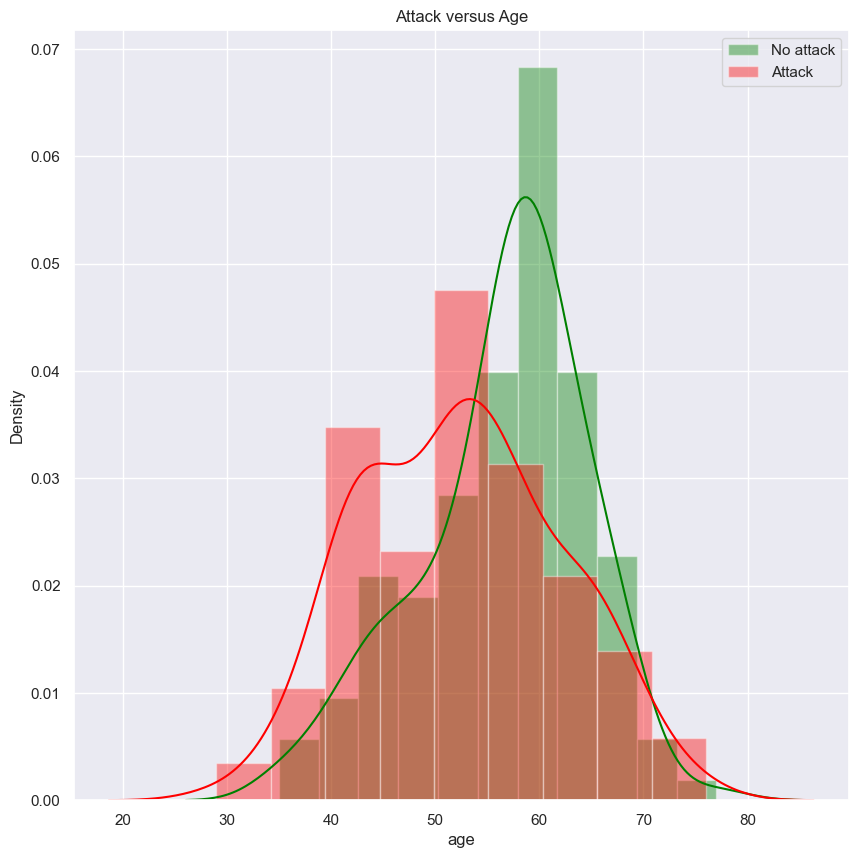

In [23]:
# Set the size of the figure
plt.figure(figsize=(10, 10))

# Plot the distribution of age for patients with output 0 (No attack) in green
sns.distplot(df[df['output'] == 0]["age"], color='green', label='No attack')

# Plot the distribution of age for patients with output 1 (Attack) in red
sns.distplot(df[df['output'] == 1]["age"], color='red', label='Attack')

# Add a title to the plot
plt.title('Attack versus Age')

# Add a legend
plt.legend()

# Show the plot
plt.show()

Cholrestrol versus age

C:\Users\piyus\AppData\Local\Temp\ipykernel_17976\4059806457.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['output'] == 0]["chol"], color='green', label='No attack')
C:\Users\piyus\AppData\Local\Temp\ipykernel_17976\4059806457.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df

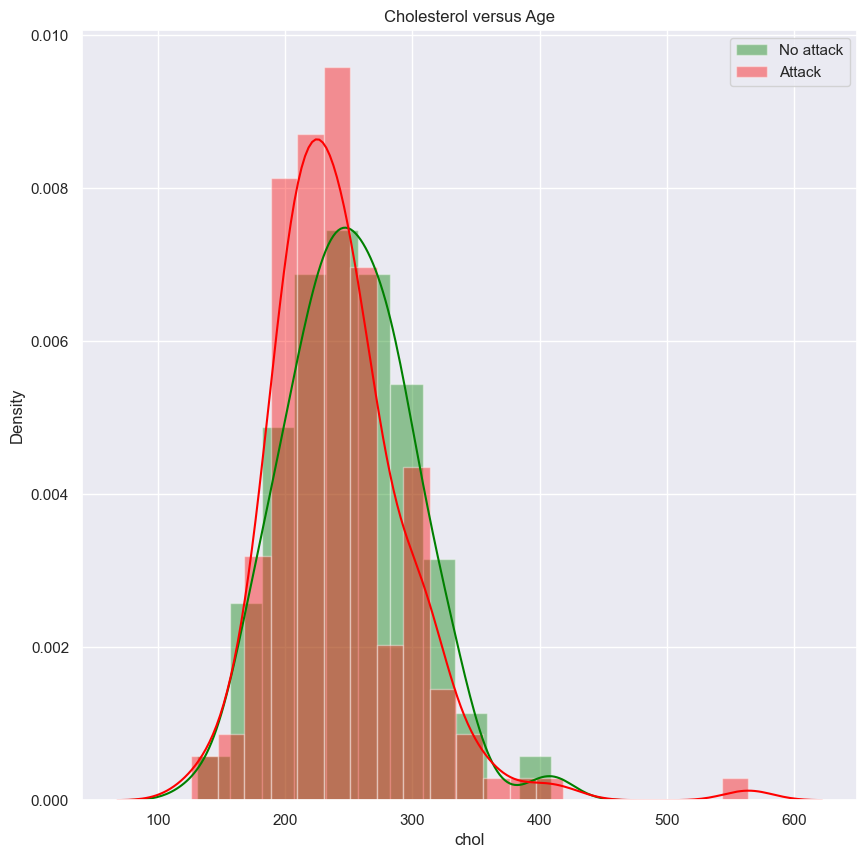

In [24]:
# Set the size of the figure
plt.figure(figsize=(10, 10))

# Plot the distribution of cholesterol for patients with output 0 (No attack) in green
sns.distplot(df[df['output'] == 0]["chol"], color='green', label='No attack')

# Plot the distribution of cholesterol for patients with output 1 (Attack) in red
sns.distplot(df[df['output'] == 1]["chol"], color='red', label='Attack')

# Add a title to the plot
plt.title('Cholesterol versus Age')

# Add a legend
plt.legend()

# Show the plot
plt.show()

trtbps versus age 

C:\Users\piyus\AppData\Local\Temp\ipykernel_17976\2693460542.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['output'] == 0]["trtbps"], color='green', label='No attack')
C:\Users\piyus\AppData\Local\Temp\ipykernel_17976\2693460542.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[

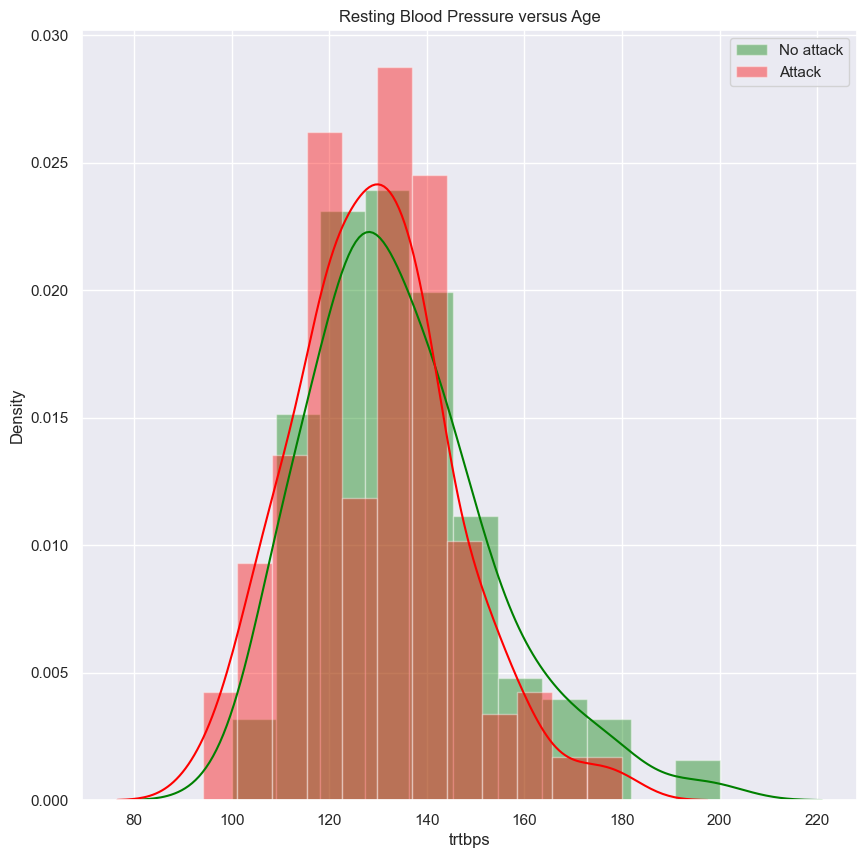

In [25]:
# Set the size of the figure
plt.figure(figsize=(10, 10))

# Plot the distribution of resting blood pressure for patients with output 0 (No attack) in green
sns.distplot(df[df['output'] == 0]["trtbps"], color='green', label='No attack')

# Plot the distribution of resting blood pressure for patients with output 1 (Attack) in red
sns.distplot(df[df['output'] == 1]["trtbps"], color='red', label='Attack')

# Add a title to the plot
plt.title('Resting Blood Pressure versus Age')

# Add a legend
plt.legend()

# Show the plot
plt.show()

thalachh versus age

C:\Users\piyus\AppData\Local\Temp\ipykernel_17976\3117581427.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['output'] == 0]["thalachh"], color='green', label='No attack')
C:\Users\piyus\AppData\Local\Temp\ipykernel_17976\3117581427.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(d

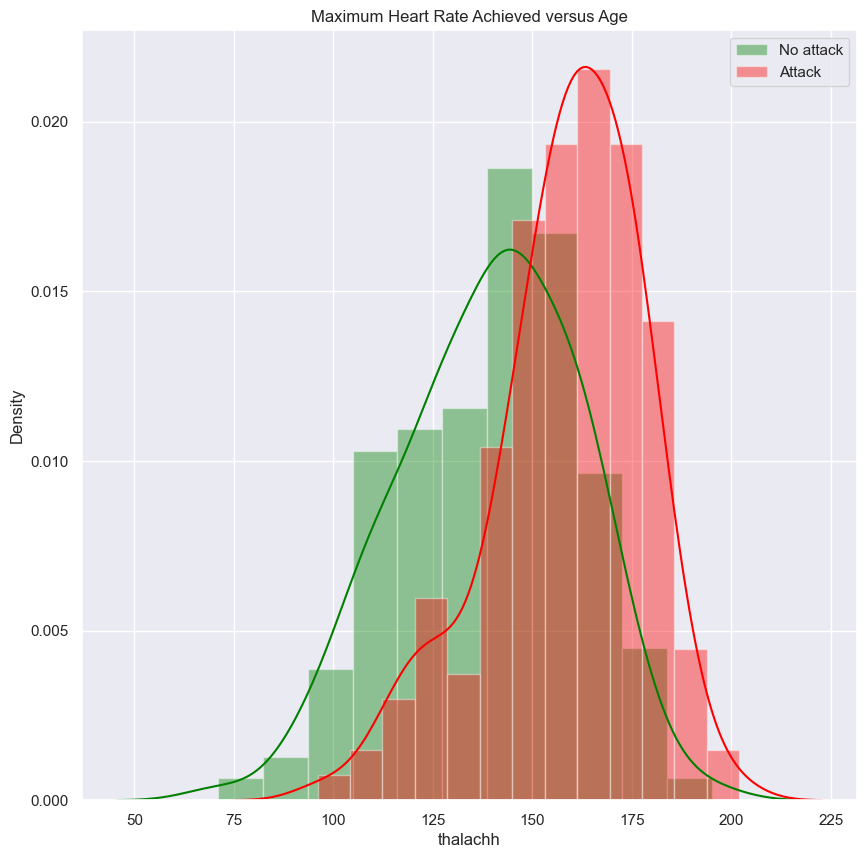

In [26]:
# Set the size of the figure
plt.figure(figsize=(10, 10))

# Plot the distribution of maximum heart rate achieved for patients with output 0 (No attack) in green
sns.distplot(df[df['output'] == 0]["thalachh"], color='green', label='No attack')

# Plot the distribution of maximum heart rate achieved for patients with output 1 (Attack) in red
sns.distplot(df[df['output'] == 1]["thalachh"], color='red', label='Attack')

# Add a title to the plot
plt.title('Maximum Heart Rate Achieved versus Age')

# Add a legend
plt.legend()

# Show the plot
plt.show()

Pair Plot

<Figure size 2000x2000 with 0 Axes>

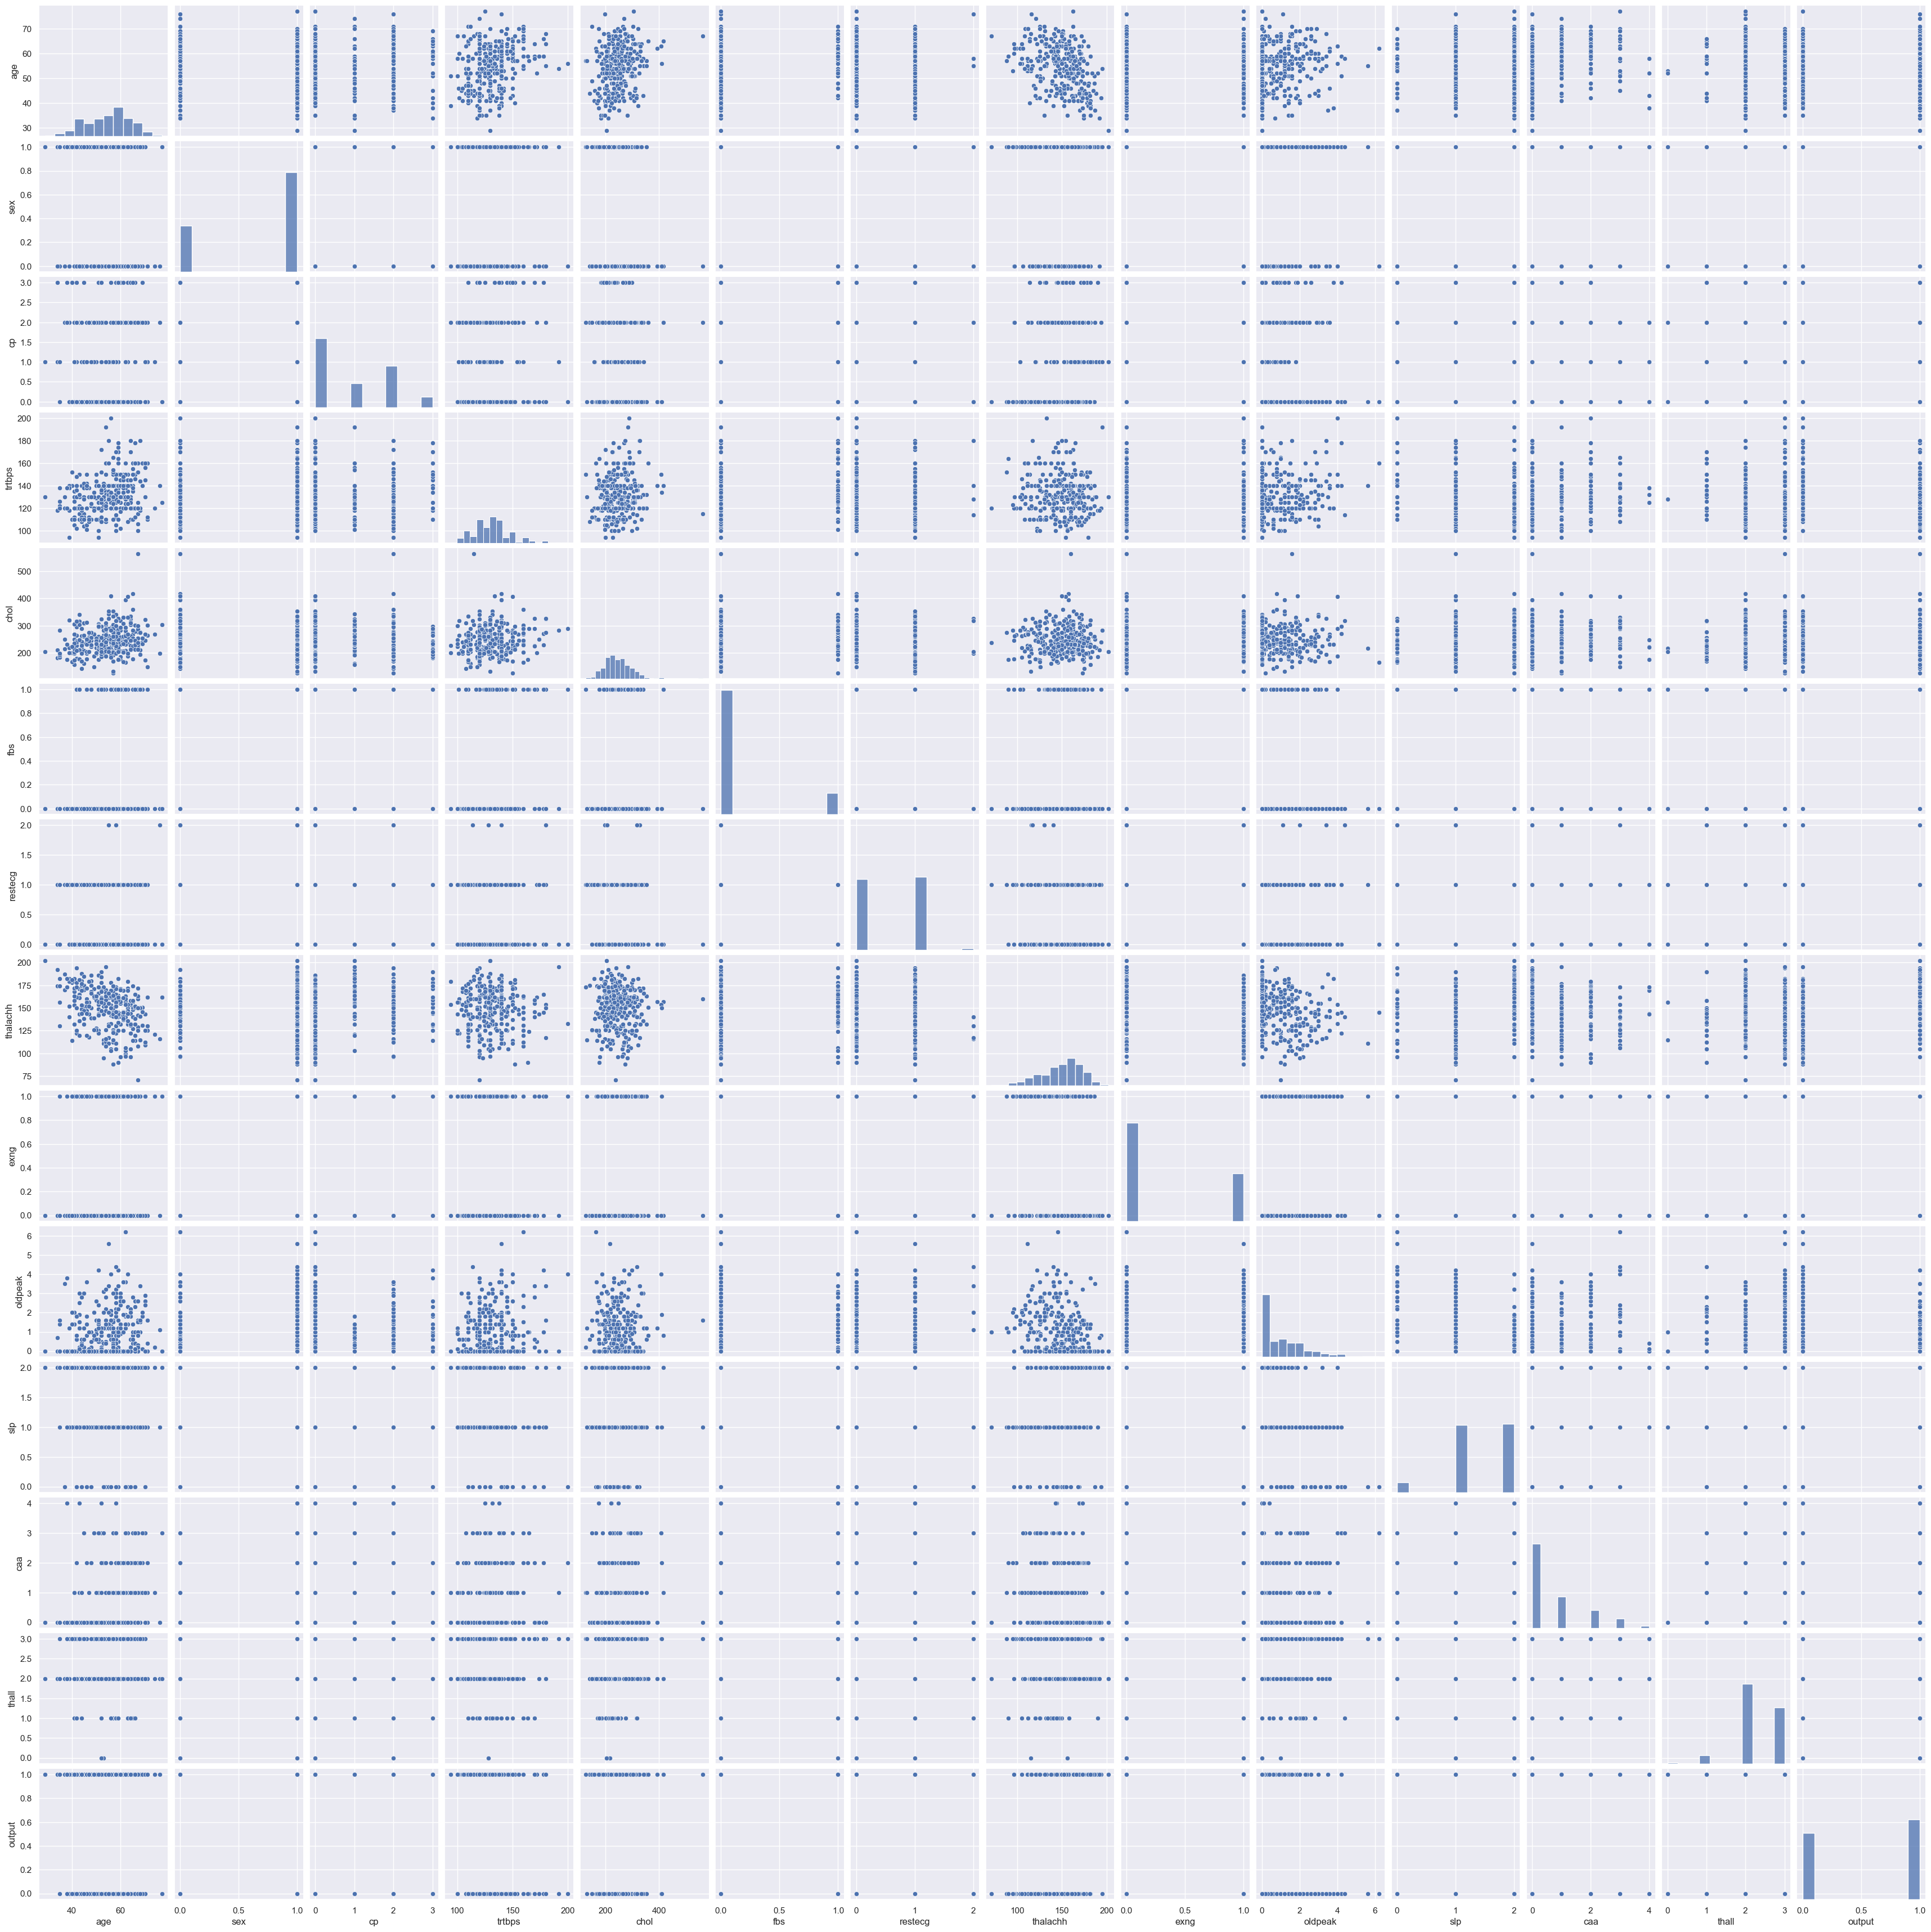

In [27]:
# Set the size of the figure
plt.figure(figsize=(20, 20))

# Create a pairwise plot of all numerical variables in the DataFrame
sns.pairplot(df)

# Show the plot
plt.show()

DATA PROCESSING

In [28]:
df.drop(columns='output')

age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0     63    1   3     145   233    1        0       150     0      2.3    0   
1     37    1   2     130   250    0        1       187     0      3.5    0   
2     41    0   1     130   204    0        0       172     0      1.4    2   
3     56    1   1     120   236    0        1       178     0      0.8    2   
4     57    0   0     120   354    0        1       163     1      0.6    2   
..   ...  ...  ..     ...   ...  ...      ...       ...   ...      ...  ...   
298   57    0   0     140   241    0        1       123     1      0.2    1   
299   45    1   3     110   264    0        1       132     0      1.2    1   
300   68    1   0     144   193    1        1       141     0      3.4    1   
301   57    1   0     130   131    0        1       115     1      1.2    1   
302   57    0   1     130   236    0        0       174     0      0.0    1   

     caa  thall  
0      0      1  
1      0      2  
2      0      2  
3      0      2  
4      0      2  
..   ...    ...  
298    0      3  
299    0      3  
300    2      3  
301    1      3  
302    1      2  

[303 rows x 13 columns]

In [29]:
df.describe()

age         sex          cp      trtbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.500000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg    thalachh        exng     oldpeak         slp         caa  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean     0.528053  149.646865    0.326733    1.039604    1.399340    0.729373   
std      0.525860   22.905161    0.469794    1.161075    0.616226    1.022606   
min      0.000000   71.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000  133.500000    0.000000    0.000000    1.000000    0.000000   
50%      1.000000  153.000000    0.000000    0.800000    1.000000    0.000000   
75%      1.000000  166.000000    1.000000    1.600000    2.000000    1.000000   
max      2.000000  202.000000    1.000000    6.200000    2.000000    4.000000   

            thall      output  
count  303.000000  303.000000  
mean     2.313531    0.544554  
std      0.612277    0.498835  
min      0.000000    0.000000  
25%      2.000000    0.000000  
50%      2.000000    1.000000  
75%      3.000000    1.000000  
max      3.000000    1.000000

In [30]:
# Extract feature variables (all columns except the first and last) and target variable (last column)
x = df.iloc[:, 1:-1].values
y = df.iloc[:, -1].values

# Print the feature variables (x) and target variable (y)
x, y

(array([[  1.,   3., 145., ...,   0.,   0.,   1.],
        [  1.,   2., 130., ...,   0.,   0.,   2.],
        [  0.,   1., 130., ...,   2.,   0.,   2.],
        ...,
        [  1.,   0., 144., ...,   1.,   2.,   3.],
        [  1.,   0., 130., ...,   1.,   1.,   3.],
        [  0.,   1., 130., ...,   1.,   1.,   2.]]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0,

Splitting the Dataset

In [31]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [32]:
# Initialize StandardScaler
scaler = StandardScaler()

# Standardize the training data (x_train)
x_train = scaler.fit_transform(x_train)

# Standardize the testing data (x_test) using the same scaler as training data
x_test = scaler.transform(x_test)

In [33]:
x_train, x_test

(array([[-1.43641607,  0.98584243, -0.57412513, ..., -0.66169316,
         -0.70710678, -0.46472917],
        [-1.43641607,  0.98584243,  0.83106608, ..., -0.66169316,
          0.26516504, -0.46472917],
        [ 0.69617712,  0.98584243,  0.47976828, ...,  0.95577901,
         -0.70710678, -0.46472917],
        ...,
        [ 0.69617712,  1.94013791, -0.69122439, ..., -0.66169316,
         -0.70710678,  1.14190596],
        [ 0.69617712,  0.98584243,  0.36266901, ...,  0.95577901,
         -0.70710678, -0.46472917],
        [ 0.69617712,  0.03154696, -0.69122439, ..., -0.66169316,
         -0.70710678, -0.46472917]]),
 array([[ 0.69617712, -0.92274852,  0.77251645, -1.36354075, -0.41803981,
          0.90163913, -1.07375268,  1.40984195,  1.2900049 , -2.27916533,
         -0.70710678,  1.14190596],
        [ 0.69617712,  1.94013791,  2.23625729, -0.3703119 , -0.41803981,
         -0.97936664,  0.22375805, -0.70929937, -0.38883987, -0.66169316,
         -0.70710678,  1.14190596],
     

In [34]:
y_train, y_test

(array([1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
        1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0],
       dtype=int64),
 array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        1, 1, 1,

Model Initializations

In [35]:
# Define the parameter grid for early stopping
early_stopping_params = [(5, True), (10, False)]

In [36]:
# Define k-fold cross-validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

1.  multi-layer perceptron Model

In [37]:
# Initialize necessary variables
best_accuracy_MLP = 0.0
best_auc_roc_MLP = 0.0
best_f1_score_MLP = 0.0
best_loss_MLP = float('inf')
best_precision_MLP = 0.0
best_training_time_MLP = float('inf')
best_model_MLP = None
best_confusion_matrix_MLP = None
best_recall_MLP = 0.0
fold_histories = {}
accuracy_list = []
loss_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []
confusion_matrices = [] 
training_time_list = []
fold_histories_MLP = {}

results_df_mlp = pd.DataFrame(columns=['Fold', 'Early_Stopping', 'Accuracy', 'Loss', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Training_Time'])

In [59]:
# Perform grid search
for fold_index, (train_index, val_index) in enumerate(kfold.split(x_train, y_train), 1):
    print(f"\nFold {fold_index}:")

    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Apply SMOTE for data augmentation
    smote = SMOTE(random_state=42)
    x_train_fold, y_train_fold = smote.fit_resample(x_train_fold, y_train_fold)

    accuracies_MLP = []
    losses_MLP = []
    precisions_MLP = []
    recalls_MLP = []
    f1_scores_MLP = []
    auc_rocs_MLP = []
    training_times_MLP = []

    for early_stopping_param in early_stopping_params:
        # Define your model architecture as a Multi-Layer Perceptron with L2 regularization and batch normalization
        model_MLP = Sequential([
        Dense(32, activation='relu', input_shape=(x_train.shape[1],), kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

        # Compile the model with binary cross-entropy loss
        model_MLP.compile(optimizer='RMSProp', loss='binary_crossentropy', metrics=['accuracy'])

        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_param[0], restore_best_weights=early_stopping_param[1])

        # Train the model and measure training time
        start_time = time.time()
        history = model_MLP.fit(x_train_fold, y_train_fold, epochs=75, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)
        training_time = time.time() - start_time
        training_times_MLP.append(training_time)

        # Evaluate the model on validation data
        eval_loss, accuracy_MLP = model_MLP.evaluate(x_val_fold, y_val_fold)
        accuracies_MLP.append(accuracy_MLP)
        losses_MLP.append(eval_loss)

        # Get predictions for calculating additional metrics
        y_pred = (model_MLP.predict(x_val_fold) > 0.5).astype("int32")

        # Calculate additional metrics
        precision = precision_score(y_val_fold, y_pred)
        recall = recall_score(y_val_fold, y_pred)
        f1 = f1_score(y_val_fold, y_pred)
        auc = roc_auc_score(y_val_fold, y_pred)

        precisions_MLP.append(precision)
        recalls_MLP.append(recall)
        f1_scores_MLP.append(f1)
        auc_rocs_MLP.append(auc)

        # Append results to the DataFrame
        results_df_mlp = pd.concat([results_df_mlp, pd.DataFrame({
            'Fold': [fold_index],
            'Early_Stopping': [early_stopping_param],
            'Accuracy': [accuracy_MLP],
            'Loss': [eval_loss],
            'Precision': [precision],
            'Recall': [recall],
            'F1-Score': [f1],
            'AUC-ROC': [auc],
            'Training_Time': [training_time]
        })], ignore_index=True)

        print(f"Early Stopping: {early_stopping_param}, Accuracy = {accuracy_MLP:.4f}, Loss = {eval_loss:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1-Score = {f1:.4f}, AUC-ROC = {auc:.4f}, Training Time = {training_time:.2f} seconds")

        # Update lists for histograms
        accuracy_list.extend(accuracies_MLP)
        loss_list.extend(losses_MLP)
        precision_list.extend(precisions_MLP)
        recall_list.extend(recalls_MLP)
        f1_list.extend(f1_scores_MLP)
        auc_list.extend(auc_rocs_MLP)
        training_time_list.extend(training_times_MLP)

        # Calculate mean accuracy and loss
        mean_accuracy_MLP = np.mean(accuracies_MLP)
        mean_loss_MLP = np.mean(losses_MLP)

        # Store training history
        fold_histories[fold_index] = history

        # Update best parameters if the metrics are improved
        if mean_accuracy_MLP > best_accuracy_MLP:
            best_accuracy_MLP = mean_accuracy_MLP
            best_model_MLP = model_MLP
            best_confusion_matrix_MLP = confusion_matrix(y_val_fold, y_pred)
            best_precision_MLP = precision
            best_recall_MLP = recall
            best_f1_score_MLP = f1
            best_auc_roc_MLP = auc
            best_recall_MLP = recall
            best_loss_MLP = eval_loss
            best_training_time_MLP = training_time

# Print best parameters and mean accuracy
print("Best Mean Accuracy:", best_accuracy_MLP)

# Save the best trained model to disk
if best_model_MLP is not None:
    best_model_MLP.save('saved_model/MLP_Model.h5')

# Find the best model based on validation accuracy
best_fold_index_MLP = results_df_mlp.loc[results_df_mlp['Accuracy'].idxmax()]['Fold']
best_model_history_MLP = fold_histories[best_fold_index_MLP]


Fold 1:
1/1 [==============================] - 0s 84ms/step
Early Stopping: (5, True), Accuracy = 0.8400, Loss = 0.6024, Precision = 0.8125, Recall = 0.9286, F1-Score = 0.8667, AUC-ROC = 0.8279, Training Time = 4.32 seconds
1/1 [==============================] - 0s 85ms/step
Early Stopping: (10, False), Accuracy = 0.7600, Loss = 0.5926, Precision = 0.7500, Recall = 0.8571, F1-Score = 0.8000, AUC-ROC = 0.7468, Training Time = 4.10 seconds

Fold 2:
1/1 [==============================] - 0s 83ms/step
Early Stopping: (5, True), Accuracy = 0.6000, Loss = 0.6375, Precision = 0.8000, Recall = 0.3077, F1-Score = 0.4444, AUC-ROC = 0.6122, Training Time = 1.49 seconds
1/1 [==============================] - 0s 76ms/step
Early Stopping: (10, False), Accuracy = 0.8000, Loss = 0.3615, Precision = 0.7857, Recall = 0.8462, F1-Score = 0.8148, AUC-ROC = 0.7981, Training Time = 4.24 seconds

Fold 3:
1/1 [==============================] - 0s 82ms/step
Early Stopping: (5, True), Accuracy = 0.7083, Loss = 

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [60]:
print(best_confusion_matrix_MLP)

[[11  0]
 [ 2 11]]


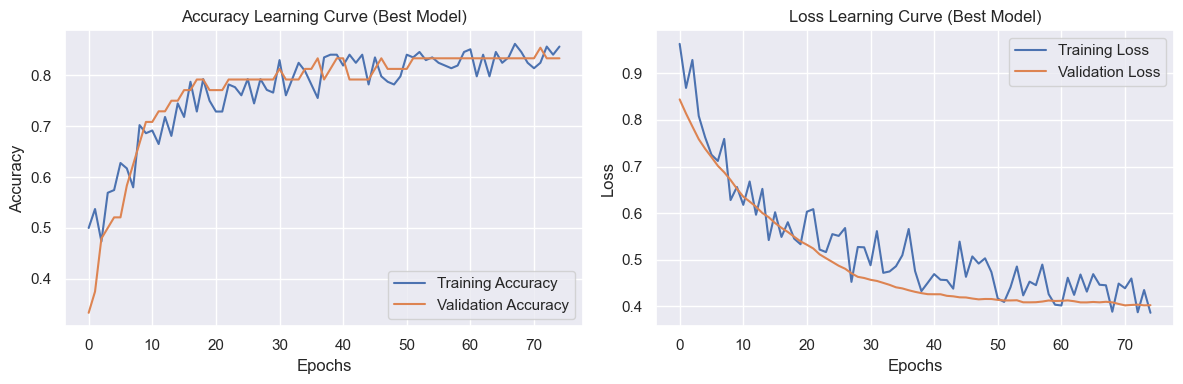

In [61]:
# Plot learning curves for the best model
plt.figure(figsize=(12, 4))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(best_model_history_MLP.history['accuracy'], label='Training Accuracy')
plt.plot(best_model_history_MLP.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Learning Curve (Best Model)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(best_model_history_MLP.history['loss'], label='Training Loss')
plt.plot(best_model_history_MLP.history['val_loss'], label='Validation Loss')
plt.title('Loss Learning Curve (Best Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

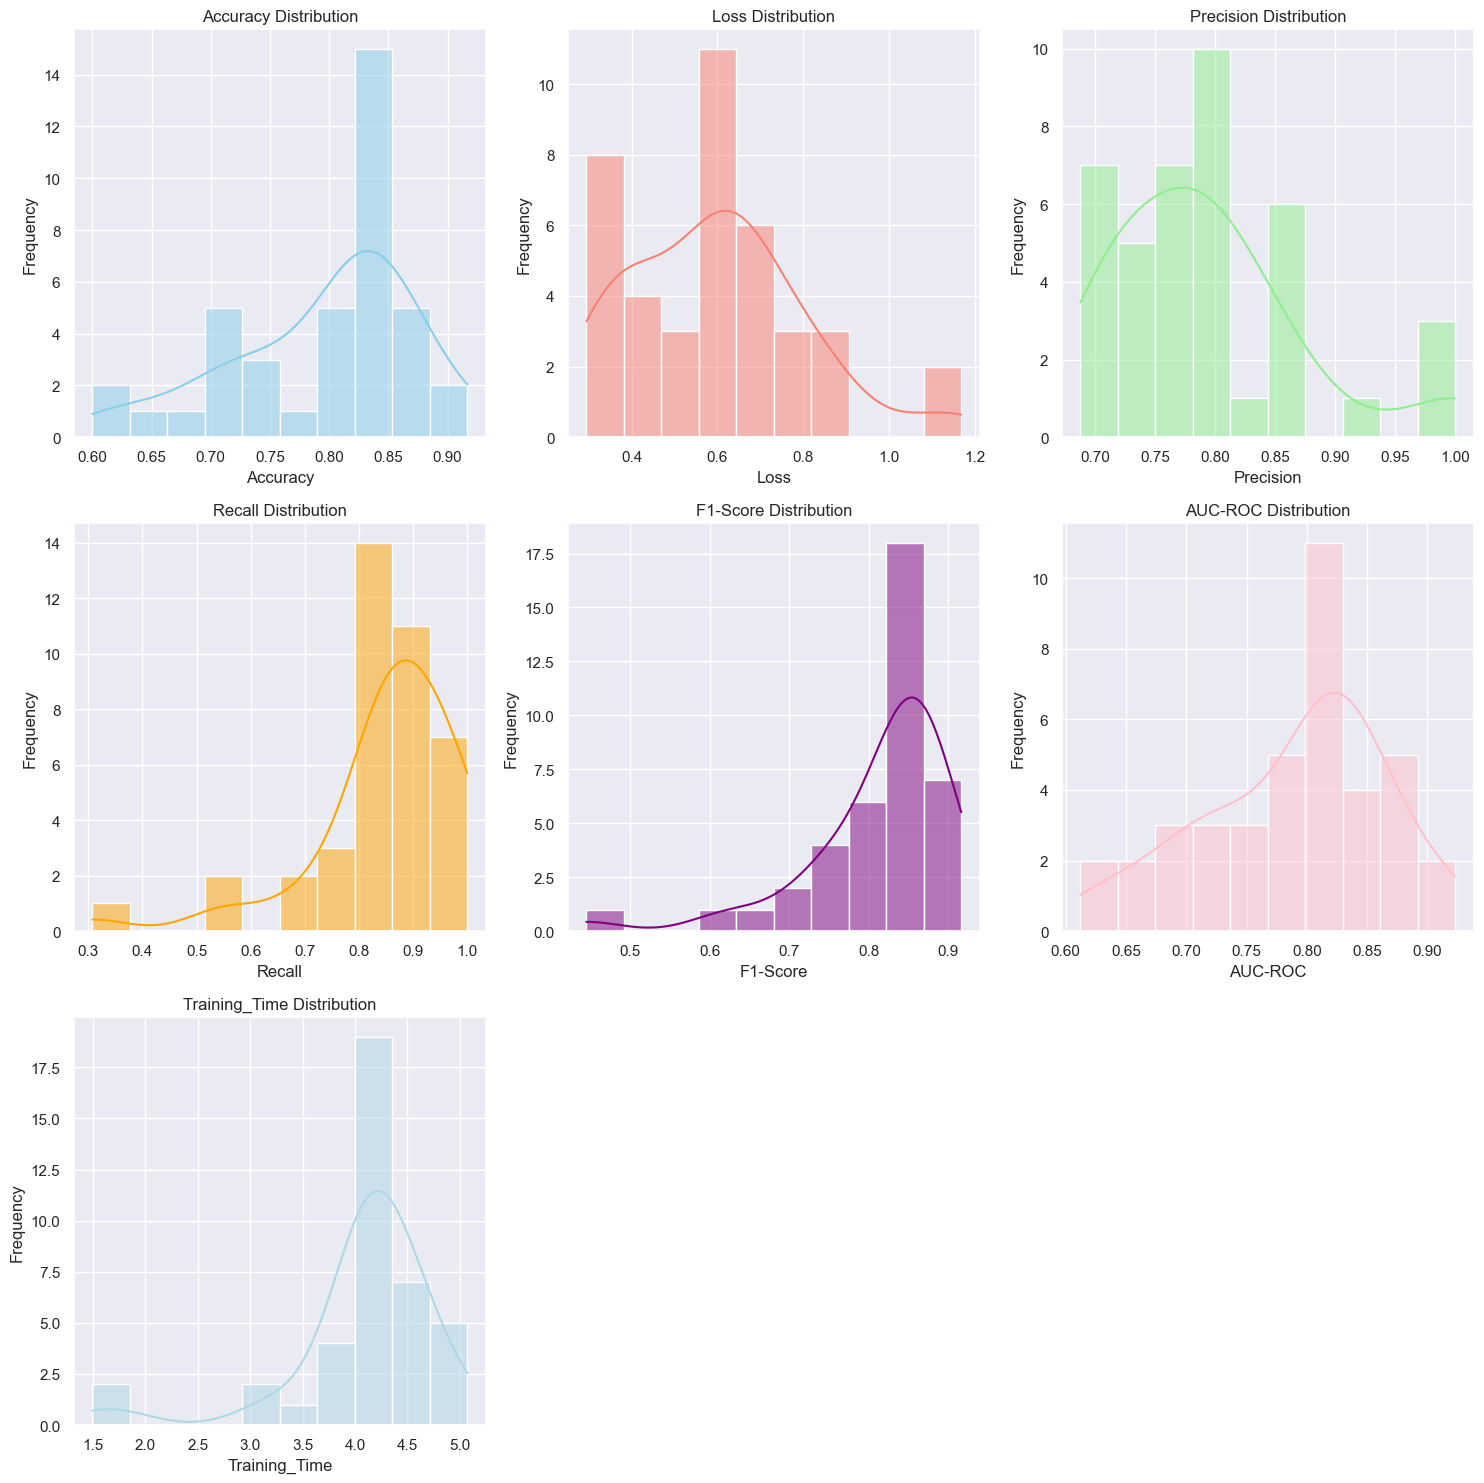

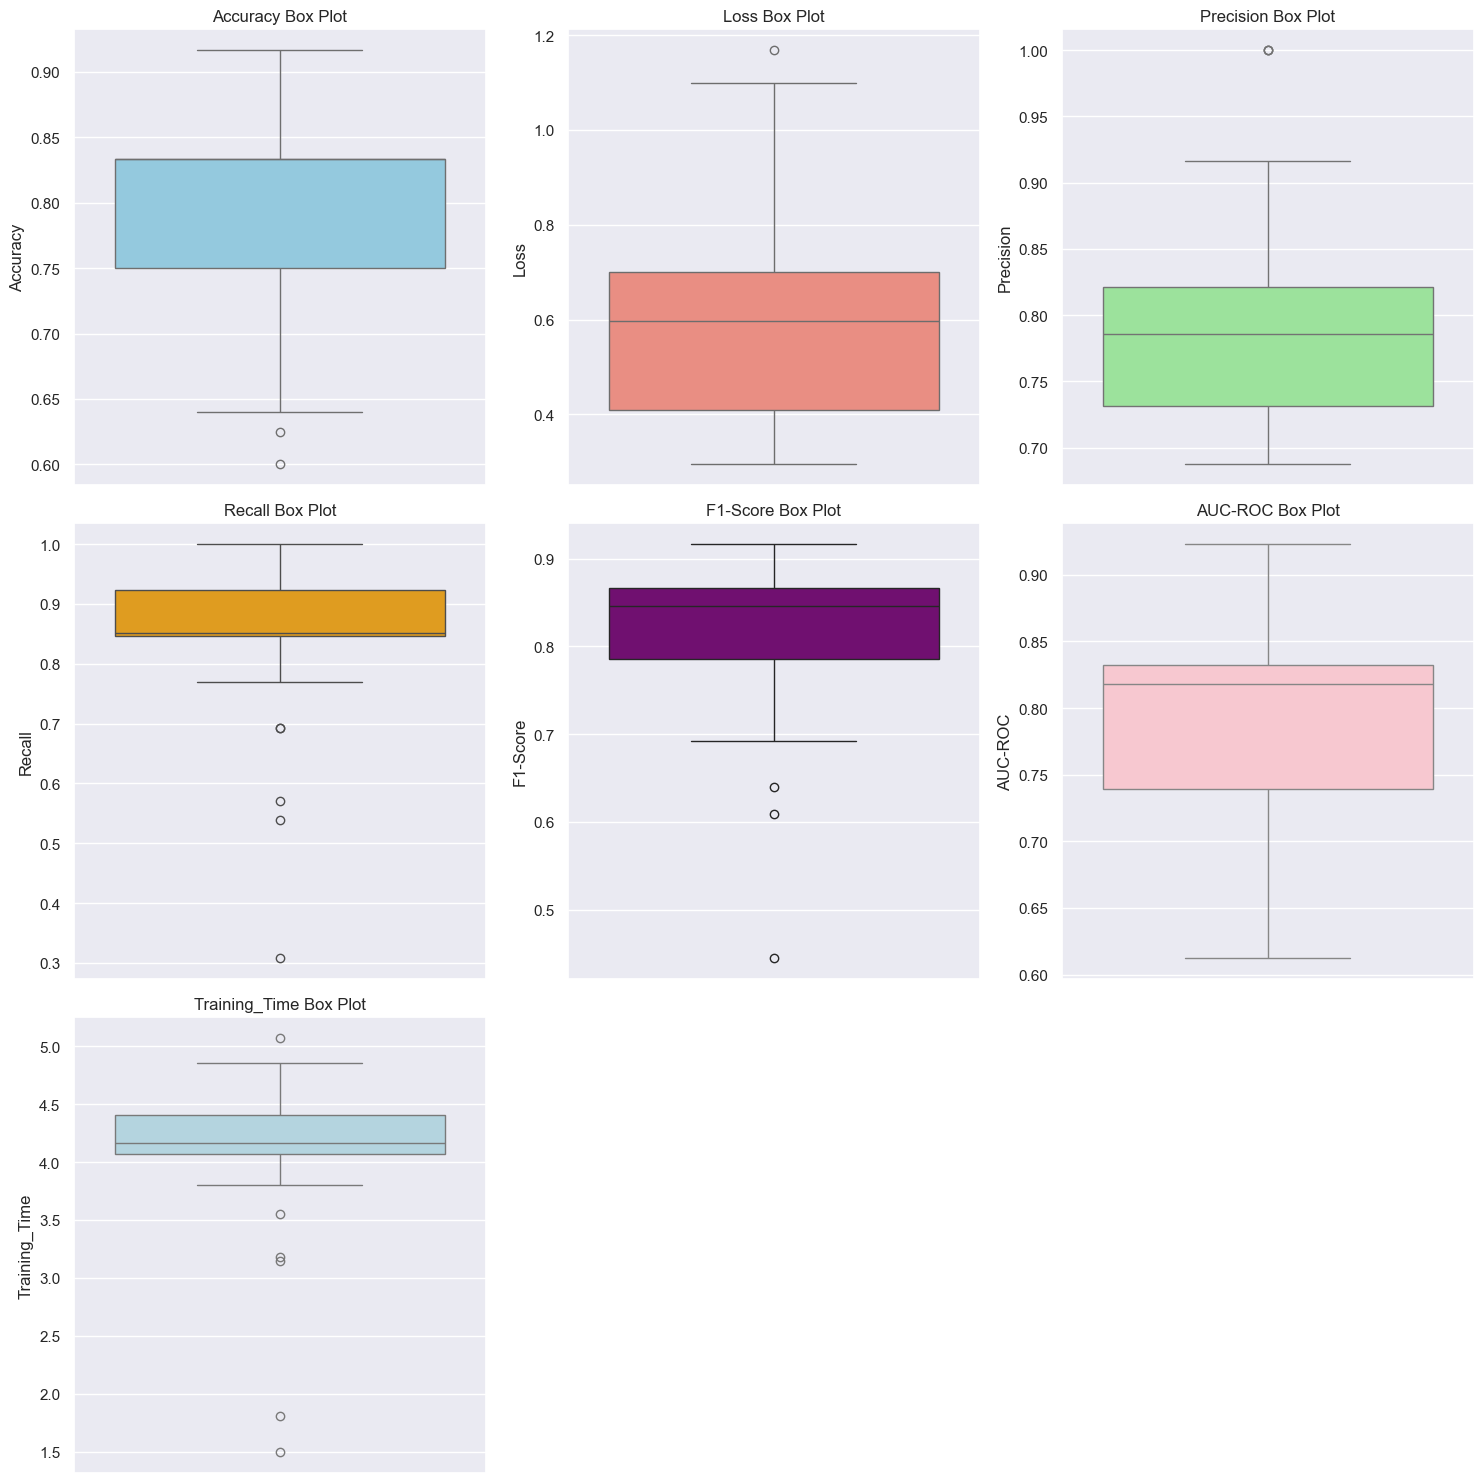

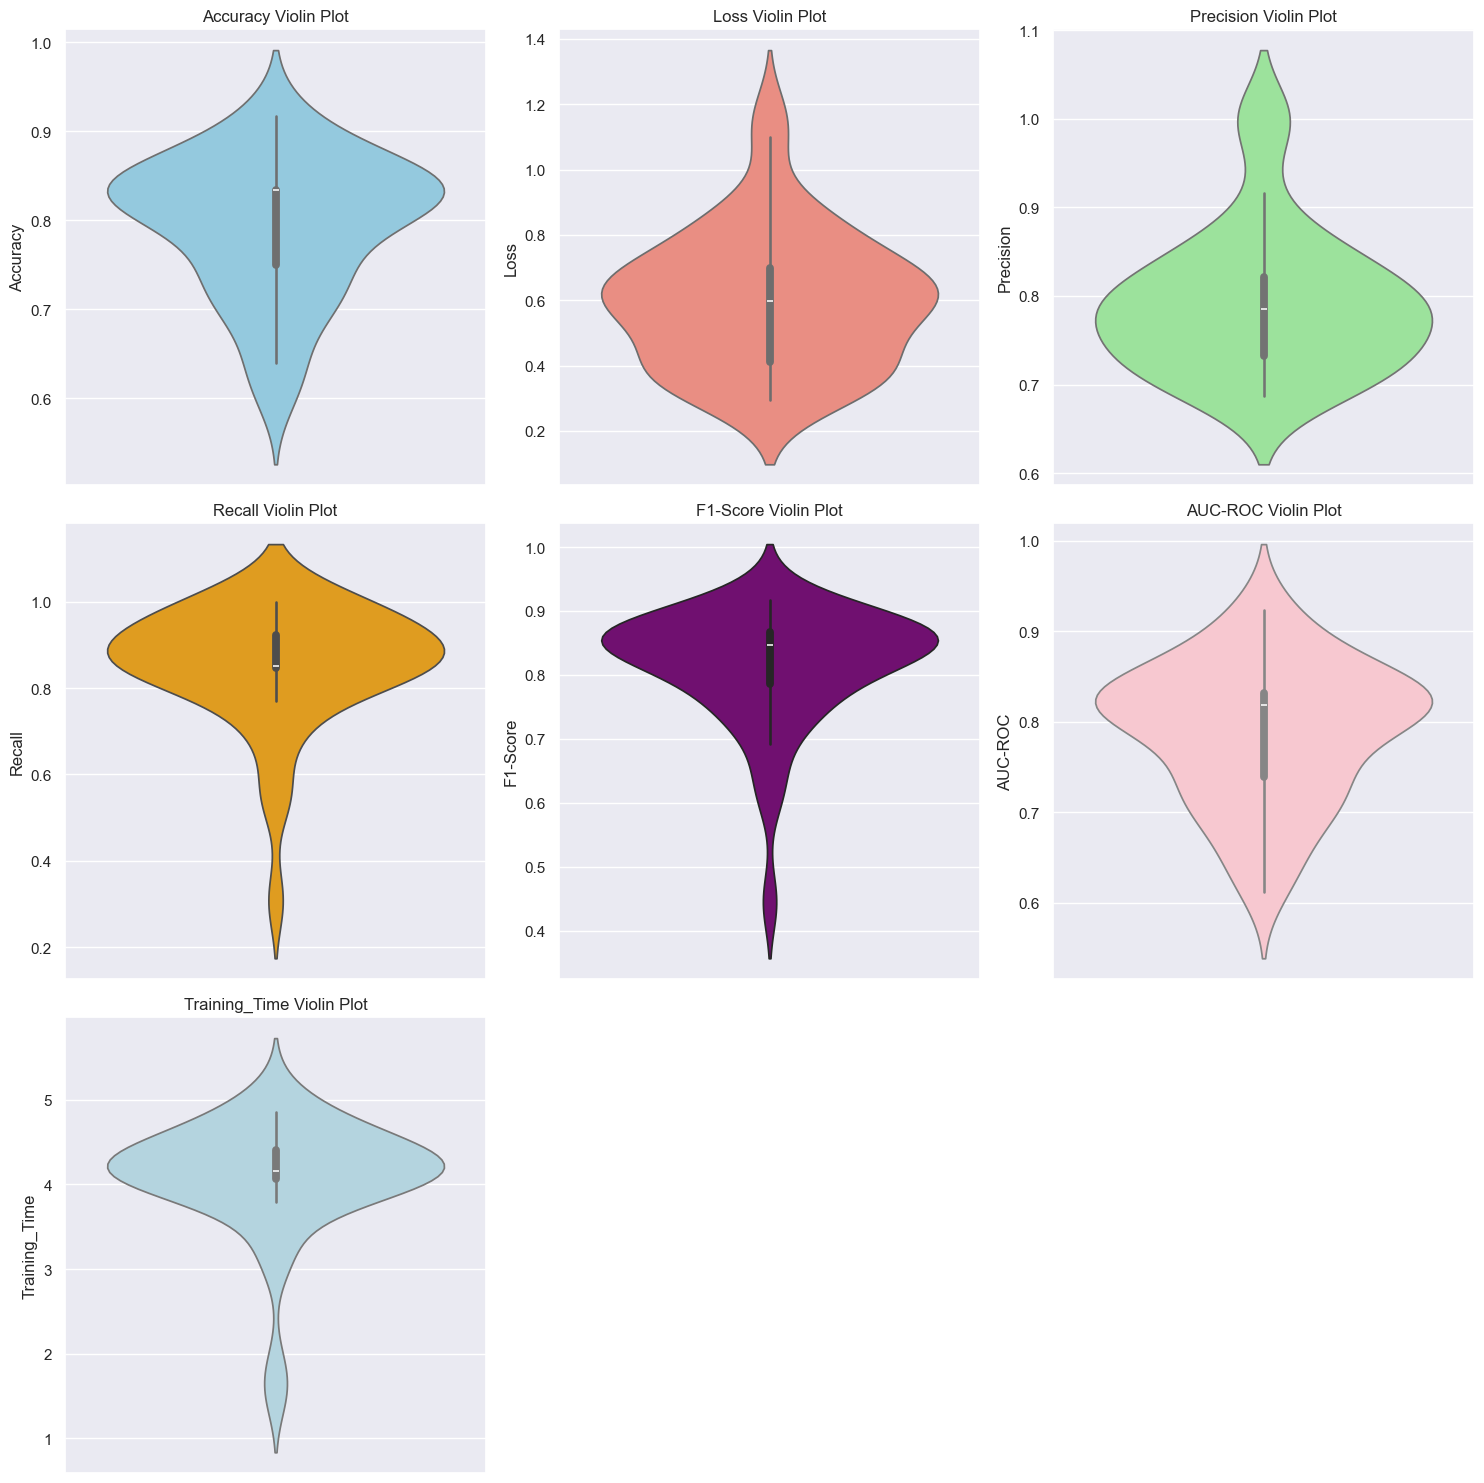

In [62]:
# Plot histograms for each metric with different colors
metrics = ['Accuracy', 'Loss', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Training_Time']
colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'purple', 'pink', 'lightblue']

plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.histplot(results_df_mlp[metric], bins=10, kde=True, color=colors[i-1])
    plt.title(f'{metric} Distribution')
    plt.xlabel(metric)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plot box plots for each metric with different colors
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=results_df_mlp, y=metric, color=colors[i-1])
    plt.title(f'{metric} Box Plot')

plt.tight_layout()
plt.show()

# Plot violin plots for each metric with different colors
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.violinplot(data=results_df_mlp, y=metric, color=colors[i-1])
    plt.title(f'{metric} Violin Plot')

plt.tight_layout()
plt.show()

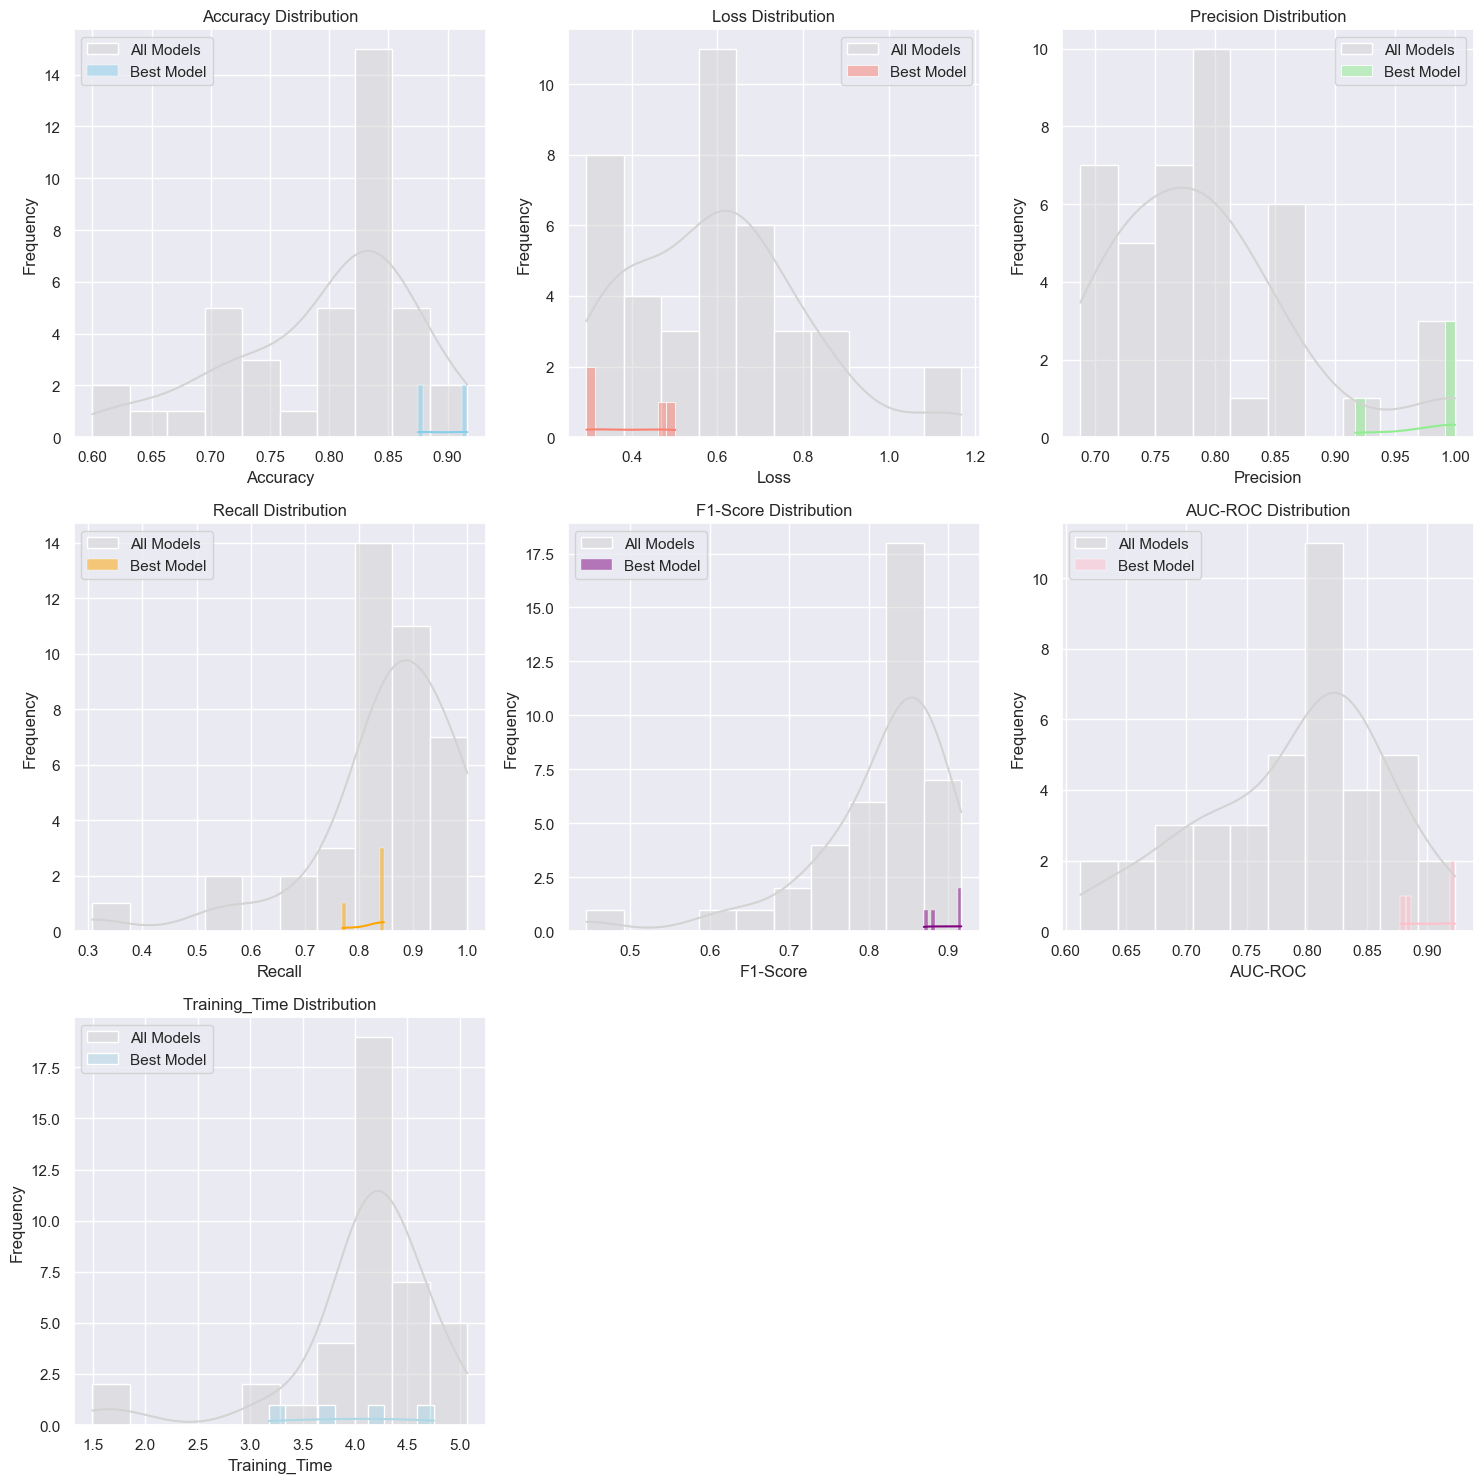

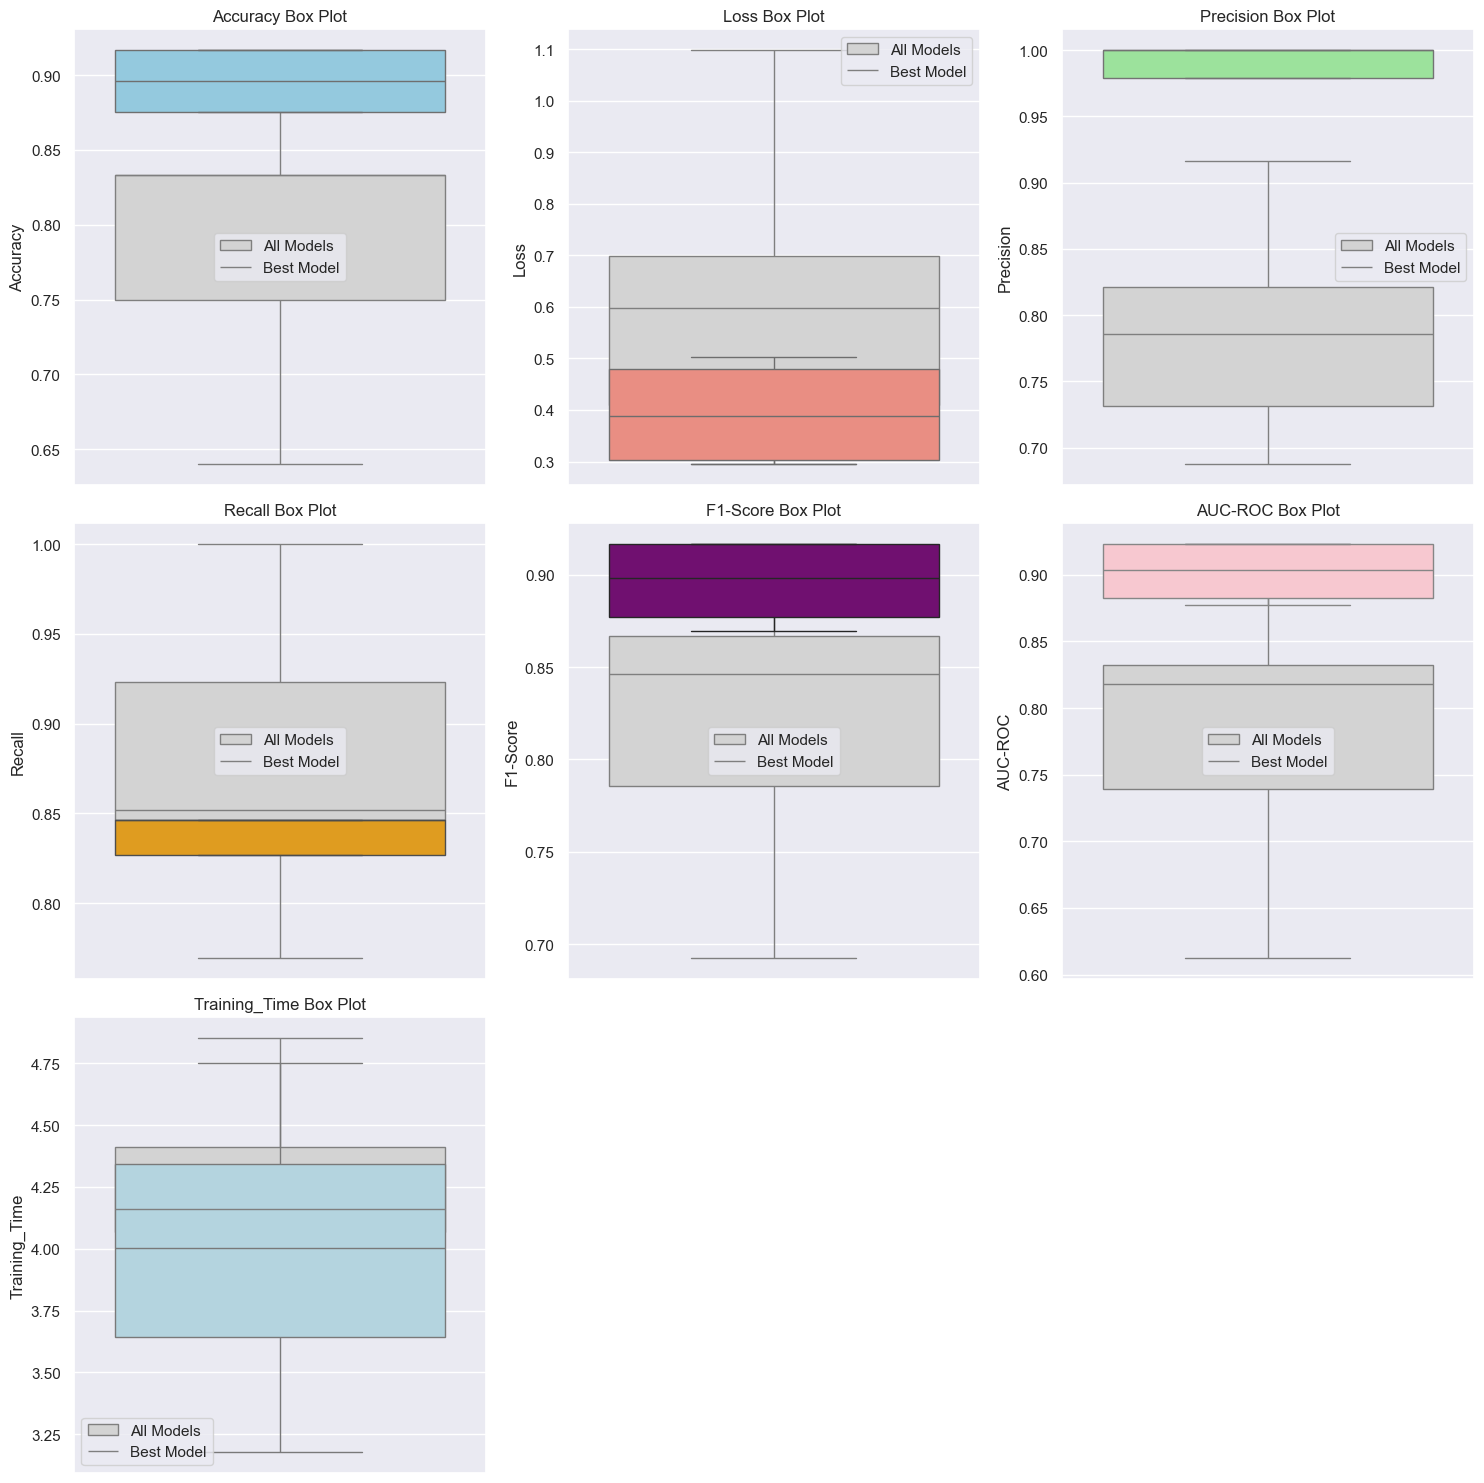

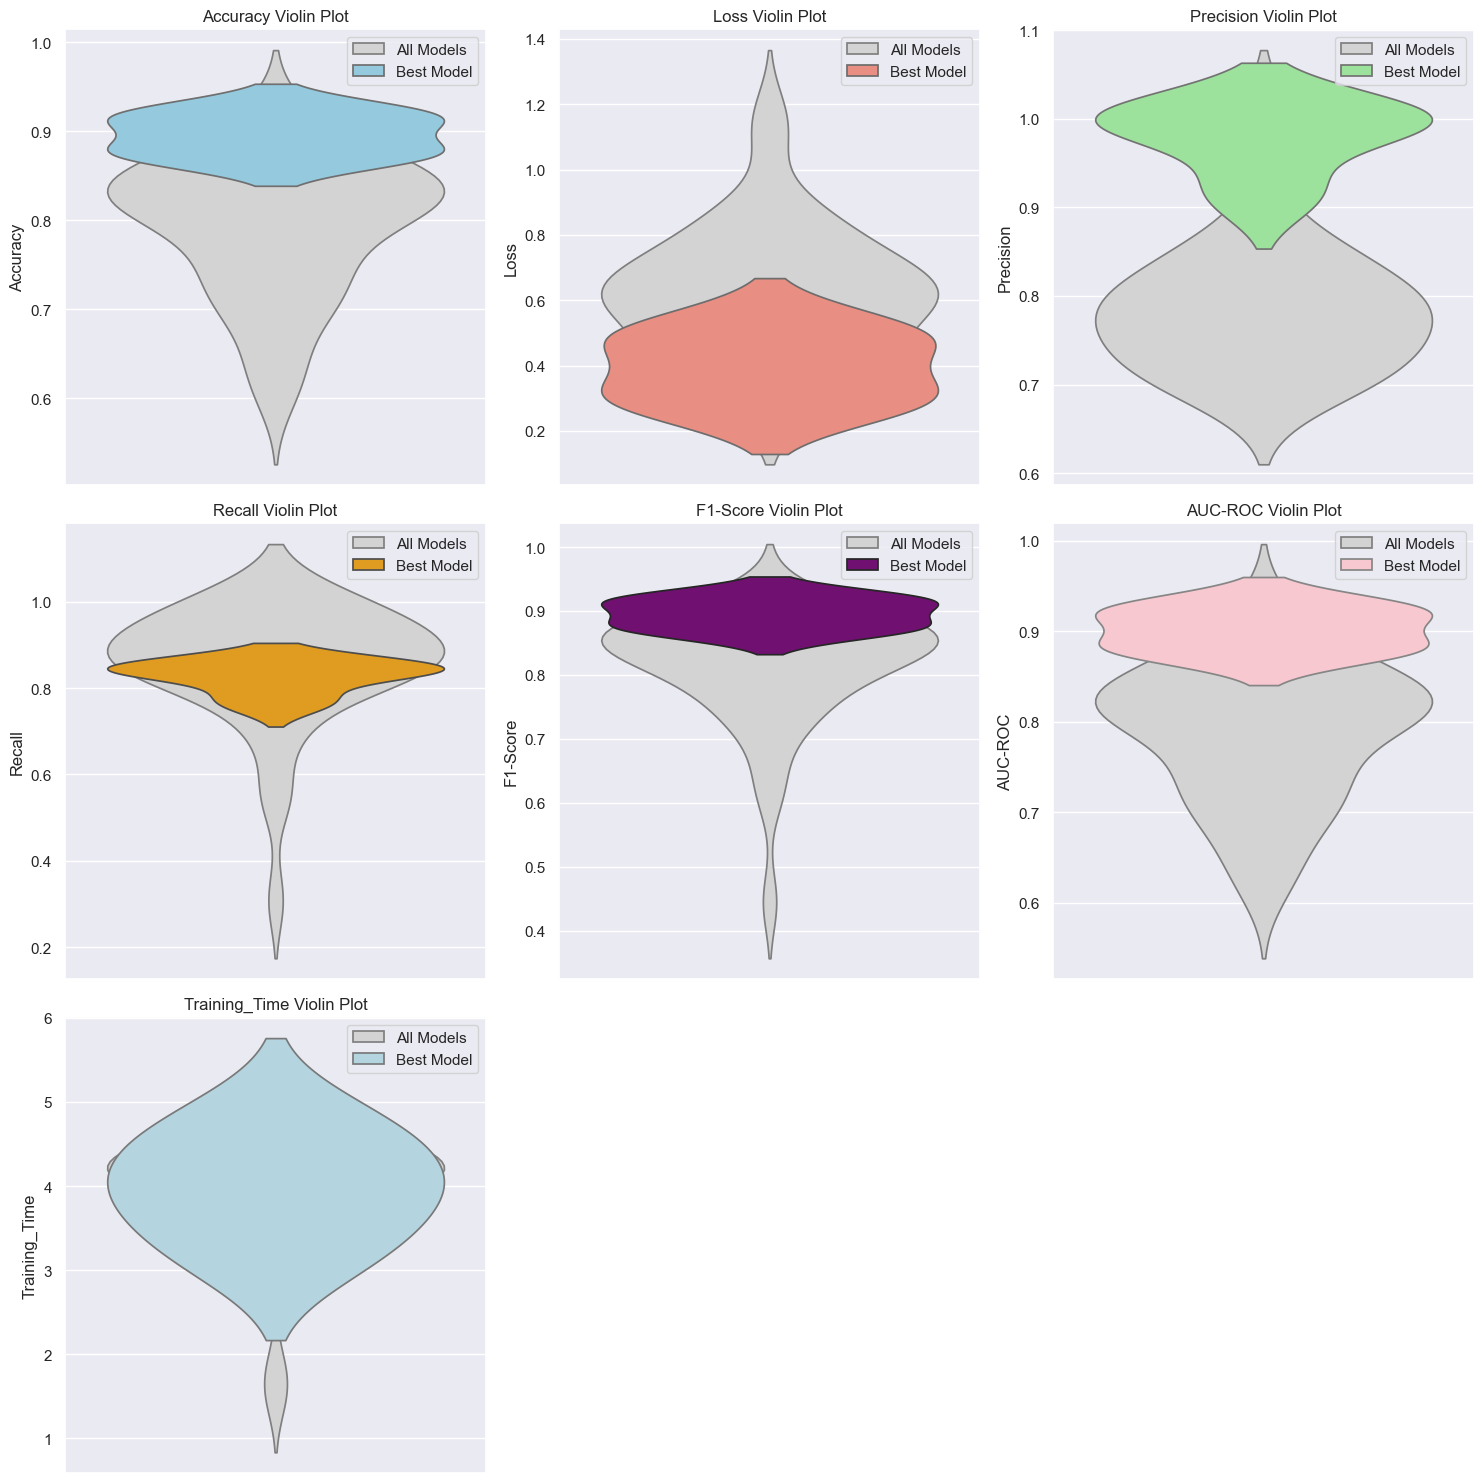

In [63]:
# Filter results_df_mlp for the best model
best_model_results_MLP = results_df_mlp[results_df_mlp['Fold'] == best_fold_index_MLP]

# Plot histograms for each metric with different colors for all models
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.histplot(results_df_mlp[metric], bins=10, kde=True, color='lightgrey', label='All Models')
    sns.histplot(best_model_results_MLP[metric], bins=10, kde=True, color=colors[i-1], label='Best Model')
    plt.title(f'{metric} Distribution')
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

# Plot box plots for each metric with different colors for all models
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=results_df_mlp, y=metric, color='lightgrey', showfliers=False)
    sns.boxplot(data=best_model_results_MLP, y=metric, color=colors[i-1], showfliers=False)
    plt.title(f'{metric} Box Plot')
    plt.ylabel(metric)
    plt.legend(['All Models', 'Best Model'])

plt.tight_layout()
plt.show()

# Plot violin plots for each metric with different colors for all models
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.violinplot(data=results_df_mlp, y=metric, color='lightgrey', inner=None, label='All Models')
    sns.violinplot(data=best_model_results_MLP, y=metric, color=colors[i-1], inner=None, label='Best Model')
    plt.title(f'{metric} Violin Plot')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()


In [64]:
# Summary statistics
print("\nSummary Statistics:")
display(results_df_mlp.describe())


Summary Statistics:


Accuracy       Loss  Precision     Recall   F1-Score    AUC-ROC  \
count  40.000000  40.000000  40.000000  40.000000  40.000000  40.000000   
mean    0.794792   0.597886   0.791854   0.853434   0.813528   0.789217   
std     0.077663   0.206019   0.080968   0.139131   0.091870   0.076643   
min     0.600000   0.294590   0.687500   0.307692   0.444444   0.612179   
25%     0.750000   0.410135   0.731818   0.846154   0.785714   0.739510   
50%     0.833333   0.597517   0.785714   0.851648   0.846154   0.818182   
75%     0.833333   0.699315   0.820913   0.923077   0.866667   0.832168   
max     0.916667   1.168558   1.000000   1.000000   0.916667   0.923077   

       Training_Time  
count      40.000000  
mean        4.083895  
std         0.689110  
min         1.494583  
25%         4.068016  
50%         4.160712  
75%         4.410366  
max         5.070005

In [65]:
display(results_df_mlp)

Fold Early_Stopping  Accuracy      Loss  Precision    Recall  F1-Score  \
0     1      (5, True)  0.800000  0.816213   0.800000  0.857143  0.827586   
1     1    (10, False)  0.640000  0.881500   0.727273  0.571429  0.640000   
2     2      (5, True)  0.720000  0.715827   0.687500  0.846154  0.758621   
3     2    (10, False)  0.840000  0.644647   0.800000  0.923077  0.857143   
4     3      (5, True)  0.750000  0.852999   0.733333  0.846154  0.785714   
5     3    (10, False)  0.750000  0.853780   0.733333  0.846154  0.785714   
6     4      (5, True)  0.875000  0.502043   0.916667  0.846154  0.880000   
7     4    (10, False)  0.916667  0.473379   1.000000  0.846154  0.916667   
8     5      (5, True)  0.875000  0.632414   0.857143  0.923077  0.888889   
9     5    (10, False)  0.791667  0.638045   0.785714  0.846154  0.814815   
10    6      (5, True)  0.833333  0.684131   0.800000  0.923077  0.857143   
11    6    (10, False)  0.833333  0.579437   0.800000  0.923077  0.857143   
12    7      (5, True)  0.833333  0.547216   0.800000  0.923077  0.857143   
13    7    (10, False)  0.833333  0.563933   0.764706  1.000000  0.866667   
14    8      (5, True)  0.708333  1.168558   0.750000  0.692308  0.720000   
15    8    (10, False)  0.708333  1.098631   0.714286  0.769231  0.740741   
16    9      (5, True)  0.833333  0.641150   0.846154  0.846154  0.846154   
17    9    (10, False)  0.833333  0.682535   0.846154  0.846154  0.846154   
18   10      (5, True)  0.791667  0.583753   0.722222  1.000000  0.838710   
19   10    (10, False)  0.833333  0.606728   0.764706  1.000000  0.866667   
20    1      (5, True)  0.840000  0.602384   0.812500  0.928571  0.866667   
21    1    (10, False)  0.760000  0.592650   0.750000  0.857143  0.800000   
22    2      (5, True)  0.600000  0.637541   0.800000  0.307692  0.444444   
23    2    (10, False)  0.800000  0.361482   0.785714  0.846154  0.814815   
24    3      (5, True)  0.708333  0.693811   0.714286  0.769231  0.740741   
25    3    (10, False)  0.708333  0.728350   0.687500  0.846154  0.758621   
26    4      (5, True)  0.916667  0.305141   1.000000  0.846154  0.916667   
27    4    (10, False)  0.875000  0.294590   1.000000  0.769231  0.869565   
28    5      (5, True)  0.875000  0.370843   0.857143  0.923077  0.888889   
29    5    (10, False)  0.833333  0.391294   0.800000  0.923077  0.857143   
30    6      (5, True)  0.750000  0.558285   0.705882  0.923077  0.800000   
31    6    (10, False)  0.833333  0.401570   0.800000  0.923077  0.857143   
32    7      (5, True)  0.833333  0.334180   0.764706  1.000000  0.866667   
33    7    (10, False)  0.833333  0.333372   0.764706  1.000000  0.866667   
34    8      (5, True)  0.625000  0.793901   0.700000  0.538462  0.608696   
35    8    (10, False)  0.666667  0.746290   0.692308  0.692308  0.692308   
36    9      (5, True)  0.833333  0.412991   0.846154  0.846154  0.846154   
37    9    (10, False)  0.875000  0.450605   0.857143  0.923077  0.888889   
38   10      (5, True)  0.791667  0.373245   0.722222  1.000000  0.838710   
39   10    (10, False)  0.833333  0.365992   0.764706  1.000000  0.866667   

     AUC-ROC  Training_Time  
0   0.792208       5.070005  
1   0.649351       4.587305  
2   0.714744       4.324293  
3   0.836538       4.183924  
4   0.741259       4.852393  
5   0.741259       4.648928  
6   0.877622       4.751268  
7   0.923077       4.208019  
8   0.870629       4.820812  
9   0.786713       4.132800  
10  0.825175       4.123924  
11  0.825175       4.056761  
12  0.825175       4.099931  
13  0.818182       3.821584  
14  0.709790       4.182666  
15  0.702797       4.071768  
16  0.832168       4.126619  
17  0.832168       4.120907  
18  0.772727       4.487571  
19  0.818182       4.352481  
20  0.827922       4.324342  
21  0.746753       4.099306  
22  0.612179       1.494583  
23  0.798077       4.236131  
24  0.702797       4.074344  
25  0.695804       3.844572  
26  0.923077       3.176535  
27  0

2.  SVM Architecture Model

In [66]:
# Initialize necessary variables
best_accuracy_SVM = 0.0
best_auc_roc_SVM = 0.0
best_f1_score_SVM = 0.0
best_loss_SVM = float('inf')
best_precision_SVM = 0.0
best_training_time_SVM = float('inf')
best_model_SVM = None
best_confusion_matrix_SVM = None
best_recall_SVM = 0.0
fold_histories_SVM = {}
accuracy_list = []
loss_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []
confusion_matrices = [] 
training_time_list = []
fold_histories_SVM = {}

# Initialize DataFrame to store results
results_df_svm = pd.DataFrame(columns=['Fold', 'Early_Stopping', 'Accuracy', 'Loss', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Training_Time'])

In [104]:
# Perform grid search
for fold_index, (train_index, val_index) in enumerate(kfold.split(x_train, y_train), 1):
    print(f"\nFold {fold_index}:")

    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Apply SMOTE for data augmentation
    smote = SMOTE(random_state=42)
    x_train_fold_smote, y_train_fold_smote = smote.fit_resample(x_train_fold, y_train_fold)

    accuracies_SVM = []
    losses_SVM = []
    precisions_SVM = []
    recalls_SVM = []
    f1_scores_SVM = []
    auc_rocs_SVM = []
    training_times_SVM = []

    for early_stopping_param in early_stopping_params:
        # Define your model architecture as a logistic Support Vector Machine
        model_SVM = Sequential([
            Dense(1, activation='linear', input_shape=(x_train.shape[1],), kernel_regularizer=l2(0.001))  # Linear layer
        ])

        # Compile the model with binary cross-entropy loss
        model_SVM.compile(optimizer='Adam', loss=tf.keras.losses.Hinge(), metrics=['accuracy'])

        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_param[0], restore_best_weights=early_stopping_param[1])

        # Train the model and measure training time
        start_time = time.time()
        history = model_SVM.fit(x_train_fold_smote, y_train_fold_smote, epochs=75, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)
        training_time = time.time() - start_time
        training_times_SVM.append(training_time)

        # Evaluate the model on validation data
        eval_loss, accuracy_SVM = model_SVM.evaluate(x_val_fold, y_val_fold)
        accuracies_SVM.append(accuracy_SVM)
        losses_SVM.append(eval_loss)

        # Append results to the DataFrame
        results_df_svm = pd.concat([results_df_svm, pd.DataFrame({
            'Fold': [fold_index],
            'Early_Stopping': [early_stopping_param],
            'Accuracy': [accuracy_SVM],
            'Loss': [eval_loss],
            'Precision': [precision],
            'Recall': [recall],
            'F1-Score': [f1],
            'AUC-ROC': [auc],
            'Training_Time': [training_time]
        })], ignore_index=True)

        print(f"Early Stopping: {early_stopping_param}, Accuracy = {accuracy_MLP:.4f}, Loss = {eval_loss:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1-Score = {f1:.4f}, AUC-ROC = {auc:.4f}, Training Time = {training_time:.2f} seconds")

        # Update lists for histograms
        accuracy_list.extend(accuracies_SVM)
        loss_list.extend(losses_SVM)
        precision_list.extend(precisions_SVM)
        recall_list.extend(recalls_SVM)
        f1_list.extend(f1_scores_SVM)
        auc_list.extend(auc_rocs_SVM)
        training_time_list.extend(training_times_SVM)

        # Calculate mean accuracy and loss
        mean_accuracy_SVM = np.mean(accuracies_SVM)
        mean_loss_SVM = np.mean(losses_SVM)

        # Store training history
        fold_histories_SVM[fold_index] = history

        # Update best parameters if the mean accuracy is higher
        if mean_accuracy_SVM > best_accuracy_SVM:
            best_accuracy_SVM = mean_accuracy_SVM
            best_model_SVM = model_SVM
            # best_confusion_matrix_SVM = confusion_matrix(y_val_fold, y_pred)
            best_precision_SVM = precision
            best_recall_SVN = recall
            best_f1_score_SVM = f1
            best_auc_roc_SVM = auc
            best_recall_SVM = recall
            best_loss_SVM = eval_loss
            best_training_time_SVM = training_time

# Print best parameters and mean accuracy
print("Best Mean Accuracy:", best_accuracy_SVM)

# Save the best trained model to disk
if best_model_SVM is not None:
    best_model_SVM.save('saved_model/SVM_Model.h5')

# Find the best model based on validation accuracy
best_fold_index_SVM = results_df_svm.loc[results_df_svm['Accuracy'].idxmax()]['Fold']
best_model_history_SVM = fold_histories_SVM[best_fold_index_SVM]


Fold 1:
1/1 [==============================] - 0s 21ms/step - loss: 0.6543 - accuracy: 0.6800
Early Stopping: (5, True), Accuracy = 0.8333, Loss = 0.6543, Precision = 0.7647, Recall = 1.0000, F1-Score = 0.8667, AUC-ROC = 0.8182, Training Time = 3.43 seconds


C:\Users\piyus\AppData\Local\Temp\ipykernel_17976\828994507.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df_svm = pd.concat([results_df_svm, pd.DataFrame({


1/1 [==============================] - 0s 22ms/step - loss: 0.8608 - accuracy: 0.6000
Early Stopping: (10, False), Accuracy = 0.8333, Loss = 0.8608, Precision = 0.7647, Recall = 1.0000, F1-Score = 0.8667, AUC-ROC = 0.8182, Training Time = 3.35 seconds

Fold 2:
1/1 [==============================] - 0s 22ms/step - loss: 0.3850 - accuracy: 0.8400
Early Stopping: (5, True), Accuracy = 0.8333, Loss = 0.3850, Precision = 0.7647, Recall = 1.0000, F1-Score = 0.8667, AUC-ROC = 0.8182, Training Time = 3.11 seconds
1/1 [==============================] - 0s 28ms/step - loss: 0.7136 - accuracy: 0.6800
Early Stopping: (10, False), Accuracy = 0.8333, Loss = 0.7136, Precision = 0.7647, Recall = 1.0000, F1-Score = 0.8667, AUC-ROC = 0.8182, Training Time = 3.36 seconds

Fold 3:
1/1 [==============================] - 0s 26ms/step - loss: 1.0330 - accuracy: 0.5417
Early Stopping: (5, True), Accuracy = 0.8333, Loss = 1.0330, Precision = 0.7647, Recall = 1.0000, F1-Score = 0.8667, AUC-ROC = 0.8182, Trainin

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


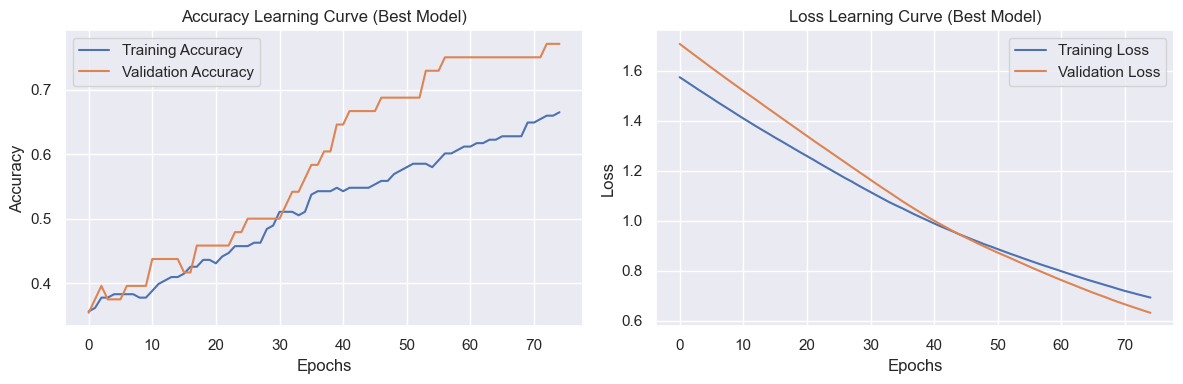

In [105]:
# Plot learning curves for the best model
plt.figure(figsize=(12, 4))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(best_model_history_SVM.history['accuracy'], label='Training Accuracy')
plt.plot(best_model_history_SVM.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Learning Curve (Best Model)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(best_model_history_SVM.history['loss'], label='Training Loss')
plt.plot(best_model_history_SVM.history['val_loss'], label='Validation Loss')
plt.title('Loss Learning Curve (Best Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

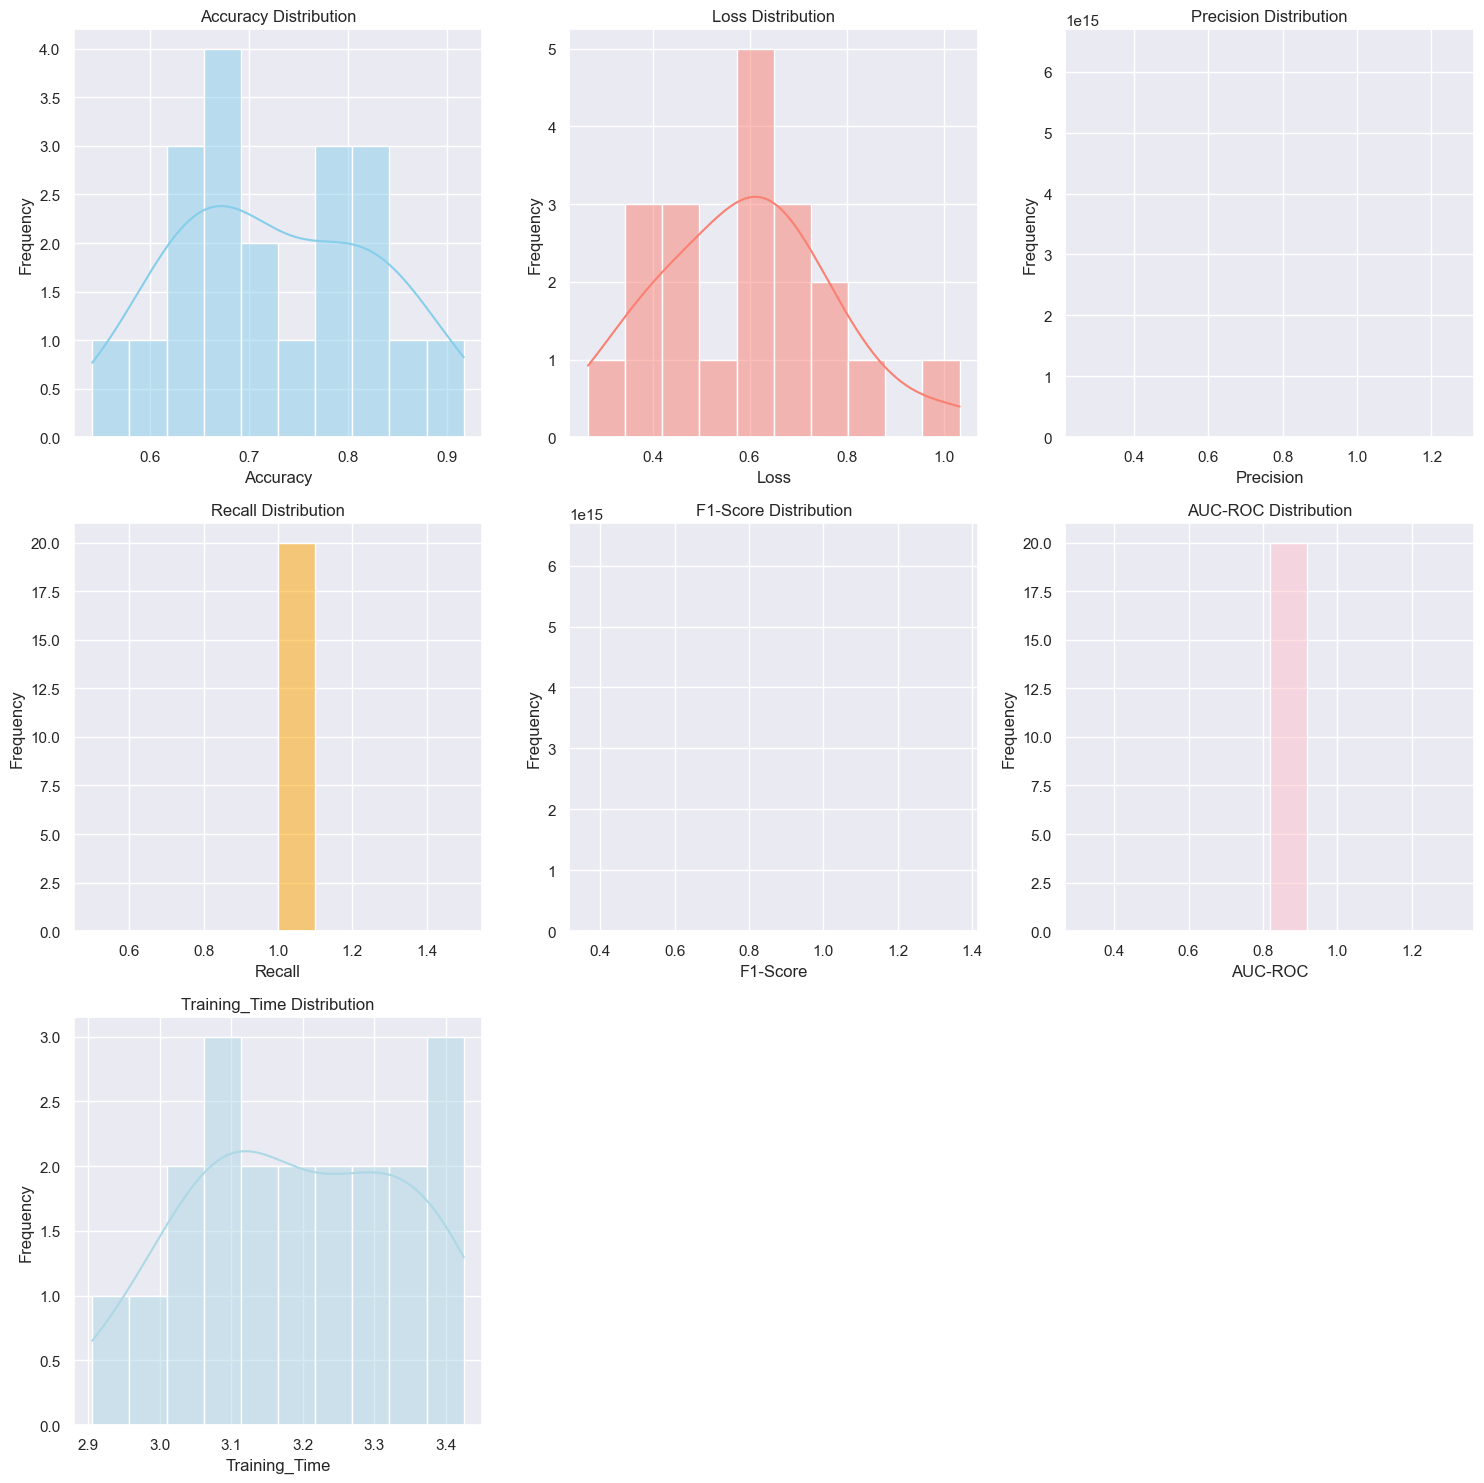

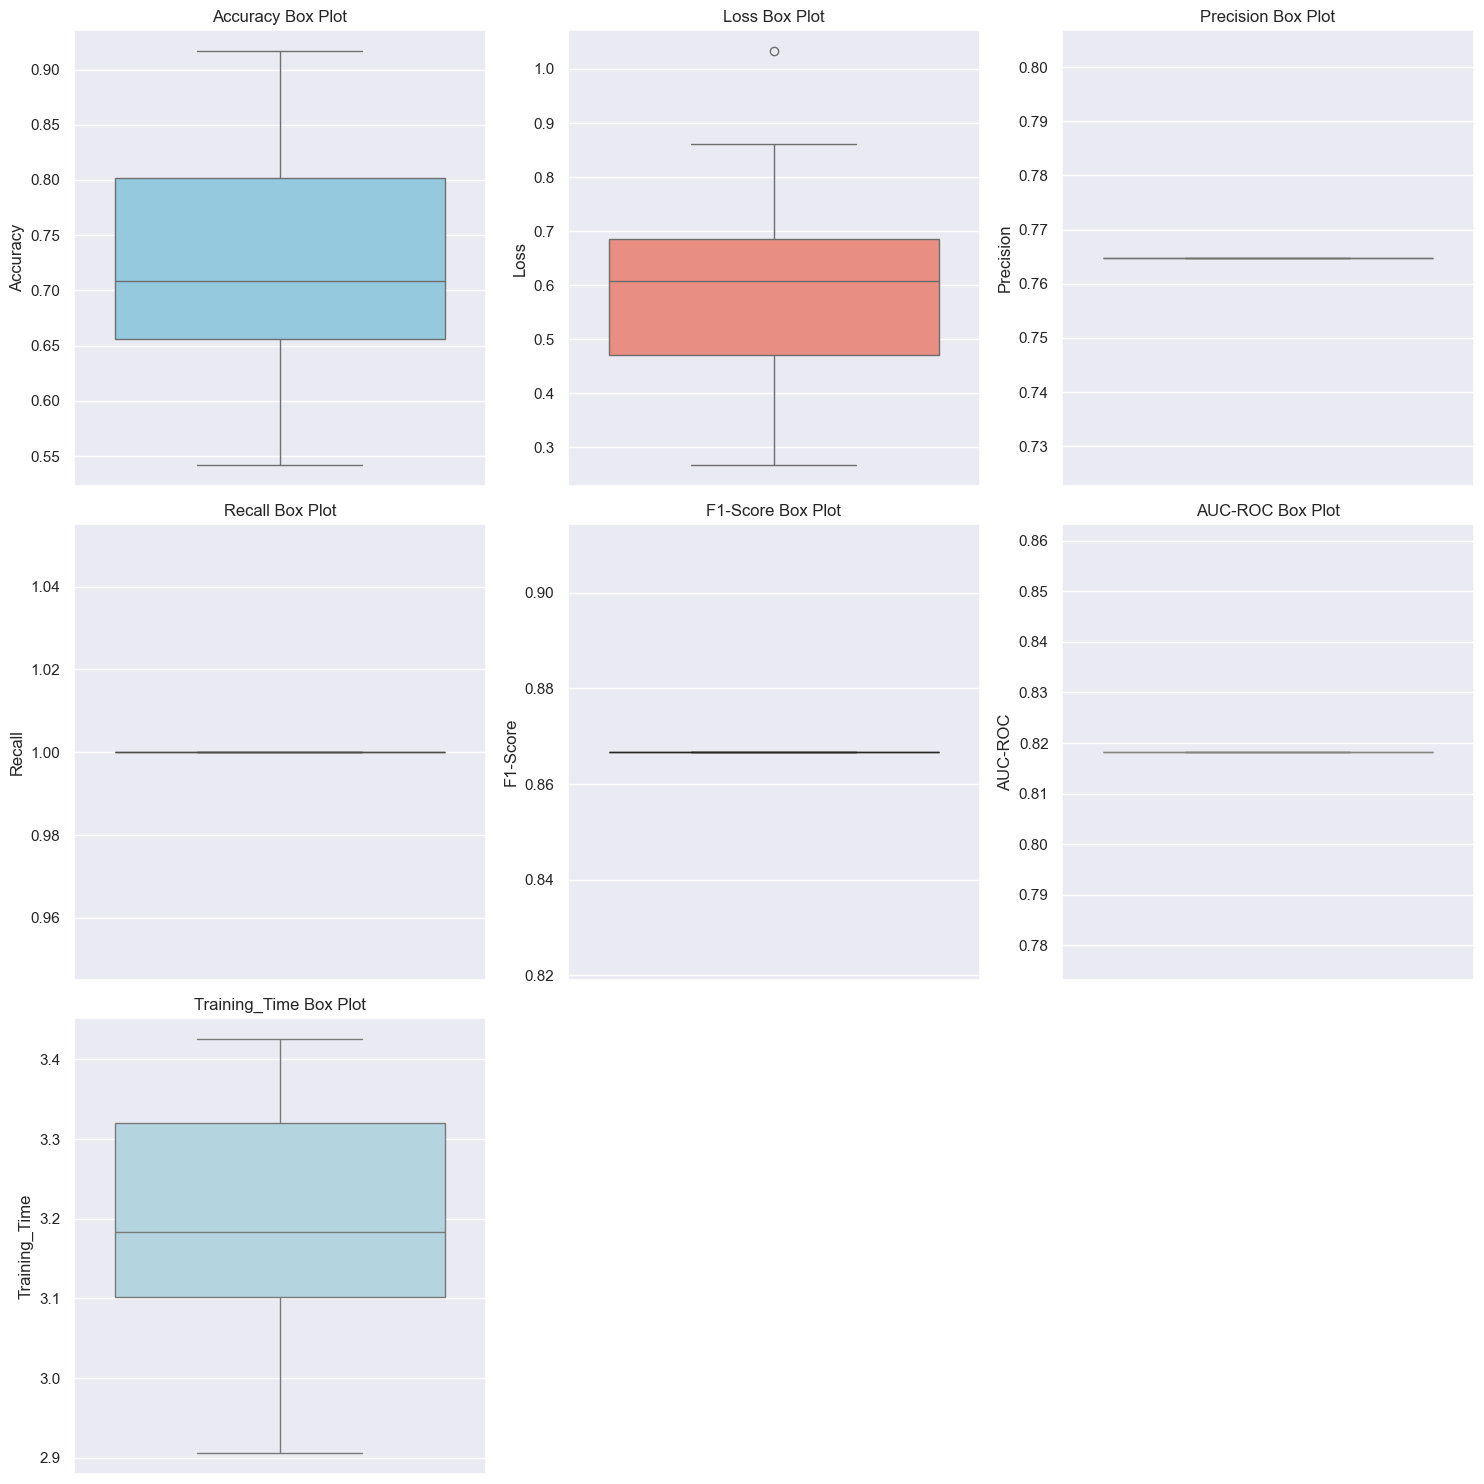

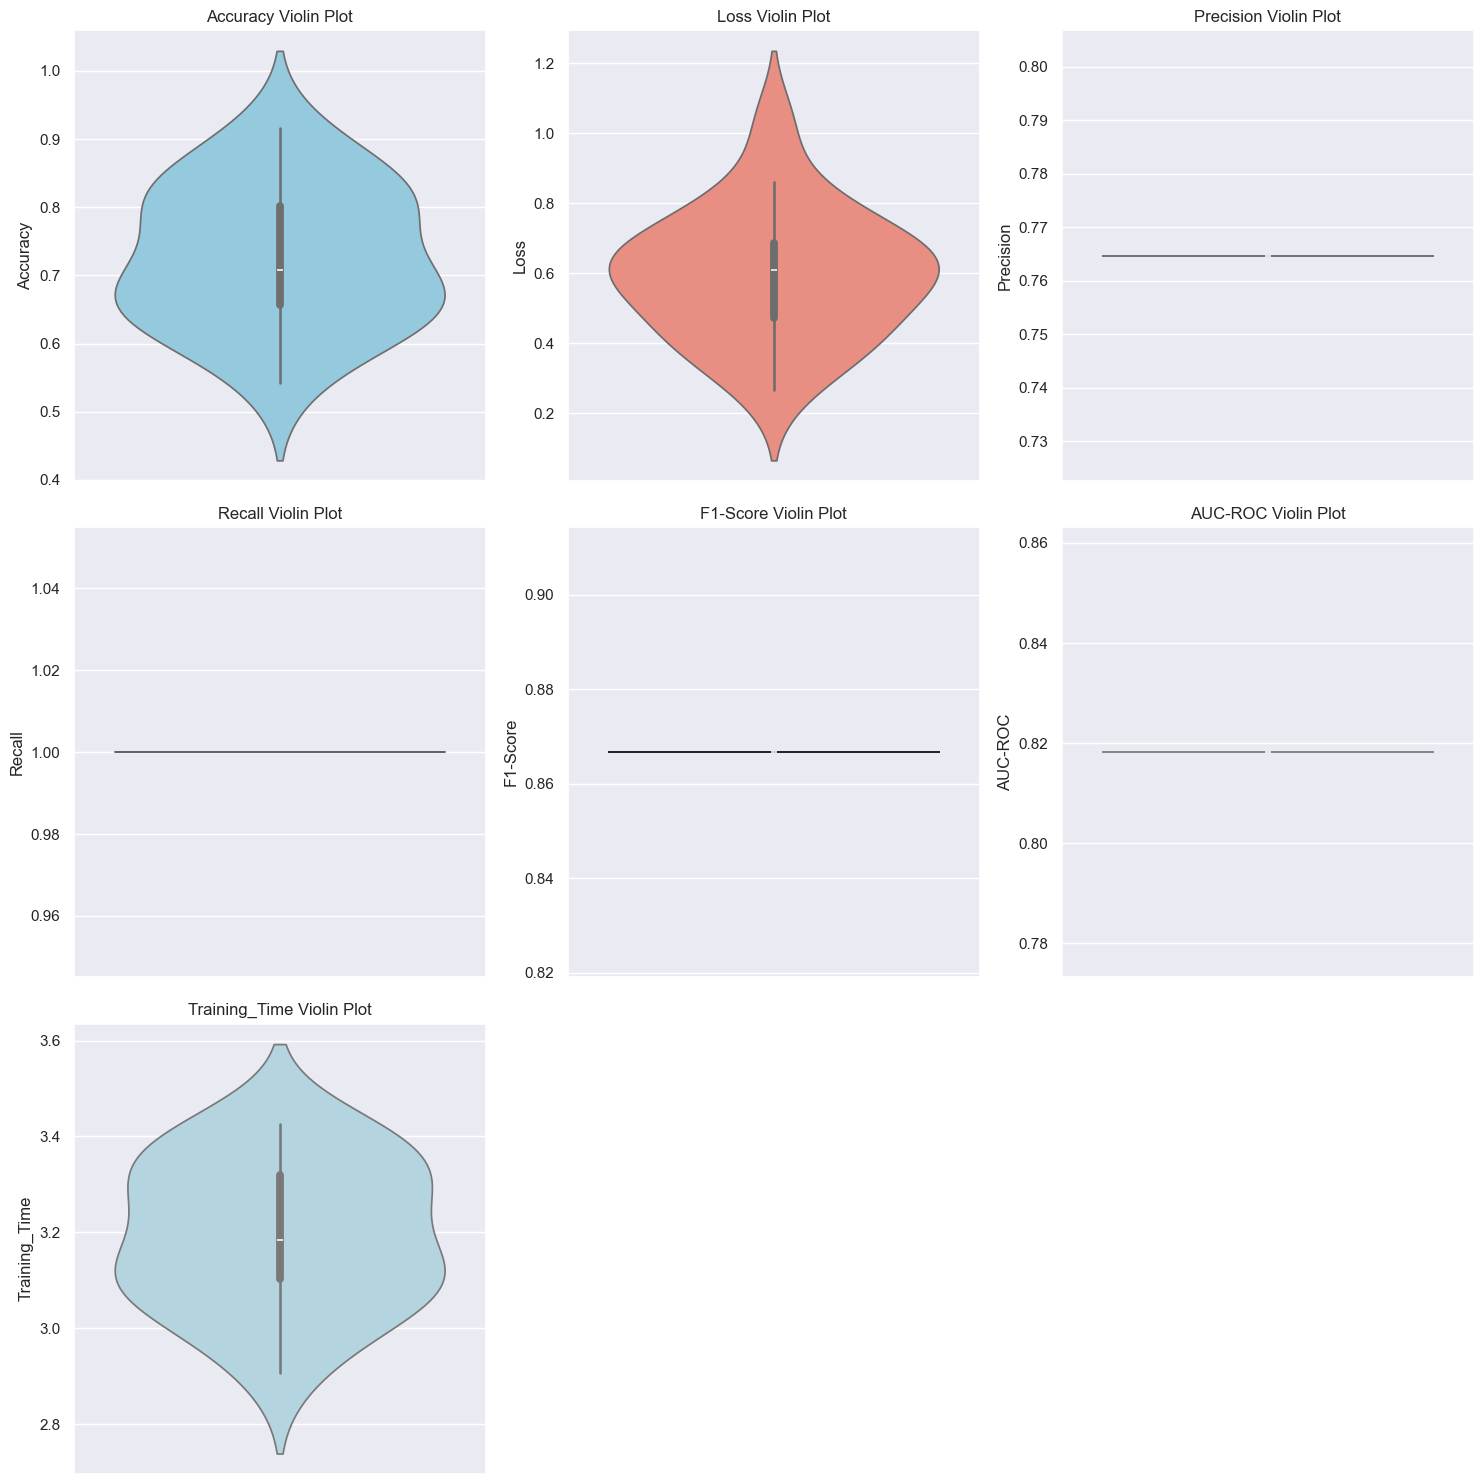

In [106]:
# Plot histograms for each metric with different colors
metrics = ['Accuracy', 'Loss', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Training_Time']
colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'purple', 'pink', 'lightblue']

plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.histplot(results_df_svm[metric], bins=10, kde=True, color=colors[i-1])
    plt.title(f'{metric} Distribution')
    plt.xlabel(metric)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plot box plots for each metric with different colors
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=results_df_svm, y=metric, color=colors[i-1])
    plt.title(f'{metric} Box Plot')

plt.tight_layout()
plt.show()

# Plot violin plots for each metric with different colors
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.violinplot(data=results_df_svm, y=metric, color=colors[i-1])
    plt.title(f'{metric} Violin Plot')

plt.tight_layout()
plt.show()

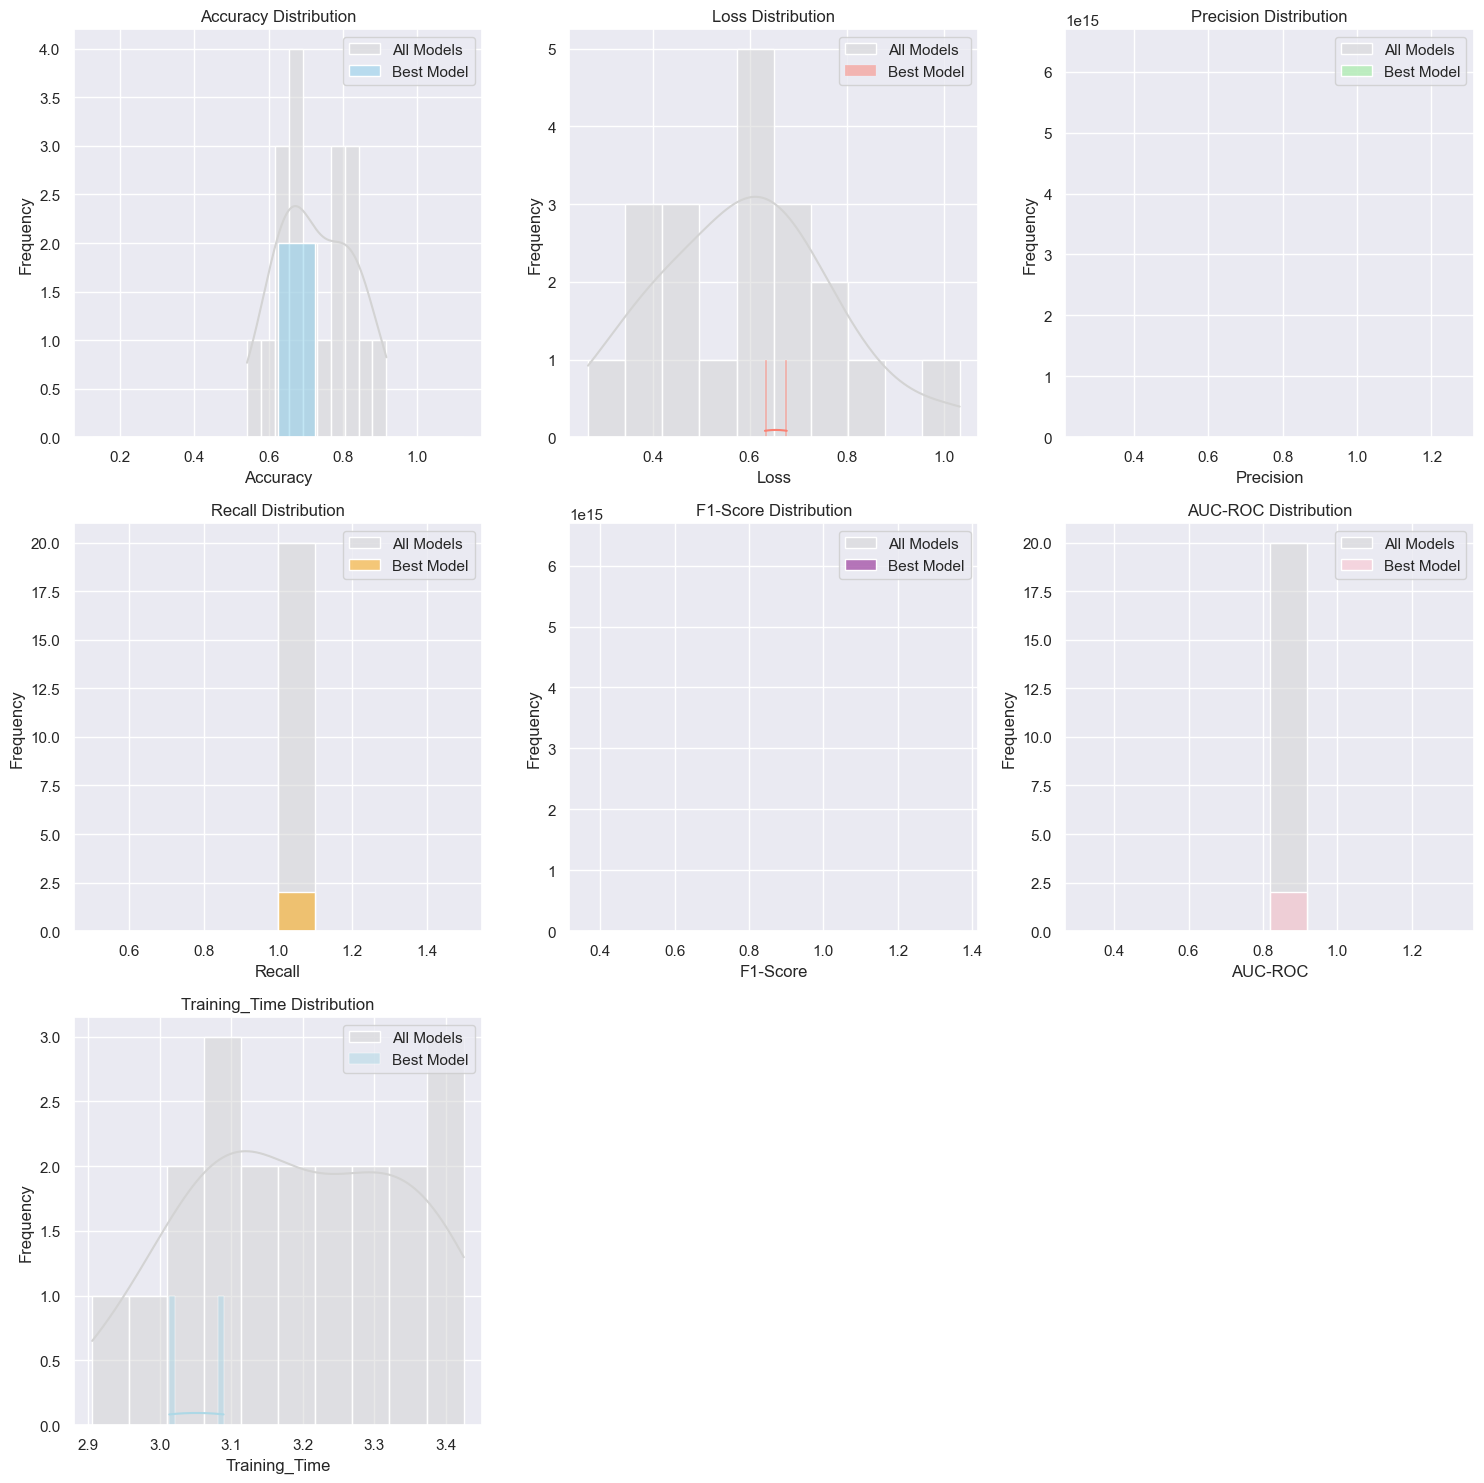

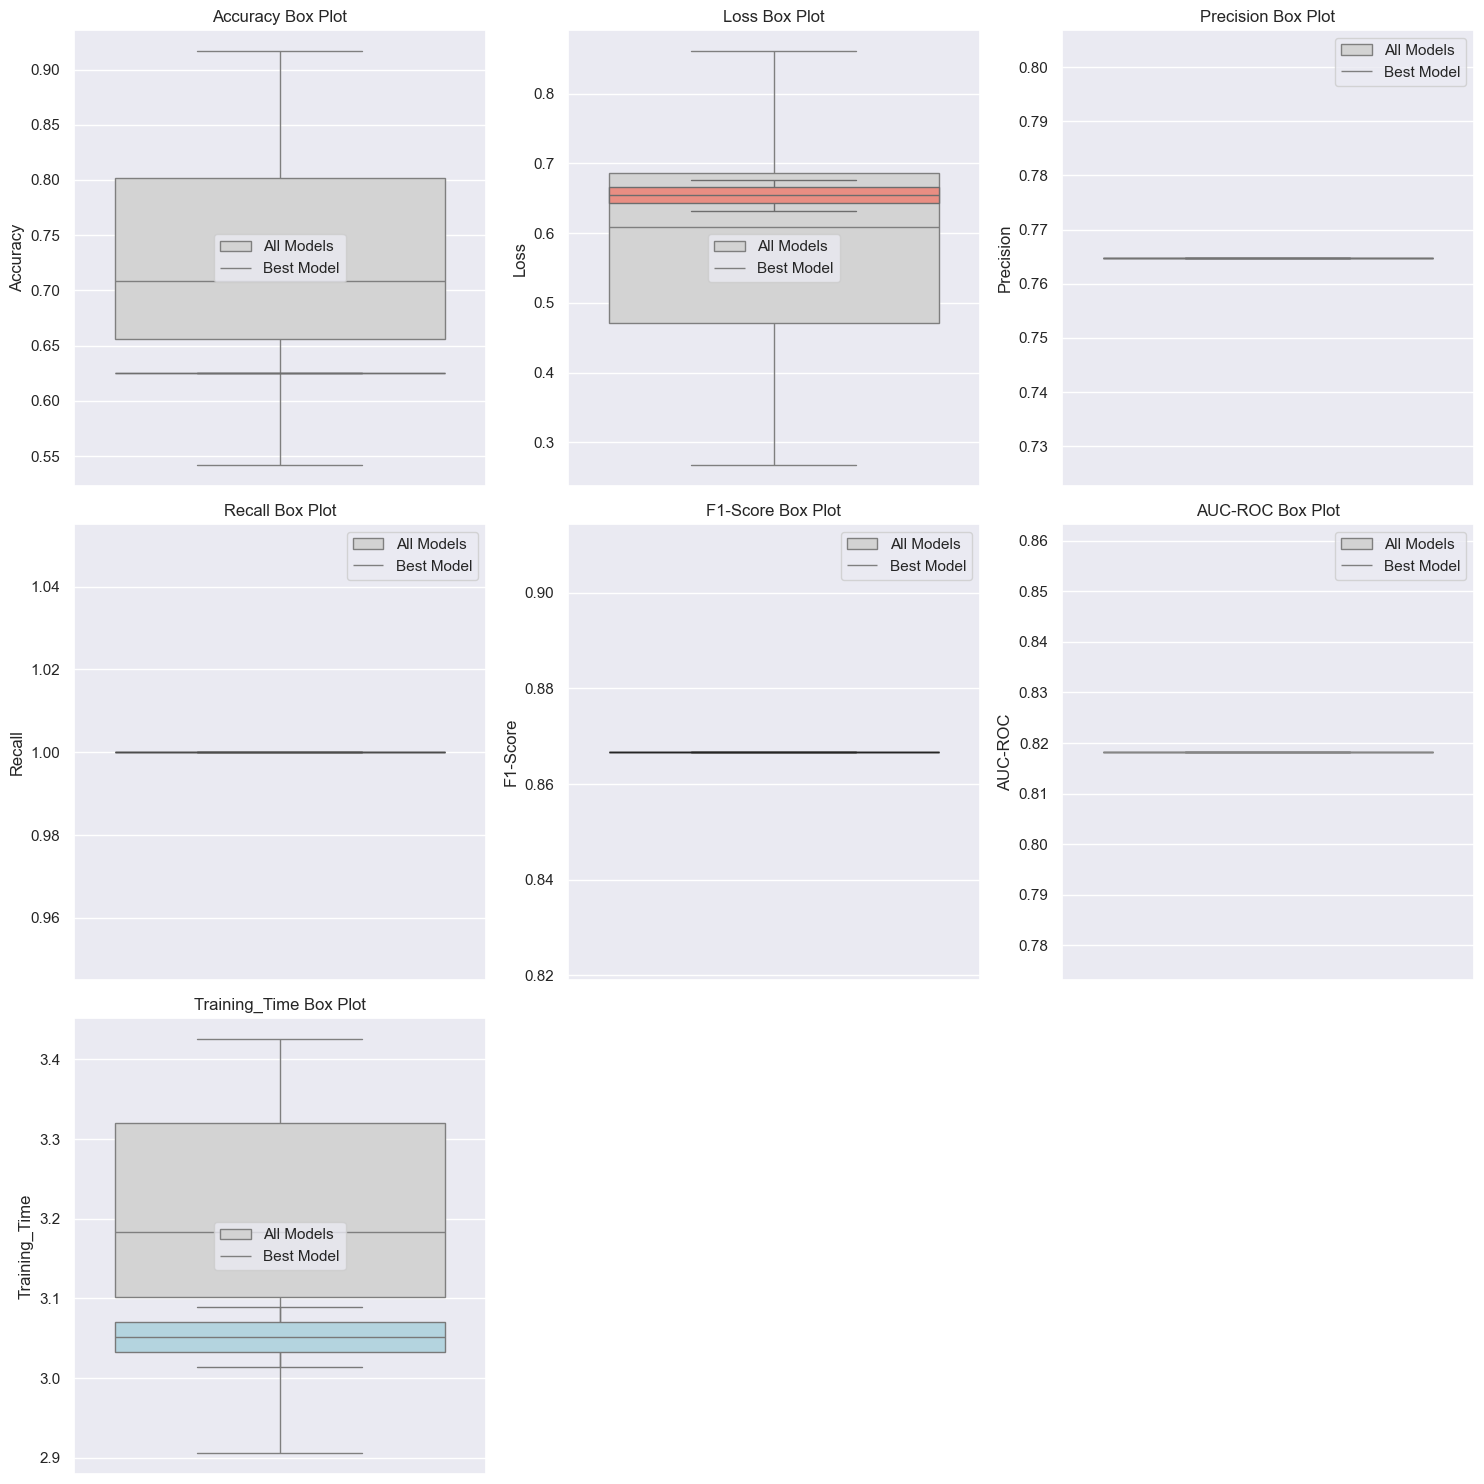

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


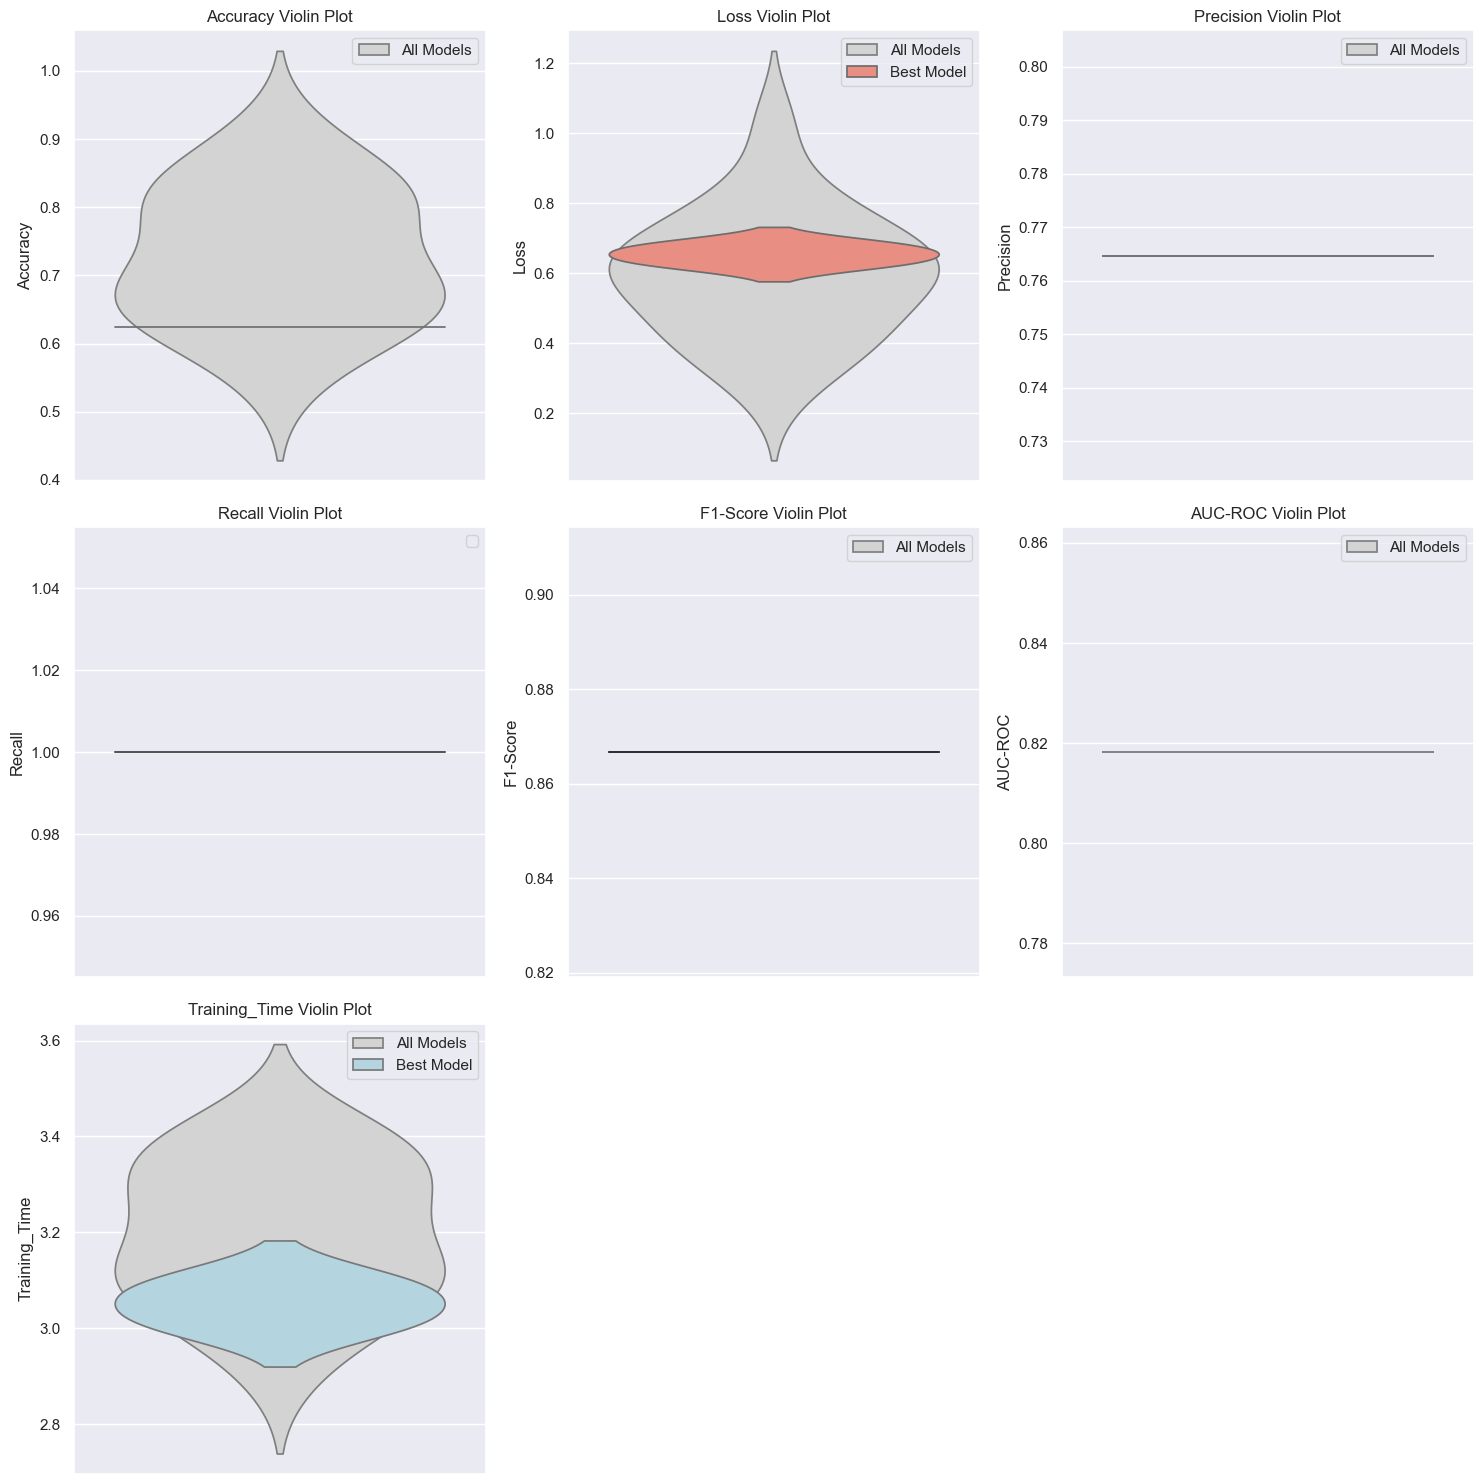

In [107]:
# Filter results_df_mlp for the best model
best_model_results_SVM = results_df_svm[results_df_svm['Fold'] == best_fold_index_MLP]

# Plot histograms for each metric with different colors for all models
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.histplot(results_df_svm[metric], bins=10, kde=True, color='lightgrey', label='All Models')
    sns.histplot(best_model_results_SVM[metric], bins=10, kde=True, color=colors[i-1], label='Best Model')
    plt.title(f'{metric} Distribution')
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

# Plot box plots for each metric with different colors for all models
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=results_df_svm, y=metric, color='lightgrey', showfliers=False)
    sns.boxplot(data=best_model_results_SVM, y=metric, color=colors[i-1], showfliers=False)
    plt.title(f'{metric} Box Plot')
    plt.ylabel(metric)
    plt.legend(['All Models', 'Best Model'])

plt.tight_layout()
plt.show()

# Plot violin plots for each metric with different colors for all models
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.violinplot(data=results_df_svm, y=metric, color='lightgrey', inner=None, label='All Models')
    sns.violinplot(data=best_model_results_SVM, y=metric, color=colors[i-1], inner=None, label='Best Model')
    plt.title(f'{metric} Violin Plot')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()

In [108]:
# Summary statistics
print("\nSummary Statistics:")
display(results_df_svm.describe())


Summary Statistics:


Accuracy       Loss     Precision  Recall      F1-Score    AUC-ROC  \
count  20.000000  20.000000  2.000000e+01    20.0  2.000000e+01  20.000000   
mean    0.727500   0.595201  7.647059e-01     1.0  8.666667e-01   0.818182   
std     0.102704   0.183770  2.278130e-16     0.0  1.139065e-16   0.000000   
min     0.541667   0.267011  7.647059e-01     1.0  8.666667e-01   0.818182   
25%     0.656250   0.471669  7.647059e-01     1.0  8.666667e-01   0.818182   
50%     0.708333   0.608380  7.647059e-01     1.0  8.666667e-01   0.818182   
75%     0.802083   0.685895  7.647059e-01     1.0  8.666667e-01   0.818182   
max     0.916667   1.033007  7.647059e-01     1.0  8.666667e-01   0.818182   

       Training_Time  
count      20.000000  
mean        3.194660  
std         0.152086  
min         2.905698  
25%         3.102353  
50%         3.183570  
75%         3.319985  
max         3.425529

In [109]:
display(results_df_svm)

Fold Early_Stopping  Accuracy      Loss  Precision  Recall  F1-Score  \
0     1      (5, True)  0.680000  0.654292   0.764706     1.0  0.866667   
1     1    (10, False)  0.600000  0.860830   0.764706     1.0  0.866667   
2     2      (5, True)  0.840000  0.384984   0.764706     1.0  0.866667   
3     2    (10, False)  0.680000  0.713583   0.764706     1.0  0.866667   
4     3      (5, True)  0.541667  1.033007   0.764706     1.0  0.866667   
5     3    (10, False)  0.625000  0.759354   0.764706     1.0  0.866667   
6     4      (5, True)  0.625000  0.631748   0.764706     1.0  0.866667   
7     4    (10, False)  0.625000  0.676666   0.764706     1.0  0.866667   
8     5      (5, True)  0.875000  0.353630   0.764706     1.0  0.866667   
9     5    (10, False)  0.791667  0.491132   0.764706     1.0  0.866667   
10    6      (5, True)  0.791667  0.552557   0.764706     1.0  0.866667   
11    6    (10, False)  0.833333  0.603517   0.764706     1.0  0.866667   
12    7      (5, True)  0.666667  0.623793   0.764706     1.0  0.866667   
13    7    (10, False)  0.750000  0.478114   0.764706     1.0  0.866667   
14    8      (5, True)  0.666667  0.768864   0.764706     1.0  0.866667   
15    8    (10, False)  0.833333  0.398922   0.764706     1.0  0.866667   
16    9      (5, True)  0.708333  0.586432   0.764706     1.0  0.866667   
17    9    (10, False)  0.708333  0.613242   0.764706     1.0  0.866667   
18   10      (5, True)  0.916667  0.267011   0.764706     1.0  0.866667   
19   10    (10, False)  0.791667  0.452332   0.764706     1.0  0.866667   

     AUC-ROC  Training_Time  
0   0.818182       3.425529  
1   0.818182       3.345516  
2   0.818182       3.114739  
3   0.818182       3.361304  
4   0.818182       3.396132  
5   0.818182       3.106629  
6   0.818182       3.013544  
7   0.818182       3.089526  
8   0.818182       3.400125  
9   0.818182       3.266313  
10  0.818182       2.992608  
11  0.818182       2.905698  
12  0.818182       3.034000  
13  0.818182       3.263987  
14  0.818182       3.174858  
15  0.818182       3.114765  
16  0.818182       3.276720  
17  0.818182       3.311475  
18  0.818182       3.192282  
19  0.818182       3.107448

3.  Dense Neural Network Model

In [110]:
# Initialize necessary variables
best_accuracy_DNN = 0.0
best_auc_roc_DNN = 0.0
best_f1_score_DNN = 0.0
best_loss_DNN = float('inf')
best_precision_DNN = 0.0
best_training_time_DNN = float('inf')
best_model_DNN = None
best_confusion_matrix_DNN = None
best_recall_DNN = 0.0
fold_histories_DNN = {}
accuracy_list = []
loss_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []
confusion_matrices = [] 
training_time_list = []
fold_histories_DNN = {}

# Initialize DataFrame to store results
results_df_dnn = pd.DataFrame(columns=['Fold', 'Early_Stopping', 'Accuracy', 'Loss', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Training_Time'])

In [111]:
# Perform grid search
for fold_index, (train_index, val_index) in enumerate(kfold.split(x_train, y_train), 1):
    print(f"\nFold {fold_index}:")

    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Apply SMOTE for data augmentation
    smote = SMOTE(random_state=42)
    x_train_fold_smote, y_train_fold_smote = smote.fit_resample(x_train_fold, y_train_fold)

    accuracies_DNN = []
    losses_DNN = []
    precisions_DNN = []
    recalls_DNN = []
    f1_scores_DNN = []
    auc_rocs_DNN = []
    training_times_DNN = []

    for early_stopping_param in early_stopping_params:
        # Define your model architecture as a logistic Support Vector Machine
        model_dense = Sequential([
            Dense(256, activation='relu', input_shape=(x_train.shape[1],), kernel_regularizer=l2(0.001)),
            Dropout(0.5),
            Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
            Dropout(0.4),
            Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
            Dropout(0.4),
            Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
            Dropout(0.3),
            Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
            Dropout(0.3),
            Dense(8, activation='relu', kernel_regularizer=l2(0.001)),
            Dropout(0.2),
            Dense(4, activation='relu', kernel_regularizer=l2(0.001)),
            Dropout(0.1),
            Dense(1, activation='sigmoid')  # Output layer
        ])

        # Compile the model with binary cross-entropy loss
        model_dense.compile(optimizer='Adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_param[0], restore_best_weights=early_stopping_param[1])

        # Train the model and measure training time
        start_time = time.time()
        history = model_dense.fit(x_train_fold_smote, y_train_fold_smote, epochs=75, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)
        training_time = time.time() - start_time
        training_times_DNN.append(training_time)

        # Evaluate the model on validation data
        eval_loss, accuracy_DNN = model_dense.evaluate(x_val_fold, y_val_fold)
        accuracies_DNN.append(accuracy_DNN)
        losses_DNN.append(eval_loss)

        # Get predictions for calculating additional metrics
        y_pred = (model_dense.predict(x_val_fold) > 0.5).astype("int32")

        # Calculate additional metrics
        precision = precision_score(y_val_fold, y_pred)
        recall = recall_score(y_val_fold, y_pred)
        f1 = f1_score(y_val_fold, y_pred)
        auc = roc_auc_score(y_val_fold, y_pred)

        precisions_DNN.append(precision)
        recalls_DNN.append(recall)
        f1_scores_DNN.append(f1)
        auc_rocs_DNN.append(auc)

        # Compute confusion matrix
        cm = confusion_matrix(y_val_fold, y_pred)
        confusion_matrices.append(cm)

        # Append results to the DataFrame
        results_df_dnn = pd.concat([results_df_dnn, pd.DataFrame({
            'Fold': [fold_index],
            'Early_Stopping': [early_stopping_param],
            'Accuracy': [accuracy_DNN],
            'Loss': [eval_loss],
            'Precision': [precision],
            'Recall': [recall],
            'F1-Score': [f1],
            'AUC-ROC': [auc],
            'Training_Time': [training_time]
        })], ignore_index=True)

        print(f"Early Stopping: {early_stopping_param}, Accuracy = {accuracy_DNN:.4f}, Loss = {eval_loss:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1-Score = {f1:.4f}, AUC-ROC = {auc:.4f}, Training Time = {training_time:.2f} seconds")

        # Update lists for histograms
        accuracy_list.extend(accuracies_DNN)
        loss_list.extend(losses_DNN)
        precision_list.extend(precisions_DNN)
        recall_list.extend(recalls_DNN)
        f1_list.extend(f1_scores_DNN)
        auc_list.extend(auc_rocs_DNN)
        training_time_list.extend(training_times_DNN)

        # Calculate mean accuracy and loss
        mean_accuracy_DNN = np.mean(accuracies_DNN)
        mean_loss_DNN = np.mean(losses_DNN)

        # Store training history
        fold_histories_DNN[fold_index] = history

        # Update best parameters if the mean accuracy is higher
        if mean_accuracy_DNN > best_accuracy_DNN:
            best_accuracy_DNN = mean_accuracy_DNN
            best_model_DNN = model_dense
            best_confusion_matrix_DNN = confusion_matrix(y_val_fold, y_pred)
            best_precision_DNN = precision
            best_recall_DNN = recall
            best_f1_score_DNN = f1
            best_auc_roc_DNN = auc
            best_recall_DNN = recall
            best_loss_DNN = eval_loss
            best_training_time_DNN = training_time

# Print best parameters and mean accuracy
print("Best Mean Accuracy:", best_accuracy_DNN)

# Save the best trained model to disk
if best_model_DNN is not None:
    best_model_DNN.save('saved_model/Dense_NN_Model.h5')

# Find the best model based on validation accuracy
best_fold_index_DNN = results_df_dnn.loc[results_df_dnn['Accuracy'].idxmax()]['Fold']
best_model_history_DNN = fold_histories[best_fold_index_DNN]


Fold 1:
1/1 [==============================] - 0s 84ms/step
Early Stopping: (5, True), Accuracy = 0.6800, Loss = 1.0033, Precision = 0.7500, Recall = 0.6429, F1-Score = 0.6923, AUC-ROC = 0.6851, Training Time = 3.84 seconds


C:\Users\piyus\AppData\Local\Temp\ipykernel_17976\728442089.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df_dnn = pd.concat([results_df_dnn, pd.DataFrame({


1/1 [==============================] - 0s 83ms/step
Early Stopping: (10, False), Accuracy = 0.7200, Loss = 1.2049, Precision = 0.7692, Recall = 0.7143, F1-Score = 0.7407, AUC-ROC = 0.7208, Training Time = 4.69 seconds

Fold 2:
1/1 [==============================] - 0s 78ms/step
Early Stopping: (5, True), Accuracy = 0.8400, Loss = 0.6368, Precision = 0.8462, Recall = 0.8462, F1-Score = 0.8462, AUC-ROC = 0.8397, Training Time = 2.77 seconds
1/1 [==============================] - 0s 79ms/step
Early Stopping: (10, False), Accuracy = 0.8400, Loss = 0.5503, Precision = 0.8462, Recall = 0.8462, F1-Score = 0.8462, AUC-ROC = 0.8397, Training Time = 3.39 seconds

Fold 3:
1/1 [==============================] - 0s 84ms/step
Early Stopping: (5, True), Accuracy = 0.7500, Loss = 1.0835, Precision = 0.7333, Recall = 0.8462, F1-Score = 0.7857, AUC-ROC = 0.7413, Training Time = 3.88 seconds
1/1 [==============================] - 0s 79ms/step
Early Stopping: (10, False), Accuracy = 0.7083, Loss = 1.2964,

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


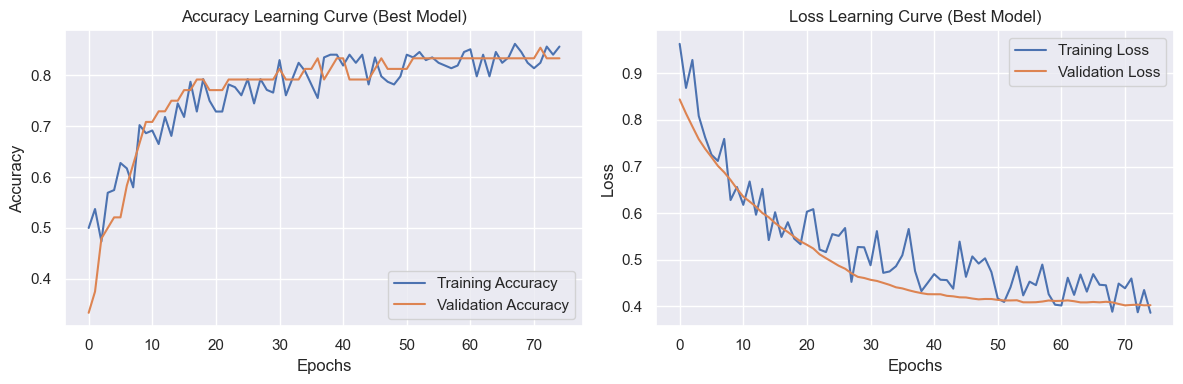

In [141]:
# Plot learning curves for the best model
plt.figure(figsize=(12, 4))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(best_model_history_DNN.history['accuracy'], label='Training Accuracy')
plt.plot(best_model_history_DNN.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Learning Curve (Best Model)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(best_model_history_DNN.history['loss'], label='Training Loss')
plt.plot(best_model_history_DNN.history['val_loss'], label='Validation Loss')
plt.title('Loss Learning Curve (Best Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

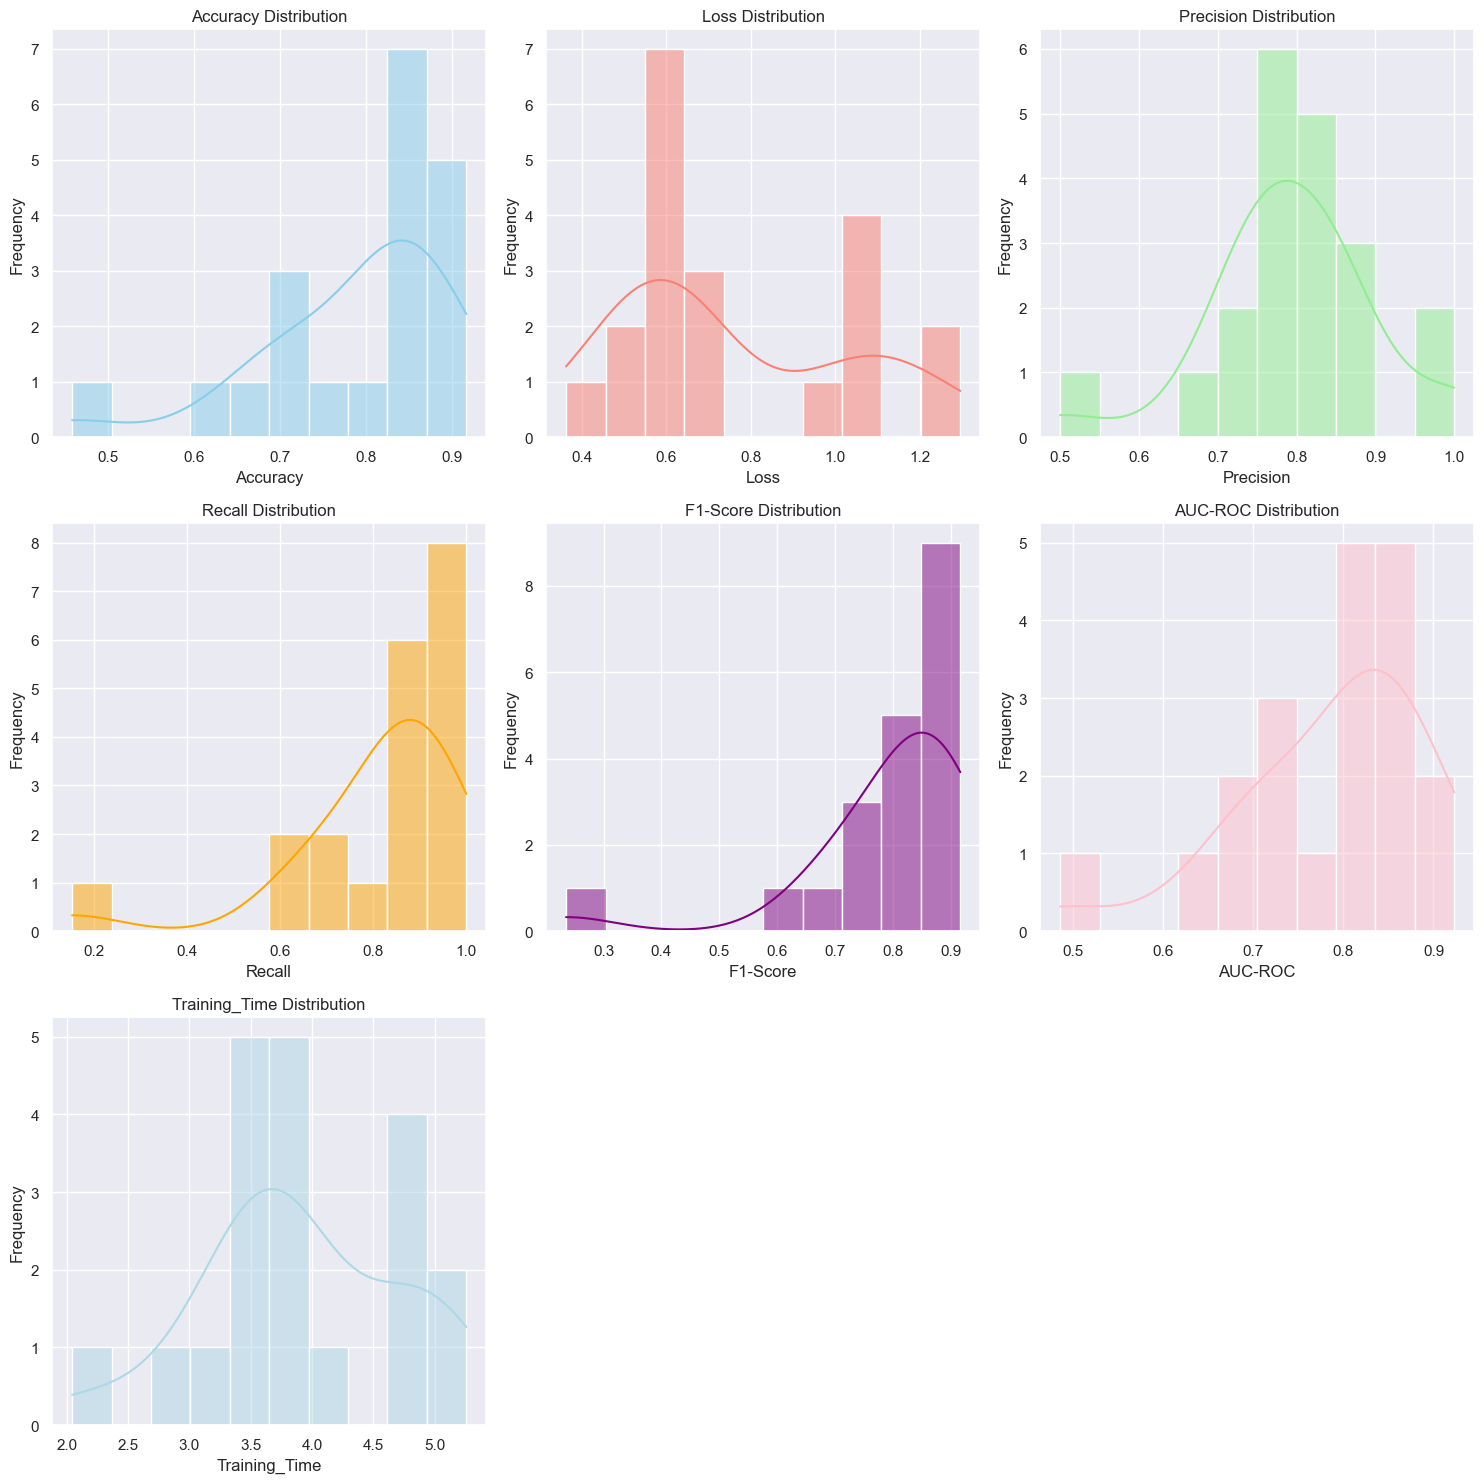

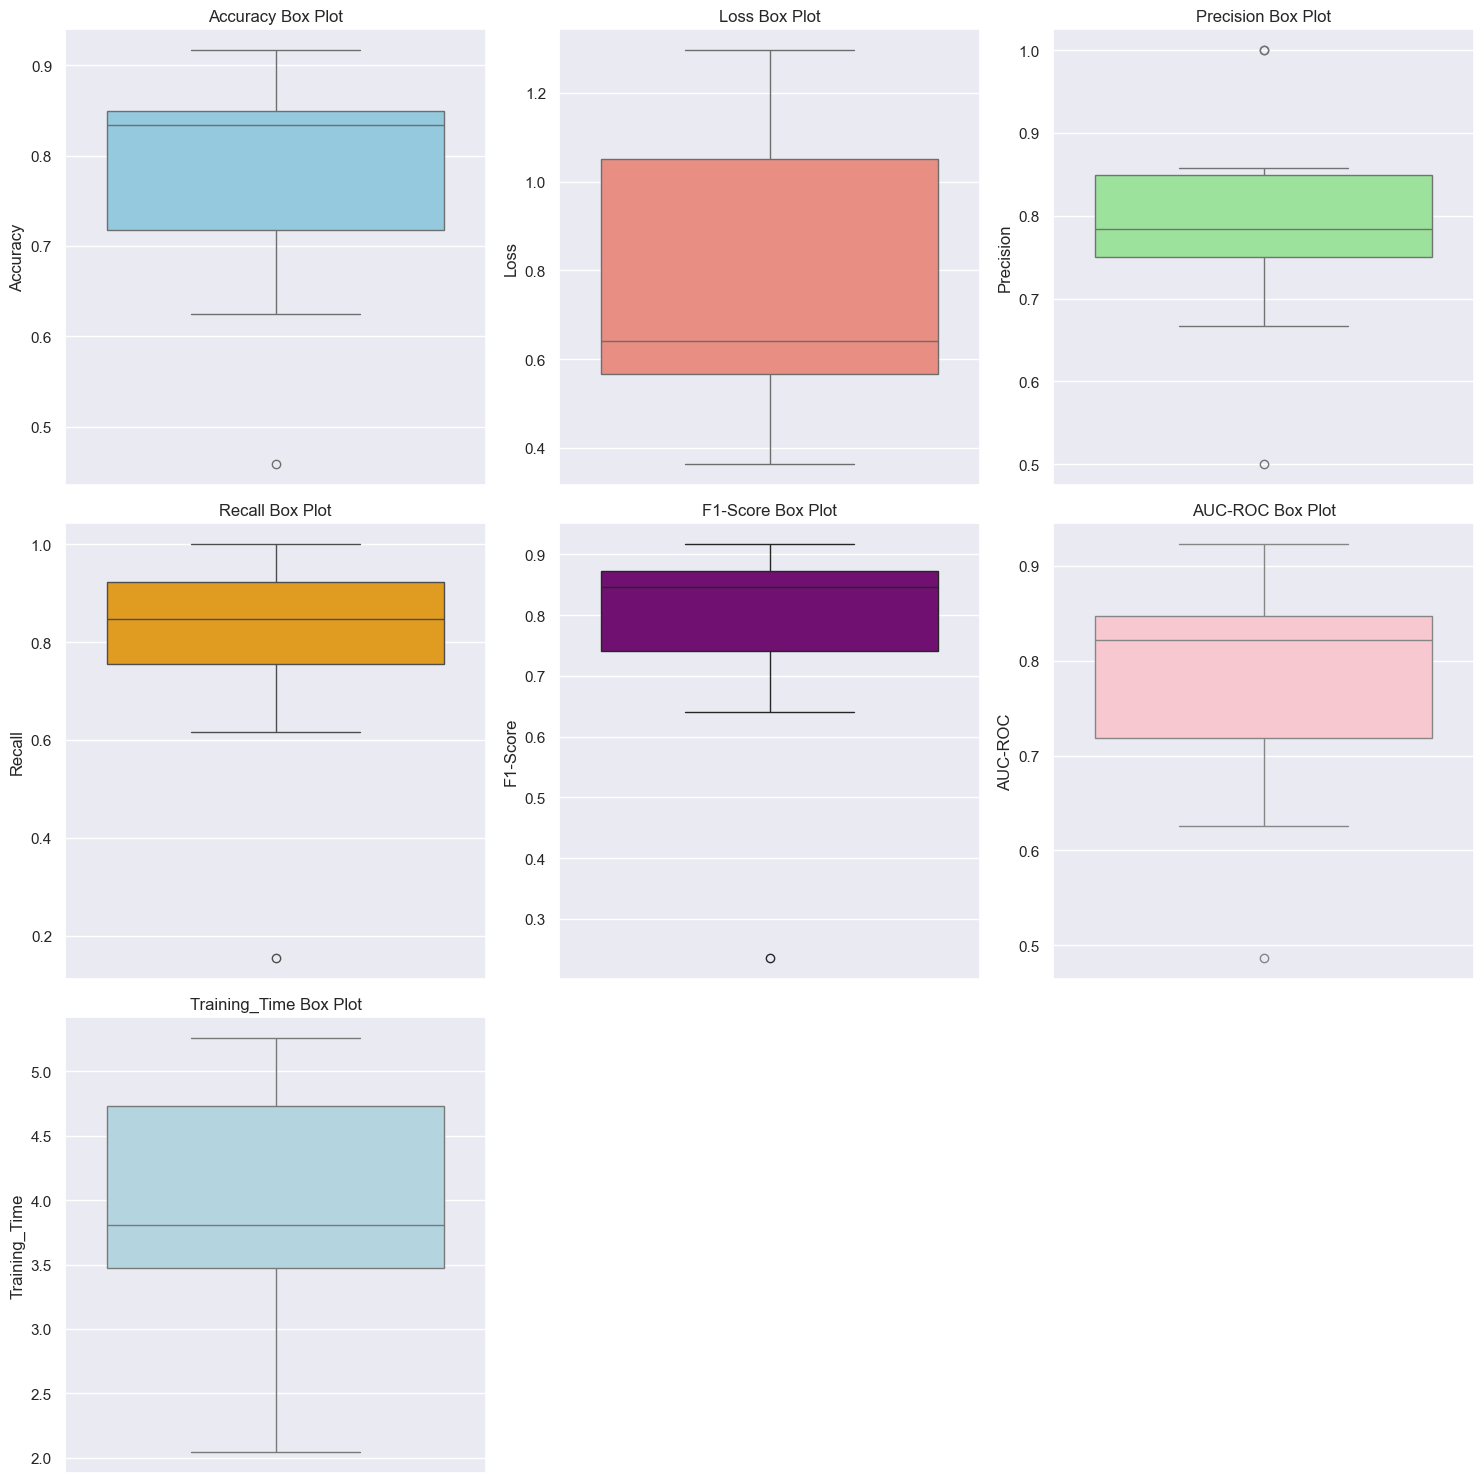

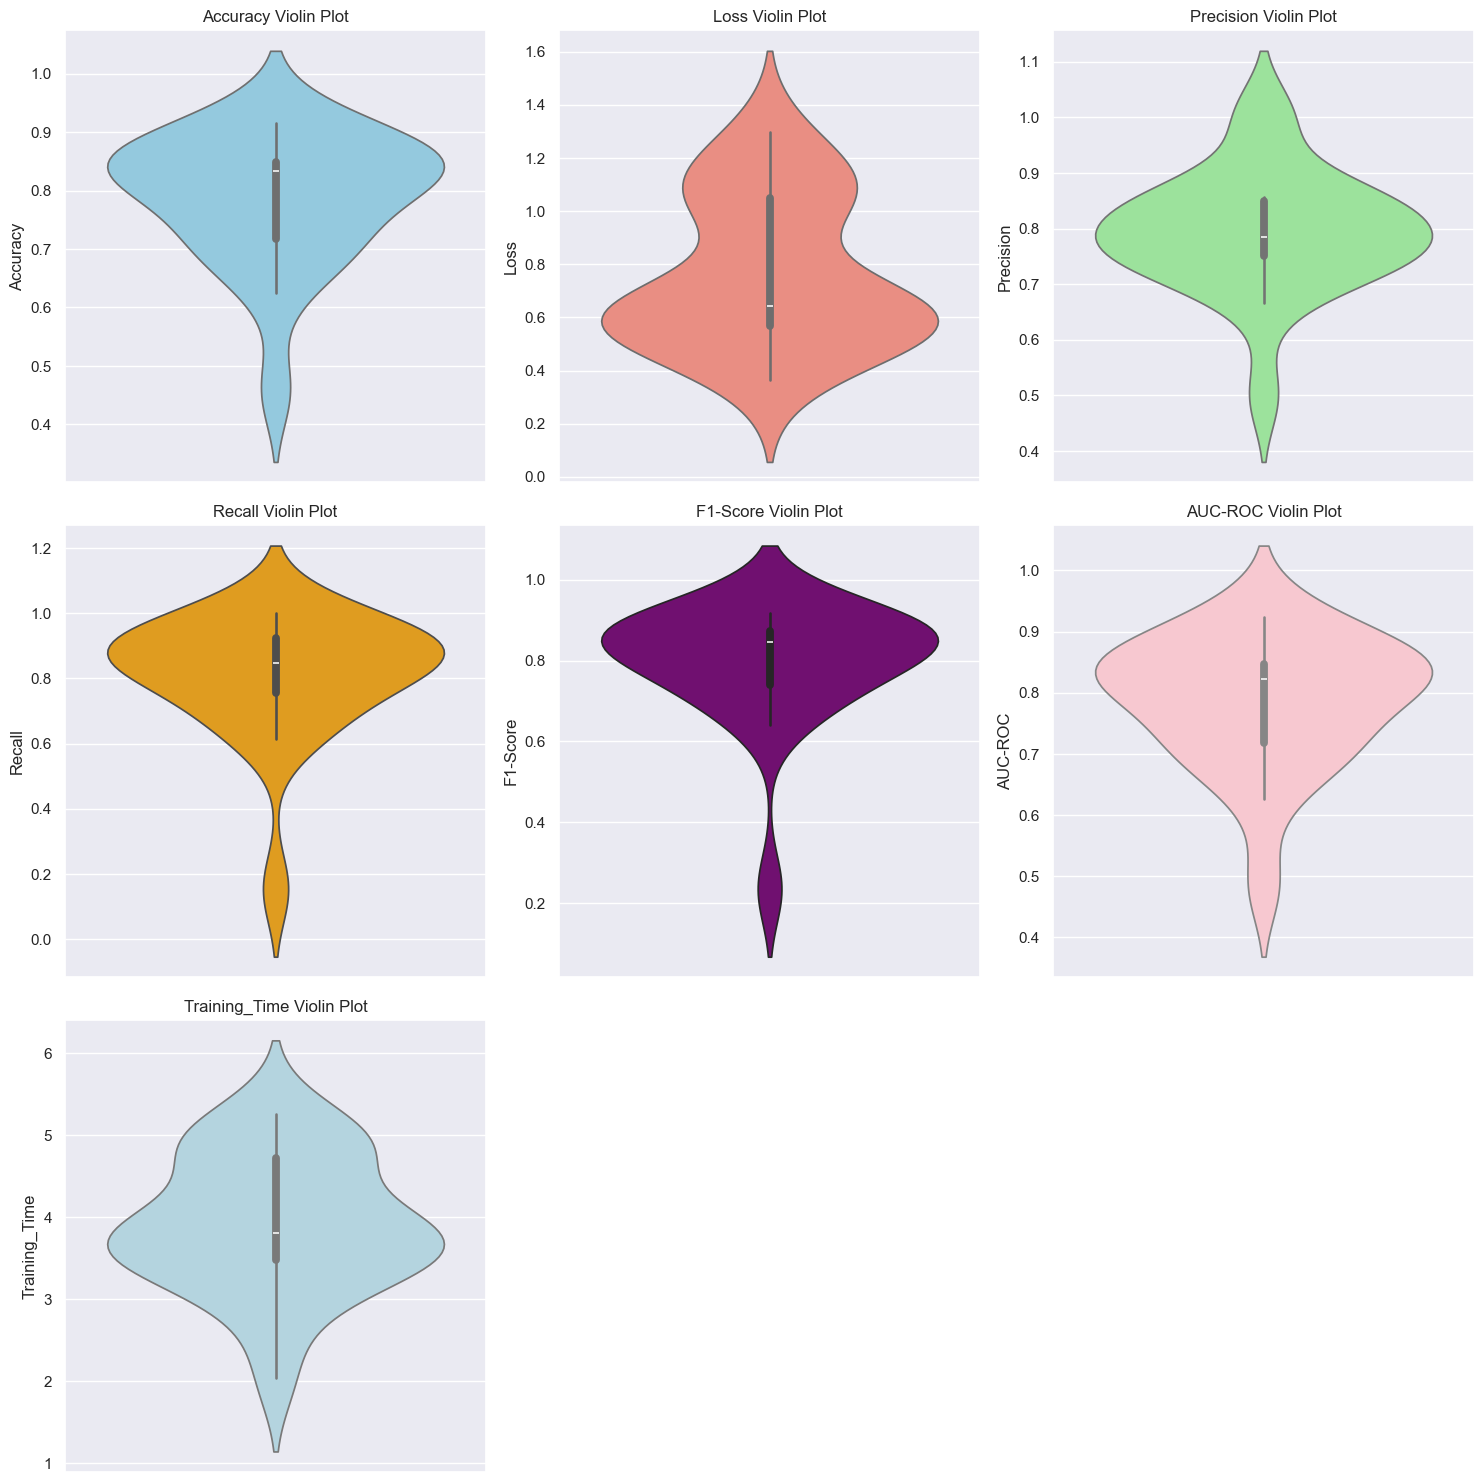

In [142]:
# Plot histograms for each metric with different colors
metrics = ['Accuracy', 'Loss', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Training_Time']
colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'purple', 'pink', 'lightblue']

plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.histplot(results_df_dnn[metric], bins=10, kde=True, color=colors[i-1])
    plt.title(f'{metric} Distribution')
    plt.xlabel(metric)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plot box plots for each metric with different colors
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=results_df_dnn, y=metric, color=colors[i-1])
    plt.title(f'{metric} Box Plot')

plt.tight_layout()
plt.show()

# Plot violin plots for each metric with different colors
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.violinplot(data=results_df_dnn, y=metric, color=colors[i-1])
    plt.title(f'{metric} Violin Plot')

plt.tight_layout()
plt.show()

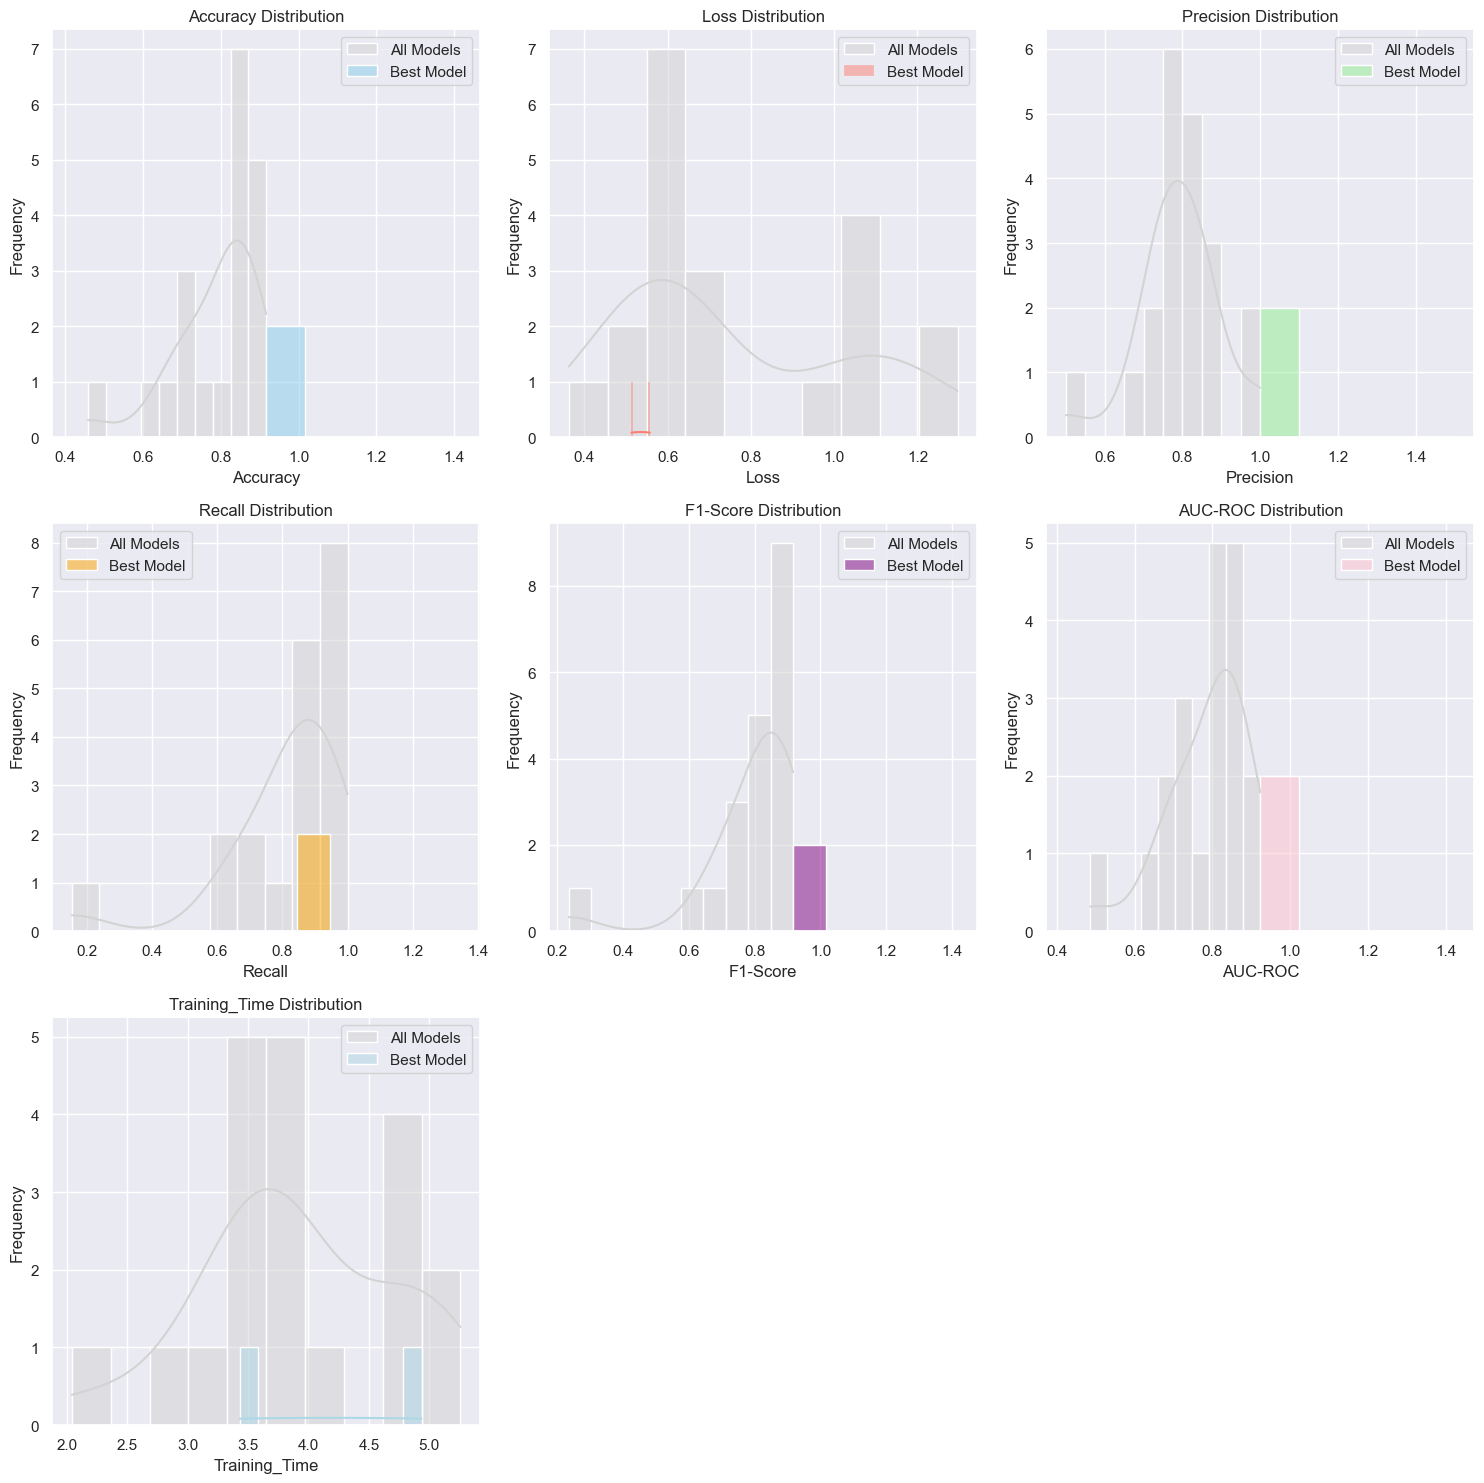

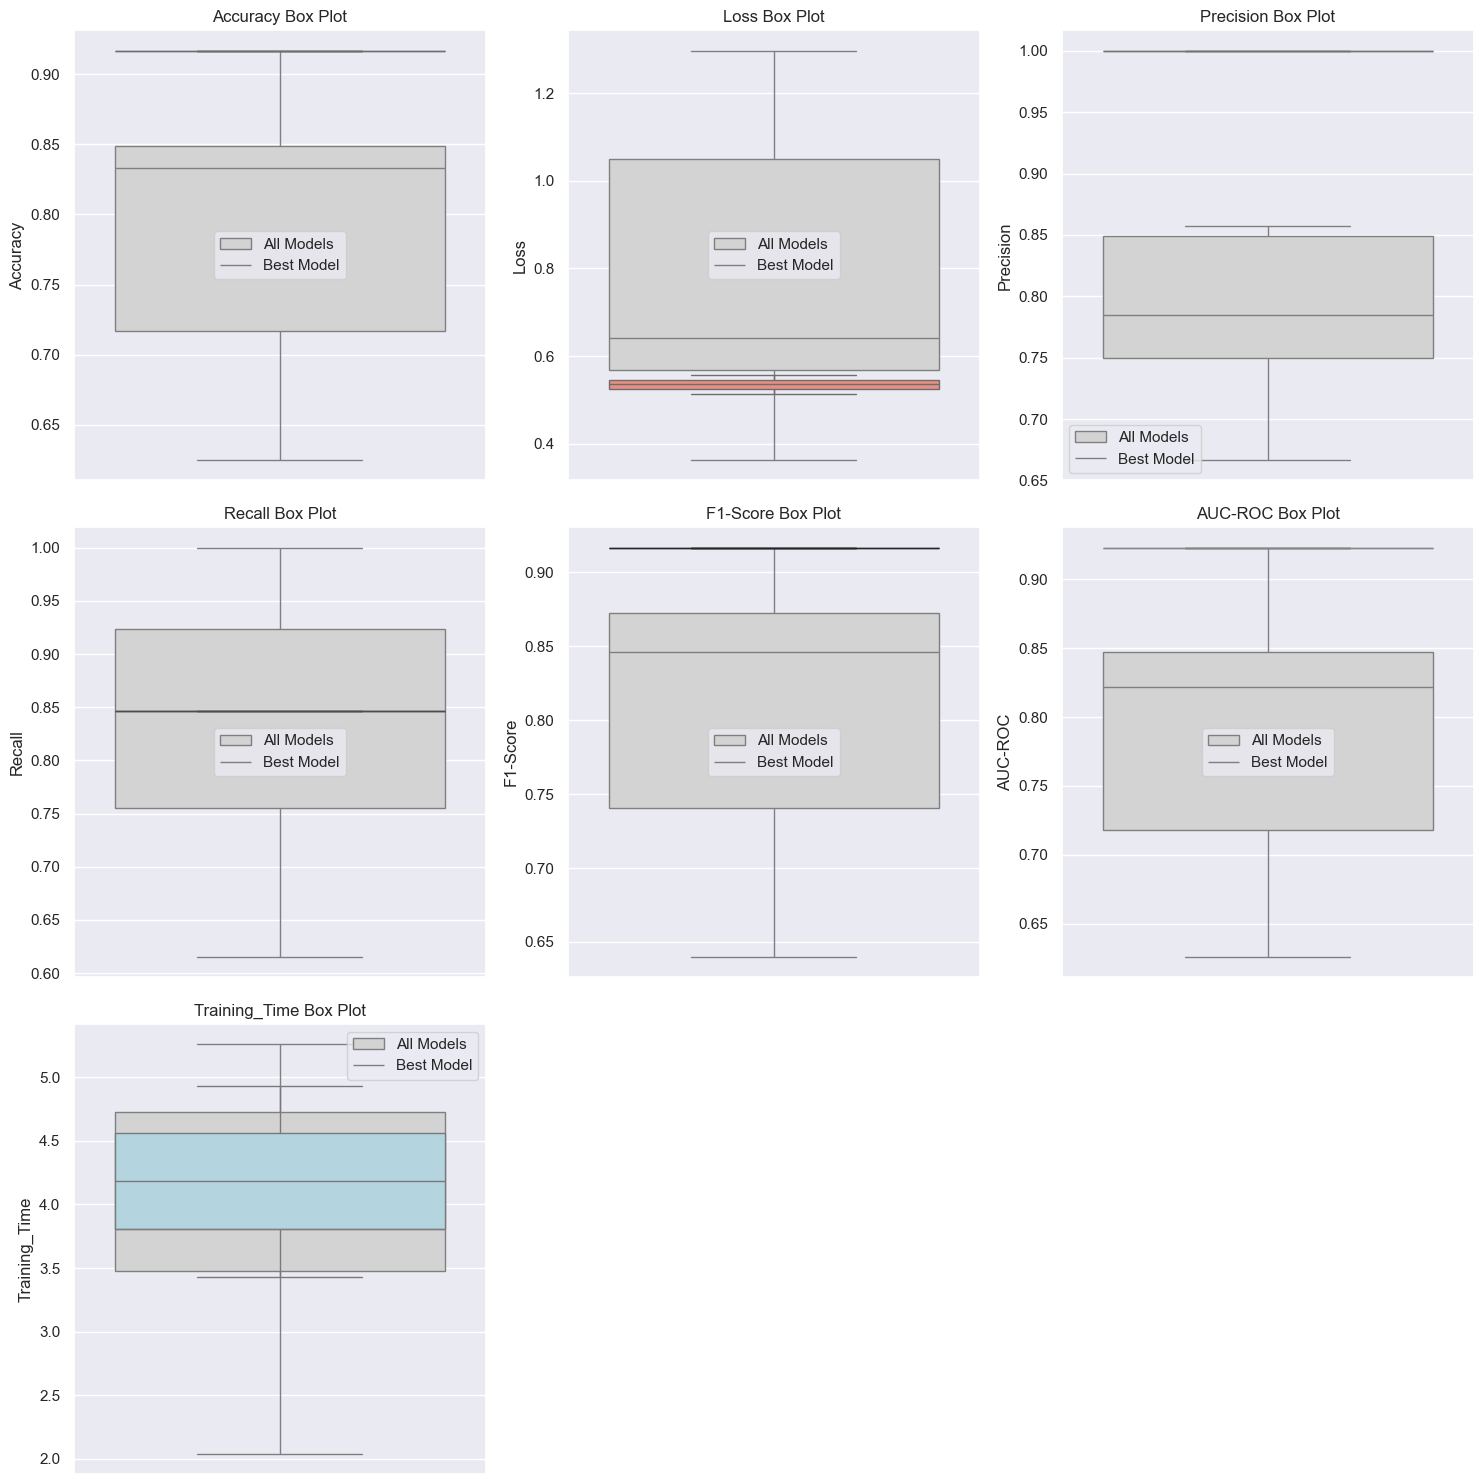

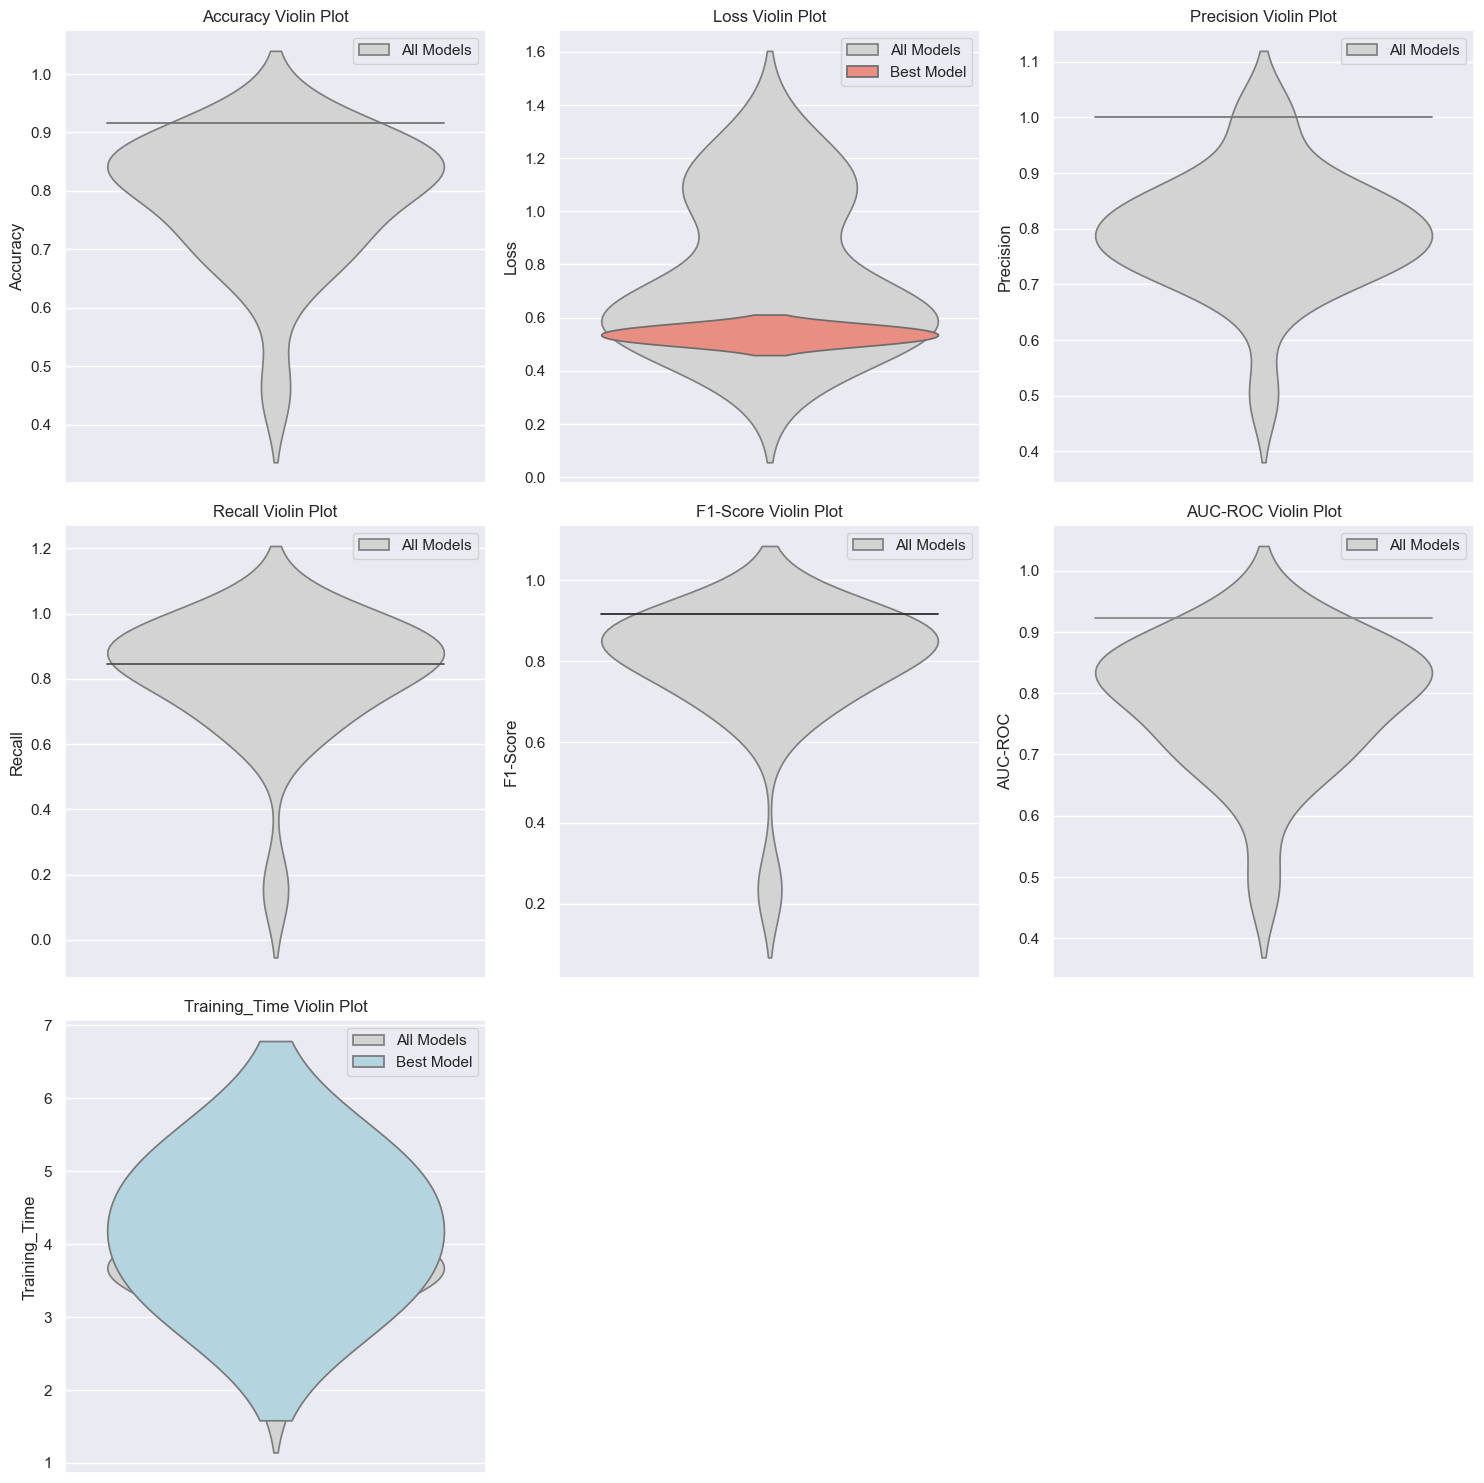

In [143]:
# Filter results_df_mlp for the best model
best_model_results_DNN = results_df_dnn[results_df_dnn['Fold'] == best_fold_index_MLP]

# Plot histograms for each metric with different colors for all models
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.histplot(results_df_dnn[metric], bins=10, kde=True, color='lightgrey', label='All Models')
    sns.histplot(best_model_results_DNN[metric], bins=10, kde=True, color=colors[i-1], label='Best Model')
    plt.title(f'{metric} Distribution')
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

# Plot box plots for each metric with different colors for all models
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=results_df_dnn, y=metric, color='lightgrey', showfliers=False)
    sns.boxplot(data=best_model_results_DNN, y=metric, color=colors[i-1], showfliers=False)
    plt.title(f'{metric} Box Plot')
    plt.ylabel(metric)
    plt.legend(['All Models', 'Best Model'])

plt.tight_layout()
plt.show()

# Plot violin plots for each metric with different colors for all models
plt.figure(figsize=(15, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.violinplot(data=results_df_dnn, y=metric, color='lightgrey', inner=None, label='All Models')
    sns.violinplot(data=best_model_results_DNN, y=metric, color=colors[i-1], inner=None, label='Best Model')
    plt.title(f'{metric} Violin Plot')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()

In [144]:
# Summary statistics
print("\nSummary Statistics:")
display(results_df_dnn.describe())


Summary Statistics:


Accuracy       Loss  Precision     Recall   F1-Score    AUC-ROC  \
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000   
mean    0.787333   0.762914   0.793641   0.810165   0.793423   0.785385   
std     0.111728   0.279326   0.109035   0.188873   0.152583   0.106858   
min     0.458333   0.362864   0.500000   0.153846   0.235294   0.486014   
25%     0.717083   0.567478   0.750000   0.755495   0.740741   0.718032   
50%     0.833333   0.641361   0.784615   0.846154   0.846154   0.821678   
75%     0.848750   1.050360   0.848901   0.923077   0.872222   0.847465   
max     0.916667   1.296393   1.000000   1.000000   0.916667   0.923077   

       Training_Time  
count      20.000000  
mean        3.907339  
std         0.819060  
min         2.042728  
25%         3.476241  
50%         3.803687  
75%         4.726852  
max         5.257103

In [145]:
# Summary statistics
print("\nSummary Statistics:")
print(results_df_dnn.describe())


Summary Statistics:
        Accuracy       Loss  Precision     Recall   F1-Score    AUC-ROC  \
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000   
mean    0.787333   0.762914   0.793641   0.810165   0.793423   0.785385   
std     0.111728   0.279326   0.109035   0.188873   0.152583   0.106858   
min     0.458333   0.362864   0.500000   0.153846   0.235294   0.486014   
25%     0.717083   0.567478   0.750000   0.755495   0.740741   0.718032   
50%     0.833333   0.641361   0.784615   0.846154   0.846154   0.821678   
75%     0.848750   1.050360   0.848901   0.923077   0.872222   0.847465   
max     0.916667   1.296393   1.000000   1.000000   0.916667   0.923077   

       Training_Time  
count      20.000000  
mean        3.907339  
std         0.819060  
min         2.042728  
25%         3.476241  
50%         3.803687  
75%         4.726852  
max         5.257103  


Calculating Required Fields

In [146]:
print("Shape of y_test:", y_test.shape)
y_test = y_test.reshape(-1, 1)
print("Shape of y_test:", y_test.shape)
num_classes = y_test.shape[1]
y_test_orig = y_test
y_test = y_test[:61].reshape(-1, 1)
print("Shape of y_test:", y_test.shape)

Shape of y_test: (61, 1)
Shape of y_test: (61, 1)
Shape of y_test: (61, 1)


In [147]:
# Function to compute softmax error (categorical cross-entropy loss)
def compute_softmax_error(model, x_test, y_test):
    predictions = model.predict(x_test)
    loss_fn = CategoricalCrossentropy()
    softmax_error = loss_fn(y_test, predictions).numpy()
    return softmax_error

# Placeholder function to simulate teacher model predictions
def get_teacher_predictions(x_data):
    # In practice, this would be obtained from a trained teacher model
    return np.random.rand(x_data.shape[0], num_classes)

# Function to compute distillation error (KLDivergence)
def compute_distillation_error(student_model, x_data, teacher_predictions):
    predictions = student_model.predict(x_data)
    distillation_loss = KLDivergence()
    distillation_error = distillation_loss(teacher_predictions, predictions).numpy()
    return distillation_error

# Function to compute ConfWeight Error
def compute_confweight_error(model, x_data, y_data):
    predictions = model.predict(x_data)
    confidences = np.max(predictions, axis=1)
    correct_predictions = np.argmax(predictions, axis=1) == np.argmax(y_data, axis=1)
    errors = 1 - correct_predictions
    confweight_error = np.mean(errors * (1 - confidences))
    return confweight_error

# Function to compute SRatio Error
def compute_sratio_error(model, x_data, y_data):
    predictions = model.predict(x_data)
    true_probabilities = y_data / np.sum(y_data, axis=1, keepdims=True)
    predicted_probabilities = predictions / np.sum(predictions, axis=1, keepdims=True)
    sratio_error = np.mean(np.abs(true_probabilities - predicted_probabilities))
    return sratio_error

1.  MLP Model

In [148]:
model_MLP = load_model(r'saved_model/MLP_Model.h5')

# Compute and print Softmax Error
softmax_error_MLP = compute_softmax_error(model_MLP, x_test, y_test)
print(f"Softmax Error: {softmax_error_MLP}")

# Compute and print Distillation Error
teacher_predictions_MLP = get_teacher_predictions(x_test)
distillation_error_MLP = compute_distillation_error(model_MLP, x_test, teacher_predictions_MLP)
print(f"Distillation Error: {distillation_error_MLP}")

# Compute and print ConfWeight Error
confweight_error_MLP = compute_confweight_error(model_MLP, x_test, y_test)
print(f"ConfWeight Error: {confweight_error_MLP}")

# Compute and print SRatio Error
sratio_error_MLP = compute_sratio_error(model_MLP, x_test, y_test)
print(f"SRatio Error: {sratio_error_MLP}")

# Track and print computation time for predictions
start_time_MLP = time.time()
predictions_MLP = model_MLP.predict(x_test)
computation_time_MLP = time.time() - start_time_MLP
print(f"Computation Time: {computation_time_MLP} seconds")

2/2 [==============================] - 0s 2ms/step
Softmax Error: 6.644452810178336e-08
2/2 [==============================] - 0s 1ms/step
Distillation Error: 0.25878992676734924
2/2 [==============================] - 0s 1ms/step
ConfWeight Error: 0.0
2/2 [==============================] - 0s 1ms/step


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\util\dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(61, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)
C:\Users\piyus\AppData\Local\Temp\ipykernel_17976\2073719375.py:32: RuntimeWarning: invalid value encountered in divide
  true_probabilities = y_data / np.sum(y_data, axis=1, keepdims=True)


SRatio Error: nan
2/2 [==============================] - 0s 2ms/step
Computation Time: 0.05921339988708496 seconds


In [149]:
print("Error Metrics for the MLP Model:")
print(f"- Softmax Error: {softmax_error_MLP:.3e}")
print(f"- Distillation Error: {distillation_error_MLP:.2f}")
print(f"- ConfWeight Error: {confweight_error_MLP}")
print(f"- SRatio Error: {sratio_error_MLP}")
print(f"- Computation Time: {computation_time_MLP:.4f} seconds")

Error Metrics for the MLP Model:
- Softmax Error: 6.644e-08
- Distillation Error: 0.26
- ConfWeight Error: 0.0
- SRatio Error: nan
- Computation Time: 0.0592 seconds


2.  For SVM-Architecture Model

In [150]:
model_SVM = load_model(r'saved_model/SVM_Model.h5')

# Compute and print Softmax Error
softmax_error_SVM = compute_softmax_error(model_SVM, x_test, y_test)
print(f"Softmax Error: {softmax_error_SVM}")

# Compute and print Distillation Error
teacher_predictions_SVM = get_teacher_predictions(x_test)
distillation_error_SVM = compute_distillation_error(model_SVM, x_test, teacher_predictions_SVM)
print(f"Distillation Error: {distillation_error_SVM}")

# Compute and print ConfWeight Error
confweight_error_SVM = compute_confweight_error(model_SVM, x_test, y_test)
print(f"ConfWeight Error: {confweight_error_SVM}")

# Compute and print SRatio Error
sratio_error_SVM = compute_sratio_error(model_SVM, x_test, y_test)
print(f"SRatio Error: {sratio_error_SVM}")

# Track and print computation time for predictions
start_time_SVM = time.time()
predictions_SVM = model_SVM.predict(x_test)
computation_time_SVM = time.time() - start_time_SVM
print(f"Computation Time: {computation_time_SVM} seconds") 

2/2 [==============================] - 0s 2ms/step
Softmax Error: 6.644452810178336e-08
2/2 [==============================] - 0s 1ms/step
Distillation Error: 3.434723138809204
2/2 [==============================] - 0s 1ms/step
ConfWeight Error: 0.0
2/2 [==============================] - 0s 1ms/step
SRatio Error: nan
2/2 [==============================] - 0s 2ms/step
Computation Time: 0.05955672264099121 seconds


C:\Users\piyus\AppData\Local\Temp\ipykernel_17976\2073719375.py:32: RuntimeWarning: invalid value encountered in divide
  true_probabilities = y_data / np.sum(y_data, axis=1, keepdims=True)


In [151]:
print("Error Metrics for the SVM Model:")
print(f"- Softmax Error: {softmax_error_SVM:.3e}")
print(f"- Distillation Error: {distillation_error_SVM:.2f}")
print(f"- ConfWeight Error: {confweight_error_SVM}")
print(f"- SRatio Error: {sratio_error_SVM}")
print(f"- Computation Time: {computation_time_SVM:.4f} seconds")

Error Metrics for the SVM Model:
- Softmax Error: 6.644e-08
- Distillation Error: 3.43
- ConfWeight Error: 0.0
- SRatio Error: nan
- Computation Time: 0.0596 seconds


3. DNN Model

In [152]:
model_DNN = load_model(r'saved_model/Dense_NN_Model.h5')

# Compute and print Softmax Error
softmax_error_DNN = compute_softmax_error(model_DNN, x_test, y_test)
print(f"Softmax Error: {softmax_error_DNN}")

# Compute and print Distillation Error
teacher_predictions_DNN = get_teacher_predictions(x_test)
distillation_error_DNN = compute_distillation_error(model_DNN, x_test, teacher_predictions_DNN)
print(f"Distillation Error: {distillation_error_DNN}")

# Compute and print ConfWeight Error
confweight_error_DNN = compute_confweight_error(model_DNN, x_test, y_test)
print(f"ConfWeight Error: {confweight_error_DNN}")

# Compute and print SRatio Error
sratio_error_DNN = compute_sratio_error(model_DNN, x_test, y_test)
print(f"SRatio Error: {sratio_error_DNN}")

# Track and print computation time for predictions
start_time_DNN = time.time()
predictions_DNN = model_DNN.predict(x_test)
computation_time_DNN = time.time() - start_time_DNN
print(f"Computation Time: {computation_time_DNN} seconds")

2/2 [==============================] - 0s 2ms/step
Softmax Error: 6.644452810178336e-08
2/2 [==============================] - 0s 1ms/step
Distillation Error: 0.15104930102825165
2/2 [==============================] - 0s 3ms/step
ConfWeight Error: 0.0
2/2 [==============================] - 0s 2ms/step
SRatio Error: nan
2/2 [==============================] - 0s 2ms/step
Computation Time: 0.06088399887084961 seconds


C:\Users\piyus\AppData\Local\Temp\ipykernel_17976\2073719375.py:32: RuntimeWarning: invalid value encountered in divide
  true_probabilities = y_data / np.sum(y_data, axis=1, keepdims=True)


In [153]:
print("Error Metrics for the DNN Model:")
print(f"- Softmax Error: {softmax_error_DNN:.3e}")
print(f"- Distillation Error: {distillation_error_DNN:.2f}")
print(f"- ConfWeight Error: {confweight_error_DNN}")
print(f"- SRatio Error: {sratio_error_DNN}")
print(f"- Computation Time: {computation_time_DNN:.4f} seconds")

Error Metrics for the DNN Model:
- Softmax Error: 6.644e-08
- Distillation Error: 0.15
- ConfWeight Error: 0.0
- SRatio Error: nan
- Computation Time: 0.0609 seconds


CONCLUSION

In [154]:
# DataFrame creation with custom number formatting
data = {
    "Model Name": ["MLP Model", "SVM Model", "DNN Model"],
    "Accuracy": ["{:.2f}".format(best_accuracy_MLP * 100) + " %",
                 "{:.2f}".format(best_accuracy_SVM * 100) + " %",
                 "{:.2f}".format(best_accuracy_DNN * 100) + " %"],
    "Precision": ["{:.2f}".format(best_precision_MLP * 100) + " %",
                  "{:.2f}".format(best_precision_SVM * 100) + " %",
                  "{:.2f}".format(best_precision_DNN * 100) + " %"],
    "Recall": ["{:.2f}".format(best_recall_MLP),
               "{:.2f}".format(best_recall_SVM),
               "{:.2f}".format(best_recall_DNN)],
    "f1-Score": ["{:.2f}".format(best_f1_score_MLP),
                 "{:.2f}".format(best_f1_score_SVM),
                 "{:.2f}".format(best_f1_score_DNN)],
    "AUC ROC": ["{:.2f}".format(best_auc_roc_MLP),
                "{:.2f}".format(best_auc_roc_SVM),
                "{:.2f}".format(best_auc_roc_DNN)],
    "Loss": ["{:.4f}".format(best_loss_MLP),
             "{:.4f}".format(best_loss_SVM),
             "{:.4f}".format(best_loss_DNN)],
    "Training Time (s)": [best_training_time_MLP,
                        best_training_time_SVM,
                        best_training_time_DNN],
    "SM Error": ["{:.3e}".format(softmax_error_MLP),
                 "{:.3e}".format(softmax_error_SVM),
                 "{:.3e}".format(softmax_error_DNN)],
    "Distillation Error (SM)": ["{:.2f}".format(distillation_error_MLP),
                                 "{:.2f}".format(distillation_error_SVM),
                                 "{:.2f}".format(distillation_error_DNN)],
    "ConfWeight Error (SM)": ["{:.2f}".format(confweight_error_MLP),
                               "{:.2f}".format(confweight_error_SVM),
                               "{:.2f}".format(confweight_error_DNN)],
    "SRatio Error (SM)": ["{:.2f}".format(sratio_error_MLP),
                          "{:.2f}".format(sratio_error_SVM),
                          "{:.2f}".format(sratio_error_DNN)],
    "Computation Time (s)": [computation_time_MLP,
                            computation_time_SVM,
                            computation_time_DNN]
}

# DataFrame creation
df_acc = pd.DataFrame(data)
# DataFrame creation
df_acc = pd.DataFrame(data)

# Function to highlight the maximum in each column
def highlight_max(s):
    is_max = s == s.max()
    return ['color: grey; font-weight: bold' if v else '' for v in is_max]

# Apply the function to the DataFrame using Styler
styled_df = df_acc.style.apply(highlight_max, subset=['Accuracy', 'Precision', 'Recall', 'f1-Score', 'AUC ROC', 'Loss', 
                                                      'Training Time (s)', 'SM Error', 'Distillation Error (SM)', 
                                                      'ConfWeight Error (SM)', 'SRatio Error (SM)', 
                                                      'Computation Time (s)'])

# Display the styled DataFrame
display(styled_df)

The MLP Model is the best overall due to its balance of high precision, high F1-score, high AUC ROC, and efficient training/computation times. It provides a good trade-off between precision and recall, making it a robust choice for most applications.

Model Summary

1.  MLP Model

In [155]:
# Load the pre-trained model
model = load_model('saved_model/MLP_Model.h5')  # Provide the path to your pre-trained model

# Print the model summary
print(model.summary())

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_140 (Dense)           (None, 32)                416       
                                                                 
 batch_normalization_52 (Ba  (None, 32)                128       
 tchNormalization)                                               
                                                                 
 dropout_59 (Dropout)        (None, 32)                0         
                                                                 
 dense_141 (Dense)           (None, 16)                528       
                                                                 
 batch_normalization_53 (Ba  (None, 16)                64        
 tchNormalization)                                               
                                                                 
 dropout_60 (Dropout)        (None, 16)              

2.  SVM Model

In [156]:
# Load the pre-trained model
model = load_model('saved_model/SVM_Model.h5')  # Provide the path to your pre-trained model

# Print the model summary
print(model.summary())

Model: "sequential_116"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_362 (Dense)           (None, 1)                 13        
                                                                 
Total params: 13 (52.00 Byte)
Trainable params: 13 (52.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


3.  DNN Model

In [157]:
# Load the pre-trained model
model = load_model('saved_model/Dense_NN_Model.h5')  # Provide the path to your pre-trained model

# Print the model summary
print(model.summary())

Model: "sequential_124"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_412 (Dense)           (None, 256)               3328      
                                                                 
 dropout_269 (Dropout)       (None, 256)               0         
                                                                 
 dense_413 (Dense)           (None, 128)               32896     
                                                                 
 dropout_270 (Dropout)       (None, 128)               0         
                                                                 
 dense_414 (Dense)           (None, 64)                8256      
                                                                 
 dropout_271 (Dropout)       (None, 64)                0         
                                                                 
 dense_415 (Dense)           (None, 32)             

Predicting With Sample

In [158]:
# Display the input shape of the model
print("Model Input Shape:", model.input_shape)

Model Input Shape: (None, 12)


In [159]:
df.columns

Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output'],
      dtype='object')

In [160]:
import numpy as np

# Convert the sample input data to a NumPy array
sample_input_array = np.array([52, 1, 0, 128, 255, 0, 1, 161, 1, 0, 1, 3])

# Reshape the input data to match the expected input shape of the model
sample_input_array_reshaped = np.expand_dims(sample_input_array, axis=0)

sample_input_array_reshaped.size

12

In [161]:
sample_input_array_reshaped

array([[ 52,   1,   0, 128, 255,   0,   1, 161,   1,   0,   1,   3]])

In [162]:
sample_input_array_reshaped = scaler.fit_transform(sample_input_array_reshaped)

1.  MLP Model

In [163]:
# Load the pre-trained model
model = load_model('saved_model/MLP_Model.h5')  # Provide the path to your pre-trained model

# Make predictions
predictions = model.predict(sample_input_array_reshaped)

# Print the predictions
print("Probability of heart attack:", predictions[0][0])

1/1 [==============================] - 0s 75ms/step
Probability of heart attack: 0.78333515


In [164]:
# Make predictions
prediction = model.predict(sample_input_array_reshaped)

# Convert the probability prediction to a binary label
if prediction >= 0.5:
    result = "heart attack"
else:
    result = "no heart attack"

# Print the result
print("Prediction:", result)


1/1 [==============================] - 0s 24ms/step
Prediction: heart attack


2.  SVM Model

In [165]:
# Load the pre-trained model
model = load_model('saved_model/SVM_Model.h5')  # Provide the path to your pre-trained model

# Make predictions
prediction = model.predict(sample_input_array_reshaped)

# Convert the probability prediction to a binary label
if prediction >= 0.5:
    result = "heart attack"
else:
    result = "no heart attack"

# Print the result
print("Prediction:", result)


1/1 [==============================] - 0s 34ms/step
Prediction: no heart attack


In [166]:
# Make predictions
predictions = model.predict(sample_input_array_reshaped)

# Print the predictions
print("Probability of heart attack:", predictions[0][0])

1/1 [==============================] - 0s 17ms/step
Probability of heart attack: 0.2274476


3.  DNN Model

In [169]:
# Load the pre-trained model
model = load_model('saved_model/Dense_NN_Model.h5')  # Provide the path to your pre-trained model

# Make predictions
prediction = model.predict(sample_input_array_reshaped)

# Convert the probability prediction to a binary label
if prediction >= 0.5:
    result = "heart attack"
else:
    result = "no heart attack"

# Print the result
print("Prediction:", result)


1/1 [==============================] - 0s 137ms/step
Prediction: no heart attack


In [170]:
# Make predictions
predictions = model.predict(sample_input_array_reshaped)

# Print the predictions
print("Probability of heart attack:", predictions[0][0])

1/1 [==============================] - 0s 26ms/step
Probability of heart attack: 0.4506407
